In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b10','b25','b50','b75'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : ['normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_normalized_e_n_e_0_0_e_0_0_basal_seg_data_norm_b10_b25_b50_b75_roi_t1_native_k5_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1078212, 856)
(1078212, 3)
validation
(151755, 856)
(151755, 3)
test
(135990, 856)
(135990, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 856)]             0         


 dense (Dense)               (None, 1024)              877568    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1566979 (5.98 MB)


Trainable params: 1566979 (5.98 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/108 [..............................] - ETA: 2:45 - loss: 1.1101 - STD: 0.0469 - MAE: 0.4449

  4/108 [>.............................] - ETA: 2s - loss: 1.1274 - STD: 0.0640 - MAE: 0.4445  

  7/108 [>.............................] - ETA: 2s - loss: 1.1248 - STD: 0.0681 - MAE: 0.4444

 10/108 [=>............................] - ETA: 2s - loss: 1.1180 - STD: 0.0565 - MAE: 0.4443

 13/108 [==>...........................] - ETA: 2s - loss: 1.1148 - STD: 0.0532 - MAE: 0.4441

 16/108 [===>..........................] - ETA: 2s - loss: 1.1115 - STD: 0.0466 - MAE: 0.4440

 19/108 [====>.........................] - ETA: 2s - loss: 1.1094 - STD: 0.0444 - MAE: 0.4439

 22/108 [=====>........................] - ETA: 2s - loss: 1.1071 - STD: 0.0402 - MAE: 0.4438

 25/108 [=====>........................] - ETA: 1s - loss: 1.1051 - STD: 0.0383 - MAE: 0.4436

 28/108 [======>.......................] - ETA: 1s - loss: 1.1028 - STD: 0.0359 - MAE: 0.4433

 31/108 [=======>......................] - ETA: 1s - loss: 1.1001 - STD: 0.0351 - MAE: 0.4428

 32/108 [=======>......................] - ETA: 4s - loss: 1.0993 - STD: 0.0349 - MAE: 0.4426

 35/108 [========>.....................] - ETA: 3s - loss: 1.0953 - STD: 0.0355 - MAE: 0.4418

 38/108 [=========>....................] - ETA: 3s - loss: 1.0899 - STD: 0.0378 - MAE: 0.4405

 41/108 [==========>...................] - ETA: 3s - loss: 1.0836 - STD: 0.0422 - MAE: 0.4386

 44/108 [===========>..................] - ETA: 2s - loss: 1.0765 - STD: 0.0480 - MAE: 0.4363

 47/108 [============>.................] - ETA: 2s - loss: 1.0690 - STD: 0.0544 - MAE: 0.4335

 50/108 [============>.................] - ETA: 2s - loss: 1.0616 - STD: 0.0612 - MAE: 0.4306

 53/108 [=============>................] - ETA: 2s - loss: 1.0545 - STD: 0.0680 - MAE: 0.4275

 56/108 [==============>...............] - ETA: 2s - loss: 1.0479 - STD: 0.0745 - MAE: 0.4245

 59/108 [===============>..............] - ETA: 1s - loss: 1.0415 - STD: 0.0802 - MAE: 0.4217

 62/108 [================>.............] - ETA: 1s - loss: 1.0355 - STD: 0.0853 - MAE: 0.4192

 65/108 [=================>............] - ETA: 1s - loss: 1.0297 - STD: 0.0899 - MAE: 0.4169

 68/108 [=================>............] - ETA: 1s - loss: 1.0239 - STD: 0.0938 - MAE: 0.4147

 71/108 [==================>...........] - ETA: 1s - loss: 1.0186 - STD: 0.0978 - MAE: 0.4125

 74/108 [===================>..........] - ETA: 1s - loss: 1.0134 - STD: 0.1018 - MAE: 0.4104

 77/108 [====================>.........] - ETA: 1s - loss: 1.0085 - STD: 0.1056 - MAE: 0.4083

 80/108 [=====================>........] - ETA: 0s - loss: 1.0036 - STD: 0.1094 - MAE: 0.4062

 83/108 [======================>.......] - ETA: 0s - loss: 0.9986 - STD: 0.1131 - MAE: 0.4041

 84/108 [======================>.......] - ETA: 0s - loss: 0.9971 - STD: 0.1143 - MAE: 0.4035

 87/108 [=======================>......] - ETA: 0s - loss: 0.9924 - STD: 0.1176 - MAE: 0.4015

 90/108 [========================>.....] - ETA: 0s - loss: 0.9881 - STD: 0.1208 - MAE: 0.3997

 93/108 [========================>.....] - ETA: 0s - loss: 0.9838 - STD: 0.1239 - MAE: 0.3979

 96/108 [=========================>....] - ETA: 0s - loss: 0.9796 - STD: 0.1269 - MAE: 0.3961

 99/108 [==========================>...] - ETA: 0s - loss: 0.9753 - STD: 0.1300 - MAE: 0.3943

102/108 [===========================>..] - ETA: 0s - loss: 0.9713 - STD: 0.1329 - MAE: 0.3925

105/108 [============================>.] - ETA: 0s - loss: 0.9679 - STD: 0.1357 - MAE: 0.3909

108/108 [==============================] - ETA: 0s - loss: 0.9643 - STD: 0.1384 - MAE: 0.3893

108/108 [==============================] - 6s 41ms/step - loss: 0.9643 - STD: 0.1384 - MAE: 0.3893 - val_loss: 0.7909 - val_STD: 0.2299 - val_MAE: 0.3221


Epoch 2/10000


  1/108 [..............................] - ETA: 6s - loss: 0.8411 - STD: 0.2336 - MAE: 0.3333

  4/108 [>.............................] - ETA: 2s - loss: 0.8371 - STD: 0.2307 - MAE: 0.3338

  7/108 [>.............................] - ETA: 2s - loss: 0.8368 - STD: 0.2307 - MAE: 0.3337

 10/108 [=>............................] - ETA: 2s - loss: 0.8365 - STD: 0.2329 - MAE: 0.3326

 13/108 [==>...........................] - ETA: 2s - loss: 0.8366 - STD: 0.2342 - MAE: 0.3320

 16/108 [===>..........................] - ETA: 2s - loss: 0.8362 - STD: 0.2347 - MAE: 0.3318

 19/108 [====>.........................] - ETA: 2s - loss: 0.8337 - STD: 0.2347 - MAE: 0.3313

 22/108 [=====>........................] - ETA: 1s - loss: 0.8323 - STD: 0.2347 - MAE: 0.3310

 25/108 [=====>........................] - ETA: 1s - loss: 0.8307 - STD: 0.2354 - MAE: 0.3303

 28/108 [======>.......................] - ETA: 1s - loss: 0.8297 - STD: 0.2363 - MAE: 0.3296

 31/108 [=======>......................] - ETA: 1s - loss: 0.8282 - STD: 0.2371 - MAE: 0.3289

 34/108 [========>.....................] - ETA: 1s - loss: 0.8272 - STD: 0.2377 - MAE: 0.3284

 37/108 [=========>....................] - ETA: 1s - loss: 0.8260 - STD: 0.2383 - MAE: 0.3278

 40/108 [==========>...................] - ETA: 1s - loss: 0.8250 - STD: 0.2388 - MAE: 0.3273

 43/108 [==========>...................] - ETA: 1s - loss: 0.8244 - STD: 0.2394 - MAE: 0.3269

 46/108 [===========>..................] - ETA: 1s - loss: 0.8246 - STD: 0.2398 - MAE: 0.3268

 49/108 [============>.................] - ETA: 1s - loss: 0.8242 - STD: 0.2399 - MAE: 0.3267

 52/108 [=============>................] - ETA: 1s - loss: 0.8232 - STD: 0.2401 - MAE: 0.3264

 55/108 [==============>...............] - ETA: 1s - loss: 0.8223 - STD: 0.2405 - MAE: 0.3260

 58/108 [===============>..............] - ETA: 1s - loss: 0.8215 - STD: 0.2408 - MAE: 0.3257

 61/108 [===============>..............] - ETA: 1s - loss: 0.8210 - STD: 0.2412 - MAE: 0.3254

 64/108 [================>.............] - ETA: 1s - loss: 0.8209 - STD: 0.2416 - MAE: 0.3251

 67/108 [=================>............] - ETA: 0s - loss: 0.8203 - STD: 0.2419 - MAE: 0.3249

 70/108 [==================>...........] - ETA: 0s - loss: 0.8205 - STD: 0.2422 - MAE: 0.3247

 73/108 [===================>..........] - ETA: 0s - loss: 0.8201 - STD: 0.2426 - MAE: 0.3245

 76/108 [====================>.........] - ETA: 0s - loss: 0.8197 - STD: 0.2429 - MAE: 0.3242

 79/108 [====================>.........] - ETA: 0s - loss: 0.8190 - STD: 0.2433 - MAE: 0.3239

 82/108 [=====================>........] - ETA: 0s - loss: 0.8186 - STD: 0.2436 - MAE: 0.3236

 85/108 [======================>.......] - ETA: 0s - loss: 0.8182 - STD: 0.2440 - MAE: 0.3234

 88/108 [=======================>......] - ETA: 0s - loss: 0.8175 - STD: 0.2442 - MAE: 0.3231

 91/108 [========================>.....] - ETA: 0s - loss: 0.8168 - STD: 0.2444 - MAE: 0.3228

 94/108 [=========================>....] - ETA: 0s - loss: 0.8159 - STD: 0.2448 - MAE: 0.3225

 97/108 [=========================>....] - ETA: 0s - loss: 0.8150 - STD: 0.2452 - MAE: 0.3221

100/108 [==========================>...] - ETA: 0s - loss: 0.8143 - STD: 0.2456 - MAE: 0.3217

103/108 [===========================>..] - ETA: 0s - loss: 0.8137 - STD: 0.2460 - MAE: 0.3214

106/108 [============================>.] - ETA: 0s - loss: 0.8130 - STD: 0.2464 - MAE: 0.3210

108/108 [==============================] - 3s 26ms/step - loss: 0.8126 - STD: 0.2465 - MAE: 0.3209 - val_loss: 0.7596 - val_STD: 0.2627 - val_MAE: 0.3003


Epoch 3/10000


  1/108 [..............................] - ETA: 5s - loss: 0.7936 - STD: 0.2601 - MAE: 0.3102

  4/108 [>.............................] - ETA: 2s - loss: 0.7883 - STD: 0.2573 - MAE: 0.3103

  7/108 [>.............................] - ETA: 2s - loss: 0.7879 - STD: 0.2565 - MAE: 0.3105

 10/108 [=>............................] - ETA: 2s - loss: 0.7872 - STD: 0.2573 - MAE: 0.3100

 13/108 [==>...........................] - ETA: 2s - loss: 0.7860 - STD: 0.2578 - MAE: 0.3094

 16/108 [===>..........................] - ETA: 2s - loss: 0.7838 - STD: 0.2586 - MAE: 0.3085

 19/108 [====>.........................] - ETA: 2s - loss: 0.7840 - STD: 0.2593 - MAE: 0.3082

 22/108 [=====>........................] - ETA: 1s - loss: 0.7838 - STD: 0.2595 - MAE: 0.3081

 25/108 [=====>........................] - ETA: 1s - loss: 0.7834 - STD: 0.2597 - MAE: 0.3079

 28/108 [======>.......................] - ETA: 1s - loss: 0.7840 - STD: 0.2598 - MAE: 0.3080

 31/108 [=======>......................] - ETA: 1s - loss: 0.7834 - STD: 0.2599 - MAE: 0.3078

 34/108 [========>.....................] - ETA: 1s - loss: 0.7830 - STD: 0.2599 - MAE: 0.3077

 37/108 [=========>....................] - ETA: 1s - loss: 0.7826 - STD: 0.2602 - MAE: 0.3075

 40/108 [==========>...................] - ETA: 1s - loss: 0.7819 - STD: 0.2603 - MAE: 0.3073

 43/108 [==========>...................] - ETA: 1s - loss: 0.7809 - STD: 0.2605 - MAE: 0.3070

 46/108 [===========>..................] - ETA: 1s - loss: 0.7802 - STD: 0.2606 - MAE: 0.3068

 49/108 [============>.................] - ETA: 1s - loss: 0.7801 - STD: 0.2608 - MAE: 0.3066

 52/108 [=============>................] - ETA: 1s - loss: 0.7797 - STD: 0.2611 - MAE: 0.3064

 55/108 [==============>...............] - ETA: 1s - loss: 0.7794 - STD: 0.2614 - MAE: 0.3062

 58/108 [===============>..............] - ETA: 1s - loss: 0.7791 - STD: 0.2616 - MAE: 0.3060

 61/108 [===============>..............] - ETA: 1s - loss: 0.7789 - STD: 0.2616 - MAE: 0.3060

 64/108 [================>.............] - ETA: 1s - loss: 0.7784 - STD: 0.2617 - MAE: 0.3059

 67/108 [=================>............] - ETA: 0s - loss: 0.7781 - STD: 0.2619 - MAE: 0.3057

 70/108 [==================>...........] - ETA: 0s - loss: 0.7785 - STD: 0.2621 - MAE: 0.3057

 73/108 [===================>..........] - ETA: 0s - loss: 0.7789 - STD: 0.2623 - MAE: 0.3057

 76/108 [====================>.........] - ETA: 0s - loss: 0.7787 - STD: 0.2623 - MAE: 0.3056

 79/108 [====================>.........] - ETA: 0s - loss: 0.7786 - STD: 0.2623 - MAE: 0.3056

 82/108 [=====================>........] - ETA: 0s - loss: 0.7782 - STD: 0.2624 - MAE: 0.3055

 85/108 [======================>.......] - ETA: 0s - loss: 0.7778 - STD: 0.2625 - MAE: 0.3054

 88/108 [=======================>......] - ETA: 0s - loss: 0.7773 - STD: 0.2626 - MAE: 0.3052

 91/108 [========================>.....] - ETA: 0s - loss: 0.7769 - STD: 0.2626 - MAE: 0.3051

 94/108 [=========================>....] - ETA: 0s - loss: 0.7764 - STD: 0.2627 - MAE: 0.3050

 97/108 [=========================>....] - ETA: 0s - loss: 0.7759 - STD: 0.2628 - MAE: 0.3048

100/108 [==========================>...] - ETA: 0s - loss: 0.7754 - STD: 0.2630 - MAE: 0.3046

103/108 [===========================>..] - ETA: 0s - loss: 0.7749 - STD: 0.2632 - MAE: 0.3044

106/108 [============================>.] - ETA: 0s - loss: 0.7745 - STD: 0.2635 - MAE: 0.3042

108/108 [==============================] - 3s 26ms/step - loss: 0.7742 - STD: 0.2637 - MAE: 0.3040 - val_loss: 0.7908 - val_STD: 0.2715 - val_MAE: 0.3024


Epoch 4/10000


  1/108 [..............................] - ETA: 6s - loss: 0.7706 - STD: 0.2693 - MAE: 0.3010

  4/108 [>.............................] - ETA: 2s - loss: 0.7618 - STD: 0.2696 - MAE: 0.2987

  7/108 [>.............................] - ETA: 2s - loss: 0.7595 - STD: 0.2696 - MAE: 0.2981

 10/108 [=>............................] - ETA: 2s - loss: 0.7604 - STD: 0.2686 - MAE: 0.2988

 13/108 [==>...........................] - ETA: 2s - loss: 0.7580 - STD: 0.2689 - MAE: 0.2981

 16/108 [===>..........................] - ETA: 2s - loss: 0.7578 - STD: 0.2689 - MAE: 0.2981

 19/108 [====>.........................] - ETA: 2s - loss: 0.7576 - STD: 0.2690 - MAE: 0.2980

 22/108 [=====>........................] - ETA: 2s - loss: 0.7572 - STD: 0.2693 - MAE: 0.2977

 25/108 [=====>........................] - ETA: 1s - loss: 0.7567 - STD: 0.2693 - MAE: 0.2976

 28/108 [======>.......................] - ETA: 1s - loss: 0.7566 - STD: 0.2698 - MAE: 0.2973

 31/108 [=======>......................] - ETA: 1s - loss: 0.7567 - STD: 0.2701 - MAE: 0.2972

 34/108 [========>.....................] - ETA: 1s - loss: 0.7565 - STD: 0.2701 - MAE: 0.2972

 37/108 [=========>....................] - ETA: 1s - loss: 0.7563 - STD: 0.2702 - MAE: 0.2971

 40/108 [==========>...................] - ETA: 1s - loss: 0.7561 - STD: 0.2703 - MAE: 0.2970

 43/108 [==========>...................] - ETA: 1s - loss: 0.7559 - STD: 0.2703 - MAE: 0.2969

 46/108 [===========>..................] - ETA: 1s - loss: 0.7554 - STD: 0.2703 - MAE: 0.2968

 49/108 [============>.................] - ETA: 1s - loss: 0.7549 - STD: 0.2705 - MAE: 0.2966

 52/108 [=============>................] - ETA: 1s - loss: 0.7548 - STD: 0.2708 - MAE: 0.2964

 55/108 [==============>...............] - ETA: 1s - loss: 0.7542 - STD: 0.2711 - MAE: 0.2962

 58/108 [===============>..............] - ETA: 1s - loss: 0.7541 - STD: 0.2712 - MAE: 0.2960

 61/108 [===============>..............] - ETA: 1s - loss: 0.7537 - STD: 0.2714 - MAE: 0.2959

 64/108 [================>.............] - ETA: 1s - loss: 0.7533 - STD: 0.2715 - MAE: 0.2957

 67/108 [=================>............] - ETA: 0s - loss: 0.7525 - STD: 0.2717 - MAE: 0.2955

 70/108 [==================>...........] - ETA: 0s - loss: 0.7519 - STD: 0.2718 - MAE: 0.2953

 73/108 [===================>..........] - ETA: 0s - loss: 0.7515 - STD: 0.2720 - MAE: 0.2951

 76/108 [====================>.........] - ETA: 0s - loss: 0.7511 - STD: 0.2721 - MAE: 0.2949

 79/108 [====================>.........] - ETA: 0s - loss: 0.7510 - STD: 0.2722 - MAE: 0.2949

 82/108 [=====================>........] - ETA: 0s - loss: 0.7514 - STD: 0.2725 - MAE: 0.2948

 85/108 [======================>.......] - ETA: 0s - loss: 0.7520 - STD: 0.2728 - MAE: 0.2948

 88/108 [=======================>......] - ETA: 0s - loss: 0.7519 - STD: 0.2729 - MAE: 0.2947

 91/108 [========================>.....] - ETA: 0s - loss: 0.7522 - STD: 0.2731 - MAE: 0.2947

 94/108 [=========================>....] - ETA: 0s - loss: 0.7532 - STD: 0.2734 - MAE: 0.2947

 97/108 [=========================>....] - ETA: 0s - loss: 0.7537 - STD: 0.2735 - MAE: 0.2948

100/108 [==========================>...] - ETA: 0s - loss: 0.7535 - STD: 0.2734 - MAE: 0.2947

103/108 [===========================>..] - ETA: 0s - loss: 0.7536 - STD: 0.2733 - MAE: 0.2948

106/108 [============================>.] - ETA: 0s - loss: 0.7535 - STD: 0.2733 - MAE: 0.2948

108/108 [==============================] - 3s 26ms/step - loss: 0.7534 - STD: 0.2732 - MAE: 0.2949 - val_loss: 0.7359 - val_STD: 0.2761 - val_MAE: 0.2876


Epoch 5/10000


  1/108 [..............................] - ETA: 5s - loss: 0.7598 - STD: 0.2724 - MAE: 0.2967

  4/108 [>.............................] - ETA: 2s - loss: 0.7475 - STD: 0.2683 - MAE: 0.2961

  7/108 [>.............................] - ETA: 2s - loss: 0.7475 - STD: 0.2701 - MAE: 0.2951

 10/108 [=>............................] - ETA: 2s - loss: 0.7452 - STD: 0.2717 - MAE: 0.2938

 13/108 [==>...........................] - ETA: 2s - loss: 0.7414 - STD: 0.2727 - MAE: 0.2924

 16/108 [===>..........................] - ETA: 2s - loss: 0.7410 - STD: 0.2732 - MAE: 0.2921

 19/108 [====>.........................] - ETA: 2s - loss: 0.7405 - STD: 0.2736 - MAE: 0.2918

 22/108 [=====>........................] - ETA: 2s - loss: 0.7403 - STD: 0.2741 - MAE: 0.2915

 25/108 [=====>........................] - ETA: 1s - loss: 0.7398 - STD: 0.2747 - MAE: 0.2911

 28/108 [======>.......................] - ETA: 1s - loss: 0.7392 - STD: 0.2751 - MAE: 0.2907

 31/108 [=======>......................] - ETA: 1s - loss: 0.7385 - STD: 0.2752 - MAE: 0.2905

 34/108 [========>.....................] - ETA: 1s - loss: 0.7382 - STD: 0.2756 - MAE: 0.2902

 37/108 [=========>....................] - ETA: 1s - loss: 0.7383 - STD: 0.2760 - MAE: 0.2900

 40/108 [==========>...................] - ETA: 1s - loss: 0.7376 - STD: 0.2764 - MAE: 0.2896

 43/108 [==========>...................] - ETA: 1s - loss: 0.7369 - STD: 0.2768 - MAE: 0.2893

 46/108 [===========>..................] - ETA: 1s - loss: 0.7369 - STD: 0.2770 - MAE: 0.2892

 49/108 [============>.................] - ETA: 1s - loss: 0.7371 - STD: 0.2771 - MAE: 0.2892

 52/108 [=============>................] - ETA: 1s - loss: 0.7372 - STD: 0.2772 - MAE: 0.2892

 55/108 [==============>...............] - ETA: 1s - loss: 0.7370 - STD: 0.2772 - MAE: 0.2891

 58/108 [===============>..............] - ETA: 1s - loss: 0.7366 - STD: 0.2773 - MAE: 0.2890

 61/108 [===============>..............] - ETA: 1s - loss: 0.7363 - STD: 0.2774 - MAE: 0.2889

 64/108 [================>.............] - ETA: 1s - loss: 0.7358 - STD: 0.2775 - MAE: 0.2887

 67/108 [=================>............] - ETA: 0s - loss: 0.7357 - STD: 0.2776 - MAE: 0.2887

 70/108 [==================>...........] - ETA: 0s - loss: 0.7357 - STD: 0.2778 - MAE: 0.2886

 73/108 [===================>..........] - ETA: 0s - loss: 0.7355 - STD: 0.2779 - MAE: 0.2885

 76/108 [====================>.........] - ETA: 0s - loss: 0.7355 - STD: 0.2780 - MAE: 0.2884

 79/108 [====================>.........] - ETA: 0s - loss: 0.7350 - STD: 0.2781 - MAE: 0.2882

 82/108 [=====================>........] - ETA: 0s - loss: 0.7348 - STD: 0.2782 - MAE: 0.2882

 85/108 [======================>.......] - ETA: 0s - loss: 0.7344 - STD: 0.2783 - MAE: 0.2880

 88/108 [=======================>......] - ETA: 0s - loss: 0.7342 - STD: 0.2785 - MAE: 0.2879

 91/108 [========================>.....] - ETA: 0s - loss: 0.7343 - STD: 0.2787 - MAE: 0.2878

 94/108 [=========================>....] - ETA: 0s - loss: 0.7344 - STD: 0.2788 - MAE: 0.2878

 97/108 [=========================>....] - ETA: 0s - loss: 0.7342 - STD: 0.2790 - MAE: 0.2876

100/108 [==========================>...] - ETA: 0s - loss: 0.7340 - STD: 0.2790 - MAE: 0.2875

103/108 [===========================>..] - ETA: 0s - loss: 0.7341 - STD: 0.2791 - MAE: 0.2875

106/108 [============================>.] - ETA: 0s - loss: 0.7343 - STD: 0.2792 - MAE: 0.2875

108/108 [==============================] - 3s 26ms/step - loss: 0.7345 - STD: 0.2793 - MAE: 0.2875 - val_loss: 0.7337 - val_STD: 0.2829 - val_MAE: 0.2845


Epoch 6/10000


  1/108 [..............................] - ETA: 5s - loss: 0.7293 - STD: 0.2829 - MAE: 0.2846

  4/108 [>.............................] - ETA: 2s - loss: 0.7382 - STD: 0.2822 - MAE: 0.2867

  7/108 [>.............................] - ETA: 2s - loss: 0.7376 - STD: 0.2820 - MAE: 0.2868

 10/108 [=>............................] - ETA: 2s - loss: 0.7363 - STD: 0.2819 - MAE: 0.2865

 13/108 [==>...........................] - ETA: 2s - loss: 0.7343 - STD: 0.2819 - MAE: 0.2861

 16/108 [===>..........................] - ETA: 2s - loss: 0.7331 - STD: 0.2815 - MAE: 0.2861

 19/108 [====>.........................] - ETA: 2s - loss: 0.7319 - STD: 0.2811 - MAE: 0.2860

 22/108 [=====>........................] - ETA: 2s - loss: 0.7313 - STD: 0.2809 - MAE: 0.2859

 25/108 [=====>........................] - ETA: 1s - loss: 0.7310 - STD: 0.2809 - MAE: 0.2859

 28/108 [======>.......................] - ETA: 1s - loss: 0.7300 - STD: 0.2809 - MAE: 0.2857

 31/108 [=======>......................] - ETA: 1s - loss: 0.7292 - STD: 0.2809 - MAE: 0.2855

 34/108 [========>.....................] - ETA: 1s - loss: 0.7287 - STD: 0.2809 - MAE: 0.2854

 37/108 [=========>....................] - ETA: 1s - loss: 0.7287 - STD: 0.2810 - MAE: 0.2853

 40/108 [==========>...................] - ETA: 1s - loss: 0.7284 - STD: 0.2812 - MAE: 0.2852

 43/108 [==========>...................] - ETA: 1s - loss: 0.7284 - STD: 0.2813 - MAE: 0.2851

 46/108 [===========>..................] - ETA: 1s - loss: 0.7283 - STD: 0.2814 - MAE: 0.2851

 49/108 [============>.................] - ETA: 1s - loss: 0.7277 - STD: 0.2814 - MAE: 0.2849

 52/108 [=============>................] - ETA: 1s - loss: 0.7279 - STD: 0.2813 - MAE: 0.2850

 55/108 [==============>...............] - ETA: 1s - loss: 0.7284 - STD: 0.2815 - MAE: 0.2851

 58/108 [===============>..............] - ETA: 1s - loss: 0.7286 - STD: 0.2816 - MAE: 0.2851

 61/108 [===============>..............] - ETA: 1s - loss: 0.7286 - STD: 0.2816 - MAE: 0.2851

 64/108 [================>.............] - ETA: 1s - loss: 0.7285 - STD: 0.2815 - MAE: 0.2851

 67/108 [=================>............] - ETA: 0s - loss: 0.7285 - STD: 0.2816 - MAE: 0.2851

 70/108 [==================>...........] - ETA: 0s - loss: 0.7287 - STD: 0.2818 - MAE: 0.2850

 73/108 [===================>..........] - ETA: 0s - loss: 0.7288 - STD: 0.2818 - MAE: 0.2850

 76/108 [====================>.........] - ETA: 0s - loss: 0.7283 - STD: 0.2818 - MAE: 0.2849

 79/108 [====================>.........] - ETA: 0s - loss: 0.7281 - STD: 0.2818 - MAE: 0.2849

 82/108 [=====================>........] - ETA: 0s - loss: 0.7280 - STD: 0.2820 - MAE: 0.2848

 85/108 [======================>.......] - ETA: 0s - loss: 0.7278 - STD: 0.2820 - MAE: 0.2847

 88/108 [=======================>......] - ETA: 0s - loss: 0.7275 - STD: 0.2820 - MAE: 0.2846

 91/108 [========================>.....] - ETA: 0s - loss: 0.7274 - STD: 0.2820 - MAE: 0.2846

 94/108 [=========================>....] - ETA: 0s - loss: 0.7271 - STD: 0.2822 - MAE: 0.2845

 97/108 [=========================>....] - ETA: 0s - loss: 0.7268 - STD: 0.2823 - MAE: 0.2843

100/108 [==========================>...] - ETA: 0s - loss: 0.7269 - STD: 0.2824 - MAE: 0.2843

103/108 [===========================>..] - ETA: 0s - loss: 0.7267 - STD: 0.2823 - MAE: 0.2843

106/108 [============================>.] - ETA: 0s - loss: 0.7263 - STD: 0.2824 - MAE: 0.2841

108/108 [==============================] - 3s 26ms/step - loss: 0.7264 - STD: 0.2825 - MAE: 0.2841 - val_loss: 0.7468 - val_STD: 0.2882 - val_MAE: 0.2850


Epoch 7/10000


  1/108 [..............................] - ETA: 6s - loss: 0.7205 - STD: 0.2862 - MAE: 0.2803

  4/108 [>.............................] - ETA: 2s - loss: 0.7215 - STD: 0.2875 - MAE: 0.2801

  7/108 [>.............................] - ETA: 2s - loss: 0.7228 - STD: 0.2870 - MAE: 0.2807

 10/108 [=>............................] - ETA: 2s - loss: 0.7238 - STD: 0.2864 - MAE: 0.2812

 13/108 [==>...........................] - ETA: 2s - loss: 0.7215 - STD: 0.2862 - MAE: 0.2809

 16/108 [===>..........................] - ETA: 2s - loss: 0.7198 - STD: 0.2863 - MAE: 0.2805

 19/108 [====>.........................] - ETA: 2s - loss: 0.7206 - STD: 0.2863 - MAE: 0.2807

 22/108 [=====>........................] - ETA: 2s - loss: 0.7213 - STD: 0.2862 - MAE: 0.2809

 25/108 [=====>........................] - ETA: 1s - loss: 0.7212 - STD: 0.2859 - MAE: 0.2810

 28/108 [======>.......................] - ETA: 1s - loss: 0.7223 - STD: 0.2857 - MAE: 0.2814

 31/108 [=======>......................] - ETA: 1s - loss: 0.7223 - STD: 0.2855 - MAE: 0.2815

 34/108 [========>.....................] - ETA: 1s - loss: 0.7226 - STD: 0.2855 - MAE: 0.2816

 37/108 [=========>....................] - ETA: 1s - loss: 0.7229 - STD: 0.2853 - MAE: 0.2817

 40/108 [==========>...................] - ETA: 1s - loss: 0.7223 - STD: 0.2852 - MAE: 0.2817

 43/108 [==========>...................] - ETA: 1s - loss: 0.7222 - STD: 0.2851 - MAE: 0.2818

 46/108 [===========>..................] - ETA: 1s - loss: 0.7215 - STD: 0.2851 - MAE: 0.2816

 49/108 [============>.................] - ETA: 1s - loss: 0.7217 - STD: 0.2851 - MAE: 0.2816

 52/108 [=============>................] - ETA: 1s - loss: 0.7219 - STD: 0.2851 - MAE: 0.2817

 55/108 [==============>...............] - ETA: 1s - loss: 0.7217 - STD: 0.2851 - MAE: 0.2816

 58/108 [===============>..............] - ETA: 1s - loss: 0.7218 - STD: 0.2852 - MAE: 0.2816

 61/108 [===============>..............] - ETA: 1s - loss: 0.7220 - STD: 0.2854 - MAE: 0.2815

 64/108 [================>.............] - ETA: 1s - loss: 0.7228 - STD: 0.2855 - MAE: 0.2816

 67/108 [=================>............] - ETA: 0s - loss: 0.7237 - STD: 0.2856 - MAE: 0.2818

 70/108 [==================>...........] - ETA: 0s - loss: 0.7241 - STD: 0.2854 - MAE: 0.2820

 73/108 [===================>..........] - ETA: 0s - loss: 0.7238 - STD: 0.2851 - MAE: 0.2821

 76/108 [====================>.........] - ETA: 0s - loss: 0.7239 - STD: 0.2851 - MAE: 0.2821

 79/108 [====================>.........] - ETA: 0s - loss: 0.7241 - STD: 0.2850 - MAE: 0.2822

 82/108 [=====================>........] - ETA: 0s - loss: 0.7237 - STD: 0.2850 - MAE: 0.2822

 85/108 [======================>.......] - ETA: 0s - loss: 0.7234 - STD: 0.2849 - MAE: 0.2821

 88/108 [=======================>......] - ETA: 0s - loss: 0.7229 - STD: 0.2850 - MAE: 0.2820

 91/108 [========================>.....] - ETA: 0s - loss: 0.7224 - STD: 0.2852 - MAE: 0.2818

 94/108 [=========================>....] - ETA: 0s - loss: 0.7223 - STD: 0.2853 - MAE: 0.2817

 97/108 [=========================>....] - ETA: 0s - loss: 0.7223 - STD: 0.2853 - MAE: 0.2817

100/108 [==========================>...] - ETA: 0s - loss: 0.7223 - STD: 0.2853 - MAE: 0.2817

103/108 [===========================>..] - ETA: 0s - loss: 0.7220 - STD: 0.2853 - MAE: 0.2816

106/108 [============================>.] - ETA: 0s - loss: 0.7217 - STD: 0.2854 - MAE: 0.2815

108/108 [==============================] - 3s 26ms/step - loss: 0.7215 - STD: 0.2854 - MAE: 0.2814 - val_loss: 0.7230 - val_STD: 0.2953 - val_MAE: 0.2744


Epoch 8/10000


  1/108 [..............................] - ETA: 5s - loss: 0.7205 - STD: 0.2902 - MAE: 0.2780

  4/108 [>.............................] - ETA: 2s - loss: 0.7176 - STD: 0.2878 - MAE: 0.2792

  7/108 [>.............................] - ETA: 2s - loss: 0.7187 - STD: 0.2871 - MAE: 0.2800

 10/108 [=>............................] - ETA: 2s - loss: 0.7149 - STD: 0.2875 - MAE: 0.2789

 13/108 [==>...........................] - ETA: 2s - loss: 0.7141 - STD: 0.2876 - MAE: 0.2787

 16/108 [===>..........................] - ETA: 2s - loss: 0.7130 - STD: 0.2877 - MAE: 0.2784

 19/108 [====>.........................] - ETA: 2s - loss: 0.7139 - STD: 0.2875 - MAE: 0.2787

 22/108 [=====>........................] - ETA: 2s - loss: 0.7150 - STD: 0.2874 - MAE: 0.2789

 25/108 [=====>........................] - ETA: 1s - loss: 0.7150 - STD: 0.2873 - MAE: 0.2791

 28/108 [======>.......................] - ETA: 1s - loss: 0.7141 - STD: 0.2871 - MAE: 0.2790

 31/108 [=======>......................] - ETA: 1s - loss: 0.7140 - STD: 0.2871 - MAE: 0.2790

 34/108 [========>.....................] - ETA: 1s - loss: 0.7137 - STD: 0.2870 - MAE: 0.2789

 37/108 [=========>....................] - ETA: 1s - loss: 0.7141 - STD: 0.2869 - MAE: 0.2791

 40/108 [==========>...................] - ETA: 1s - loss: 0.7143 - STD: 0.2871 - MAE: 0.2790

 43/108 [==========>...................] - ETA: 1s - loss: 0.7148 - STD: 0.2873 - MAE: 0.2790

 46/108 [===========>..................] - ETA: 1s - loss: 0.7148 - STD: 0.2875 - MAE: 0.2789

 49/108 [============>.................] - ETA: 1s - loss: 0.7144 - STD: 0.2877 - MAE: 0.2787

 52/108 [=============>................] - ETA: 1s - loss: 0.7151 - STD: 0.2877 - MAE: 0.2789

 55/108 [==============>...............] - ETA: 1s - loss: 0.7152 - STD: 0.2877 - MAE: 0.2789

 58/108 [===============>..............] - ETA: 1s - loss: 0.7158 - STD: 0.2877 - MAE: 0.2790

 61/108 [===============>..............] - ETA: 1s - loss: 0.7167 - STD: 0.2877 - MAE: 0.2792

 64/108 [================>.............] - ETA: 1s - loss: 0.7168 - STD: 0.2875 - MAE: 0.2793

 67/108 [=================>............] - ETA: 0s - loss: 0.7165 - STD: 0.2873 - MAE: 0.2794

 70/108 [==================>...........] - ETA: 0s - loss: 0.7161 - STD: 0.2872 - MAE: 0.2793

 73/108 [===================>..........] - ETA: 0s - loss: 0.7160 - STD: 0.2872 - MAE: 0.2793

 76/108 [====================>.........] - ETA: 0s - loss: 0.7158 - STD: 0.2873 - MAE: 0.2792

 79/108 [====================>.........] - ETA: 0s - loss: 0.7155 - STD: 0.2874 - MAE: 0.2791

 82/108 [=====================>........] - ETA: 0s - loss: 0.7153 - STD: 0.2874 - MAE: 0.2790

 85/108 [======================>.......] - ETA: 0s - loss: 0.7150 - STD: 0.2874 - MAE: 0.2790

 88/108 [=======================>......] - ETA: 0s - loss: 0.7149 - STD: 0.2874 - MAE: 0.2790

 91/108 [========================>.....] - ETA: 0s - loss: 0.7146 - STD: 0.2874 - MAE: 0.2789

 94/108 [=========================>....] - ETA: 0s - loss: 0.7145 - STD: 0.2874 - MAE: 0.2789

 97/108 [=========================>....] - ETA: 0s - loss: 0.7144 - STD: 0.2875 - MAE: 0.2788

100/108 [==========================>...] - ETA: 0s - loss: 0.7142 - STD: 0.2875 - MAE: 0.2787

103/108 [===========================>..] - ETA: 0s - loss: 0.7141 - STD: 0.2876 - MAE: 0.2787

106/108 [============================>.] - ETA: 0s - loss: 0.7143 - STD: 0.2877 - MAE: 0.2787

108/108 [==============================] - 3s 26ms/step - loss: 0.7142 - STD: 0.2877 - MAE: 0.2787 - val_loss: 0.7706 - val_STD: 0.2893 - val_MAE: 0.2904


Epoch 9/10000


  1/108 [..............................] - ETA: 5s - loss: 0.7258 - STD: 0.2855 - MAE: 0.2823

  4/108 [>.............................] - ETA: 2s - loss: 0.7255 - STD: 0.2876 - MAE: 0.2811

  7/108 [>.............................] - ETA: 2s - loss: 0.7181 - STD: 0.2883 - MAE: 0.2792

 10/108 [=>............................] - ETA: 2s - loss: 0.7137 - STD: 0.2885 - MAE: 0.2782

 13/108 [==>...........................] - ETA: 2s - loss: 0.7115 - STD: 0.2881 - MAE: 0.2779

 16/108 [===>..........................] - ETA: 2s - loss: 0.7093 - STD: 0.2881 - MAE: 0.2775

 19/108 [====>.........................] - ETA: 2s - loss: 0.7101 - STD: 0.2884 - MAE: 0.2774

 22/108 [=====>........................] - ETA: 1s - loss: 0.7105 - STD: 0.2887 - MAE: 0.2773

 25/108 [=====>........................] - ETA: 1s - loss: 0.7098 - STD: 0.2890 - MAE: 0.2770

 28/108 [======>.......................] - ETA: 1s - loss: 0.7106 - STD: 0.2891 - MAE: 0.2771

 31/108 [=======>......................] - ETA: 1s - loss: 0.7112 - STD: 0.2890 - MAE: 0.2773

 34/108 [========>.....................] - ETA: 1s - loss: 0.7115 - STD: 0.2888 - MAE: 0.2774

 37/108 [=========>....................] - ETA: 1s - loss: 0.7114 - STD: 0.2888 - MAE: 0.2775

 40/108 [==========>...................] - ETA: 1s - loss: 0.7113 - STD: 0.2891 - MAE: 0.2773

 43/108 [==========>...................] - ETA: 1s - loss: 0.7115 - STD: 0.2892 - MAE: 0.2773

 46/108 [===========>..................] - ETA: 1s - loss: 0.7112 - STD: 0.2891 - MAE: 0.2772

 49/108 [============>.................] - ETA: 1s - loss: 0.7104 - STD: 0.2890 - MAE: 0.2771

 52/108 [=============>................] - ETA: 1s - loss: 0.7100 - STD: 0.2891 - MAE: 0.2770

 55/108 [==============>...............] - ETA: 1s - loss: 0.7097 - STD: 0.2894 - MAE: 0.2767

 58/108 [===============>..............] - ETA: 1s - loss: 0.7100 - STD: 0.2895 - MAE: 0.2767

 61/108 [===============>..............] - ETA: 1s - loss: 0.7104 - STD: 0.2894 - MAE: 0.2769

 64/108 [================>.............] - ETA: 1s - loss: 0.7105 - STD: 0.2892 - MAE: 0.2770

 67/108 [=================>............] - ETA: 0s - loss: 0.7102 - STD: 0.2891 - MAE: 0.2770

 70/108 [==================>...........] - ETA: 0s - loss: 0.7099 - STD: 0.2890 - MAE: 0.2770

 73/108 [===================>..........] - ETA: 0s - loss: 0.7097 - STD: 0.2889 - MAE: 0.2770

 76/108 [====================>.........] - ETA: 0s - loss: 0.7093 - STD: 0.2890 - MAE: 0.2769

 79/108 [====================>.........] - ETA: 0s - loss: 0.7091 - STD: 0.2892 - MAE: 0.2767

 82/108 [=====================>........] - ETA: 0s - loss: 0.7090 - STD: 0.2894 - MAE: 0.2766

 85/108 [======================>.......] - ETA: 0s - loss: 0.7090 - STD: 0.2895 - MAE: 0.2766

 88/108 [=======================>......] - ETA: 0s - loss: 0.7090 - STD: 0.2895 - MAE: 0.2765

 91/108 [========================>.....] - ETA: 0s - loss: 0.7096 - STD: 0.2896 - MAE: 0.2766

 94/108 [=========================>....] - ETA: 0s - loss: 0.7103 - STD: 0.2896 - MAE: 0.2767

 97/108 [=========================>....] - ETA: 0s - loss: 0.7113 - STD: 0.2897 - MAE: 0.2769

100/108 [==========================>...] - ETA: 0s - loss: 0.7129 - STD: 0.2899 - MAE: 0.2771

103/108 [===========================>..] - ETA: 0s - loss: 0.7147 - STD: 0.2900 - MAE: 0.2774

106/108 [============================>.] - ETA: 0s - loss: 0.7156 - STD: 0.2899 - MAE: 0.2777

108/108 [==============================] - 3s 26ms/step - loss: 0.7159 - STD: 0.2898 - MAE: 0.2778 - val_loss: 0.7512 - val_STD: 0.2744 - val_MAE: 0.2927


Epoch 10/10000


  1/108 [..............................] - ETA: 5s - loss: 0.7214 - STD: 0.2701 - MAE: 0.2896

  4/108 [>.............................] - ETA: 2s - loss: 0.7279 - STD: 0.2772 - MAE: 0.2877

  7/108 [>.............................] - ETA: 2s - loss: 0.7233 - STD: 0.2774 - MAE: 0.2868

 10/108 [=>............................] - ETA: 2s - loss: 0.7222 - STD: 0.2771 - MAE: 0.2866

 13/108 [==>...........................] - ETA: 2s - loss: 0.7230 - STD: 0.2777 - MAE: 0.2864

 16/108 [===>..........................] - ETA: 2s - loss: 0.7219 - STD: 0.2784 - MAE: 0.2858

 19/108 [====>.........................] - ETA: 2s - loss: 0.7210 - STD: 0.2792 - MAE: 0.2851

 22/108 [=====>........................] - ETA: 2s - loss: 0.7204 - STD: 0.2800 - MAE: 0.2845

 25/108 [=====>........................] - ETA: 1s - loss: 0.7187 - STD: 0.2803 - MAE: 0.2840

 28/108 [======>.......................] - ETA: 1s - loss: 0.7181 - STD: 0.2807 - MAE: 0.2837

 31/108 [=======>......................] - ETA: 1s - loss: 0.7162 - STD: 0.2810 - MAE: 0.2831

 34/108 [========>.....................] - ETA: 1s - loss: 0.7147 - STD: 0.2817 - MAE: 0.2823

 37/108 [=========>....................] - ETA: 1s - loss: 0.7139 - STD: 0.2825 - MAE: 0.2817

 40/108 [==========>...................] - ETA: 1s - loss: 0.7127 - STD: 0.2832 - MAE: 0.2811

 43/108 [==========>...................] - ETA: 1s - loss: 0.7118 - STD: 0.2838 - MAE: 0.2805

 46/108 [===========>..................] - ETA: 1s - loss: 0.7115 - STD: 0.2843 - MAE: 0.2802

 49/108 [============>.................] - ETA: 1s - loss: 0.7108 - STD: 0.2846 - MAE: 0.2798

 52/108 [=============>................] - ETA: 1s - loss: 0.7107 - STD: 0.2850 - MAE: 0.2796

 55/108 [==============>...............] - ETA: 1s - loss: 0.7103 - STD: 0.2853 - MAE: 0.2793

 58/108 [===============>..............] - ETA: 1s - loss: 0.7099 - STD: 0.2856 - MAE: 0.2791

 61/108 [===============>..............] - ETA: 1s - loss: 0.7099 - STD: 0.2859 - MAE: 0.2789

 64/108 [================>.............] - ETA: 1s - loss: 0.7095 - STD: 0.2862 - MAE: 0.2786

 67/108 [=================>............] - ETA: 0s - loss: 0.7092 - STD: 0.2864 - MAE: 0.2784

 70/108 [==================>...........] - ETA: 0s - loss: 0.7087 - STD: 0.2866 - MAE: 0.2782

 73/108 [===================>..........] - ETA: 0s - loss: 0.7083 - STD: 0.2869 - MAE: 0.2779

 76/108 [====================>.........] - ETA: 0s - loss: 0.7082 - STD: 0.2871 - MAE: 0.2778

 79/108 [====================>.........] - ETA: 0s - loss: 0.7076 - STD: 0.2873 - MAE: 0.2775

 82/108 [=====================>........] - ETA: 0s - loss: 0.7077 - STD: 0.2874 - MAE: 0.2775

 85/108 [======================>.......] - ETA: 0s - loss: 0.7076 - STD: 0.2874 - MAE: 0.2775

 88/108 [=======================>......] - ETA: 0s - loss: 0.7073 - STD: 0.2875 - MAE: 0.2774

 91/108 [========================>.....] - ETA: 0s - loss: 0.7070 - STD: 0.2876 - MAE: 0.2772

 94/108 [=========================>....] - ETA: 0s - loss: 0.7068 - STD: 0.2878 - MAE: 0.2771

 97/108 [=========================>....] - ETA: 0s - loss: 0.7067 - STD: 0.2879 - MAE: 0.2770

100/108 [==========================>...] - ETA: 0s - loss: 0.7067 - STD: 0.2880 - MAE: 0.2770

103/108 [===========================>..] - ETA: 0s - loss: 0.7066 - STD: 0.2881 - MAE: 0.2769

106/108 [============================>.] - ETA: 0s - loss: 0.7065 - STD: 0.2882 - MAE: 0.2768

108/108 [==============================] - 3s 26ms/step - loss: 0.7066 - STD: 0.2883 - MAE: 0.2768 - val_loss: 0.7196 - val_STD: 0.2963 - val_MAE: 0.2742


Epoch 11/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6875 - STD: 0.2941 - MAE: 0.2696

  4/108 [>.............................] - ETA: 2s - loss: 0.6981 - STD: 0.2926 - MAE: 0.2724

  7/108 [>.............................] - ETA: 2s - loss: 0.7009 - STD: 0.2919 - MAE: 0.2732

 10/108 [=>............................] - ETA: 2s - loss: 0.7026 - STD: 0.2923 - MAE: 0.2733

 13/108 [==>...........................] - ETA: 2s - loss: 0.7019 - STD: 0.2927 - MAE: 0.2730

 16/108 [===>..........................] - ETA: 2s - loss: 0.7013 - STD: 0.2930 - MAE: 0.2728

 19/108 [====>.........................] - ETA: 2s - loss: 0.7016 - STD: 0.2931 - MAE: 0.2728

 22/108 [=====>........................] - ETA: 2s - loss: 0.7022 - STD: 0.2930 - MAE: 0.2730

 25/108 [=====>........................] - ETA: 1s - loss: 0.7032 - STD: 0.2932 - MAE: 0.2731

 28/108 [======>.......................] - ETA: 1s - loss: 0.7056 - STD: 0.2934 - MAE: 0.2735

 31/108 [=======>......................] - ETA: 1s - loss: 0.7059 - STD: 0.2933 - MAE: 0.2736

 34/108 [========>.....................] - ETA: 1s - loss: 0.7068 - STD: 0.2931 - MAE: 0.2740

 37/108 [=========>....................] - ETA: 1s - loss: 0.7064 - STD: 0.2926 - MAE: 0.2742

 40/108 [==========>...................] - ETA: 1s - loss: 0.7070 - STD: 0.2923 - MAE: 0.2746

 43/108 [==========>...................] - ETA: 1s - loss: 0.7076 - STD: 0.2921 - MAE: 0.2748

 46/108 [===========>..................] - ETA: 1s - loss: 0.7078 - STD: 0.2918 - MAE: 0.2750

 49/108 [============>.................] - ETA: 1s - loss: 0.7079 - STD: 0.2915 - MAE: 0.2752

 52/108 [=============>................] - ETA: 1s - loss: 0.7076 - STD: 0.2914 - MAE: 0.2752

 55/108 [==============>...............] - ETA: 1s - loss: 0.7071 - STD: 0.2914 - MAE: 0.2751

 58/108 [===============>..............] - ETA: 1s - loss: 0.7069 - STD: 0.2913 - MAE: 0.2751

 61/108 [===============>..............] - ETA: 1s - loss: 0.7069 - STD: 0.2911 - MAE: 0.2752

 64/108 [================>.............] - ETA: 1s - loss: 0.7065 - STD: 0.2911 - MAE: 0.2751

 67/108 [=================>............] - ETA: 0s - loss: 0.7065 - STD: 0.2911 - MAE: 0.2751

 70/108 [==================>...........] - ETA: 0s - loss: 0.7063 - STD: 0.2912 - MAE: 0.2750

 73/108 [===================>..........] - ETA: 0s - loss: 0.7060 - STD: 0.2911 - MAE: 0.2750

 76/108 [====================>.........] - ETA: 0s - loss: 0.7057 - STD: 0.2911 - MAE: 0.2749

 79/108 [====================>.........] - ETA: 0s - loss: 0.7056 - STD: 0.2911 - MAE: 0.2749

 82/108 [=====================>........] - ETA: 0s - loss: 0.7052 - STD: 0.2911 - MAE: 0.2749

 85/108 [======================>.......] - ETA: 0s - loss: 0.7051 - STD: 0.2910 - MAE: 0.2749

 88/108 [=======================>......] - ETA: 0s - loss: 0.7052 - STD: 0.2910 - MAE: 0.2749

 91/108 [========================>.....] - ETA: 0s - loss: 0.7049 - STD: 0.2911 - MAE: 0.2748

 94/108 [=========================>....] - ETA: 0s - loss: 0.7050 - STD: 0.2912 - MAE: 0.2748

 97/108 [=========================>....] - ETA: 0s - loss: 0.7050 - STD: 0.2912 - MAE: 0.2748

100/108 [==========================>...] - ETA: 0s - loss: 0.7048 - STD: 0.2911 - MAE: 0.2748

103/108 [===========================>..] - ETA: 0s - loss: 0.7047 - STD: 0.2911 - MAE: 0.2748

106/108 [============================>.] - ETA: 0s - loss: 0.7046 - STD: 0.2911 - MAE: 0.2748

108/108 [==============================] - 3s 26ms/step - loss: 0.7044 - STD: 0.2911 - MAE: 0.2747 - val_loss: 0.7328 - val_STD: 0.2940 - val_MAE: 0.2784


Epoch 12/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6960 - STD: 0.2914 - MAE: 0.2726

  4/108 [>.............................] - ETA: 2s - loss: 0.6978 - STD: 0.2937 - MAE: 0.2718

  7/108 [>.............................] - ETA: 2s - loss: 0.6962 - STD: 0.2948 - MAE: 0.2709

 10/108 [=>............................] - ETA: 2s - loss: 0.6986 - STD: 0.2956 - MAE: 0.2709

 13/108 [==>...........................] - ETA: 2s - loss: 0.6989 - STD: 0.2958 - MAE: 0.2708

 16/108 [===>..........................] - ETA: 2s - loss: 0.7010 - STD: 0.2953 - MAE: 0.2715

 19/108 [====>.........................] - ETA: 2s - loss: 0.7010 - STD: 0.2948 - MAE: 0.2718

 22/108 [=====>........................] - ETA: 1s - loss: 0.7012 - STD: 0.2940 - MAE: 0.2722

 25/108 [=====>........................] - ETA: 1s - loss: 0.7010 - STD: 0.2937 - MAE: 0.2724

 28/108 [======>.......................] - ETA: 1s - loss: 0.7007 - STD: 0.2937 - MAE: 0.2724

 31/108 [=======>......................] - ETA: 1s - loss: 0.6999 - STD: 0.2936 - MAE: 0.2722

 34/108 [========>.....................] - ETA: 1s - loss: 0.6999 - STD: 0.2934 - MAE: 0.2724

 37/108 [=========>....................] - ETA: 1s - loss: 0.7004 - STD: 0.2931 - MAE: 0.2727

 40/108 [==========>...................] - ETA: 1s - loss: 0.7001 - STD: 0.2930 - MAE: 0.2727

 43/108 [==========>...................] - ETA: 1s - loss: 0.7001 - STD: 0.2930 - MAE: 0.2727

 46/108 [===========>..................] - ETA: 1s - loss: 0.7003 - STD: 0.2930 - MAE: 0.2727

 49/108 [============>.................] - ETA: 1s - loss: 0.7000 - STD: 0.2930 - MAE: 0.2726

 52/108 [=============>................] - ETA: 1s - loss: 0.7000 - STD: 0.2932 - MAE: 0.2725

 55/108 [==============>...............] - ETA: 1s - loss: 0.6997 - STD: 0.2933 - MAE: 0.2724

 58/108 [===============>..............] - ETA: 1s - loss: 0.6992 - STD: 0.2933 - MAE: 0.2723

 61/108 [===============>..............] - ETA: 1s - loss: 0.6990 - STD: 0.2933 - MAE: 0.2722

 64/108 [================>.............] - ETA: 1s - loss: 0.6992 - STD: 0.2934 - MAE: 0.2722

 67/108 [=================>............] - ETA: 0s - loss: 0.6994 - STD: 0.2935 - MAE: 0.2722

 70/108 [==================>...........] - ETA: 0s - loss: 0.6997 - STD: 0.2934 - MAE: 0.2723

 73/108 [===================>..........] - ETA: 0s - loss: 0.6998 - STD: 0.2933 - MAE: 0.2724

 76/108 [====================>.........] - ETA: 0s - loss: 0.6997 - STD: 0.2932 - MAE: 0.2725

 79/108 [====================>.........] - ETA: 0s - loss: 0.6997 - STD: 0.2932 - MAE: 0.2725

 82/108 [=====================>........] - ETA: 0s - loss: 0.6995 - STD: 0.2932 - MAE: 0.2724

 85/108 [======================>.......] - ETA: 0s - loss: 0.6994 - STD: 0.2932 - MAE: 0.2724

 88/108 [=======================>......] - ETA: 0s - loss: 0.6994 - STD: 0.2932 - MAE: 0.2724

 91/108 [========================>.....] - ETA: 0s - loss: 0.6994 - STD: 0.2932 - MAE: 0.2724

 94/108 [=========================>....] - ETA: 0s - loss: 0.6991 - STD: 0.2932 - MAE: 0.2724

 97/108 [=========================>....] - ETA: 0s - loss: 0.6992 - STD: 0.2931 - MAE: 0.2724

100/108 [==========================>...] - ETA: 0s - loss: 0.6996 - STD: 0.2932 - MAE: 0.2724

103/108 [===========================>..] - ETA: 0s - loss: 0.7001 - STD: 0.2933 - MAE: 0.2725

106/108 [============================>.] - ETA: 0s - loss: 0.7005 - STD: 0.2933 - MAE: 0.2726

108/108 [==============================] - 3s 26ms/step - loss: 0.7011 - STD: 0.2933 - MAE: 0.2727 - val_loss: 0.7416 - val_STD: 0.2914 - val_MAE: 0.2808


Epoch 13/10000


  1/108 [..............................] - ETA: 5s - loss: 0.7293 - STD: 0.2820 - MAE: 0.2856

  4/108 [>.............................] - ETA: 2s - loss: 0.7213 - STD: 0.2863 - MAE: 0.2810

  7/108 [>.............................] - ETA: 2s - loss: 0.7182 - STD: 0.2899 - MAE: 0.2782

 10/108 [=>............................] - ETA: 2s - loss: 0.7237 - STD: 0.2925 - MAE: 0.2778

 13/108 [==>...........................] - ETA: 2s - loss: 0.7242 - STD: 0.2919 - MAE: 0.2785

 16/108 [===>..........................] - ETA: 2s - loss: 0.7211 - STD: 0.2906 - MAE: 0.2786

 19/108 [====>.........................] - ETA: 2s - loss: 0.7195 - STD: 0.2904 - MAE: 0.2785

 22/108 [=====>........................] - ETA: 2s - loss: 0.7177 - STD: 0.2900 - MAE: 0.2783

 25/108 [=====>........................] - ETA: 1s - loss: 0.7162 - STD: 0.2894 - MAE: 0.2783

 28/108 [======>.......................] - ETA: 1s - loss: 0.7150 - STD: 0.2889 - MAE: 0.2783

 31/108 [=======>......................] - ETA: 1s - loss: 0.7133 - STD: 0.2887 - MAE: 0.2781

 34/108 [========>.....................] - ETA: 1s - loss: 0.7119 - STD: 0.2890 - MAE: 0.2776

 37/108 [=========>....................] - ETA: 1s - loss: 0.7105 - STD: 0.2891 - MAE: 0.2772

 40/108 [==========>...................] - ETA: 1s - loss: 0.7090 - STD: 0.2892 - MAE: 0.2769

 43/108 [==========>...................] - ETA: 1s - loss: 0.7081 - STD: 0.2894 - MAE: 0.2766

 46/108 [===========>..................] - ETA: 1s - loss: 0.7076 - STD: 0.2894 - MAE: 0.2765

 49/108 [============>.................] - ETA: 1s - loss: 0.7073 - STD: 0.2895 - MAE: 0.2763

 52/108 [=============>................] - ETA: 1s - loss: 0.7068 - STD: 0.2896 - MAE: 0.2762

 55/108 [==============>...............] - ETA: 1s - loss: 0.7063 - STD: 0.2899 - MAE: 0.2759

 58/108 [===============>..............] - ETA: 1s - loss: 0.7061 - STD: 0.2903 - MAE: 0.2756

 61/108 [===============>..............] - ETA: 1s - loss: 0.7057 - STD: 0.2906 - MAE: 0.2753

 64/108 [================>.............] - ETA: 1s - loss: 0.7054 - STD: 0.2908 - MAE: 0.2752

 67/108 [=================>............] - ETA: 0s - loss: 0.7050 - STD: 0.2909 - MAE: 0.2750

 70/108 [==================>...........] - ETA: 0s - loss: 0.7048 - STD: 0.2909 - MAE: 0.2749

 73/108 [===================>..........] - ETA: 0s - loss: 0.7040 - STD: 0.2910 - MAE: 0.2747

 76/108 [====================>.........] - ETA: 0s - loss: 0.7036 - STD: 0.2911 - MAE: 0.2746

 79/108 [====================>.........] - ETA: 0s - loss: 0.7033 - STD: 0.2913 - MAE: 0.2744

 82/108 [=====================>........] - ETA: 0s - loss: 0.7030 - STD: 0.2914 - MAE: 0.2743

 85/108 [======================>.......] - ETA: 0s - loss: 0.7026 - STD: 0.2915 - MAE: 0.2741

 88/108 [=======================>......] - ETA: 0s - loss: 0.7023 - STD: 0.2915 - MAE: 0.2740

 91/108 [========================>.....] - ETA: 0s - loss: 0.7018 - STD: 0.2916 - MAE: 0.2739

 94/108 [=========================>....] - ETA: 0s - loss: 0.7016 - STD: 0.2918 - MAE: 0.2737

 97/108 [=========================>....] - ETA: 0s - loss: 0.7013 - STD: 0.2919 - MAE: 0.2736

100/108 [==========================>...] - ETA: 0s - loss: 0.7011 - STD: 0.2920 - MAE: 0.2735

103/108 [===========================>..] - ETA: 0s - loss: 0.7012 - STD: 0.2920 - MAE: 0.2735

106/108 [============================>.] - ETA: 0s - loss: 0.7011 - STD: 0.2921 - MAE: 0.2735

108/108 [==============================] - 3s 26ms/step - loss: 0.7011 - STD: 0.2921 - MAE: 0.2735 - val_loss: 0.7074 - val_STD: 0.2972 - val_MAE: 0.2704


Epoch 14/10000


  1/108 [..............................] - ETA: 6s - loss: 0.6855 - STD: 0.2934 - MAE: 0.2689

  4/108 [>.............................] - ETA: 2s - loss: 0.6957 - STD: 0.2950 - MAE: 0.2705

  7/108 [>.............................] - ETA: 2s - loss: 0.6946 - STD: 0.2951 - MAE: 0.2703

 10/108 [=>............................] - ETA: 2s - loss: 0.6964 - STD: 0.2946 - MAE: 0.2709

 13/108 [==>...........................] - ETA: 2s - loss: 0.6978 - STD: 0.2950 - MAE: 0.2709

 16/108 [===>..........................] - ETA: 2s - loss: 0.6984 - STD: 0.2949 - MAE: 0.2711

 19/108 [====>.........................] - ETA: 2s - loss: 0.6981 - STD: 0.2941 - MAE: 0.2716

 22/108 [=====>........................] - ETA: 1s - loss: 0.6978 - STD: 0.2935 - MAE: 0.2719

 25/108 [=====>........................] - ETA: 1s - loss: 0.6978 - STD: 0.2936 - MAE: 0.2719

 28/108 [======>.......................] - ETA: 1s - loss: 0.6988 - STD: 0.2939 - MAE: 0.2719

 31/108 [=======>......................] - ETA: 1s - loss: 0.6999 - STD: 0.2940 - MAE: 0.2721

 34/108 [========>.....................] - ETA: 1s - loss: 0.6998 - STD: 0.2939 - MAE: 0.2722

 37/108 [=========>....................] - ETA: 1s - loss: 0.7000 - STD: 0.2935 - MAE: 0.2724

 40/108 [==========>...................] - ETA: 1s - loss: 0.7005 - STD: 0.2933 - MAE: 0.2727

 43/108 [==========>...................] - ETA: 1s - loss: 0.7003 - STD: 0.2933 - MAE: 0.2726

 46/108 [===========>..................] - ETA: 1s - loss: 0.7004 - STD: 0.2933 - MAE: 0.2727

 49/108 [============>.................] - ETA: 1s - loss: 0.7000 - STD: 0.2933 - MAE: 0.2726

 52/108 [=============>................] - ETA: 1s - loss: 0.7002 - STD: 0.2933 - MAE: 0.2727

 55/108 [==============>...............] - ETA: 1s - loss: 0.7002 - STD: 0.2932 - MAE: 0.2727

 58/108 [===============>..............] - ETA: 1s - loss: 0.7003 - STD: 0.2933 - MAE: 0.2727

 61/108 [===============>..............] - ETA: 1s - loss: 0.7003 - STD: 0.2932 - MAE: 0.2727

 64/108 [================>.............] - ETA: 1s - loss: 0.7004 - STD: 0.2933 - MAE: 0.2727

 67/108 [=================>............] - ETA: 0s - loss: 0.7004 - STD: 0.2934 - MAE: 0.2726

 70/108 [==================>...........] - ETA: 0s - loss: 0.7006 - STD: 0.2934 - MAE: 0.2727

 73/108 [===================>..........] - ETA: 0s - loss: 0.7005 - STD: 0.2934 - MAE: 0.2726

 76/108 [====================>.........] - ETA: 0s - loss: 0.7011 - STD: 0.2935 - MAE: 0.2727

 79/108 [====================>.........] - ETA: 0s - loss: 0.7015 - STD: 0.2937 - MAE: 0.2727

 82/108 [=====================>........] - ETA: 0s - loss: 0.7014 - STD: 0.2936 - MAE: 0.2727

 85/108 [======================>.......] - ETA: 0s - loss: 0.7010 - STD: 0.2934 - MAE: 0.2727

 88/108 [=======================>......] - ETA: 0s - loss: 0.7007 - STD: 0.2934 - MAE: 0.2727

 91/108 [========================>.....] - ETA: 0s - loss: 0.7007 - STD: 0.2933 - MAE: 0.2727

 94/108 [=========================>....] - ETA: 0s - loss: 0.7002 - STD: 0.2932 - MAE: 0.2727

 97/108 [=========================>....] - ETA: 0s - loss: 0.6999 - STD: 0.2931 - MAE: 0.2726

100/108 [==========================>...] - ETA: 0s - loss: 0.6996 - STD: 0.2932 - MAE: 0.2726

103/108 [===========================>..] - ETA: 0s - loss: 0.6992 - STD: 0.2933 - MAE: 0.2724

106/108 [============================>.] - ETA: 0s - loss: 0.6987 - STD: 0.2933 - MAE: 0.2723

108/108 [==============================] - 3s 26ms/step - loss: 0.6986 - STD: 0.2933 - MAE: 0.2723 - val_loss: 0.7016 - val_STD: 0.3014 - val_MAE: 0.2664


Epoch 15/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6905 - STD: 0.2948 - MAE: 0.2693

  4/108 [>.............................] - ETA: 2s - loss: 0.6929 - STD: 0.2958 - MAE: 0.2694

  7/108 [>.............................] - ETA: 2s - loss: 0.6907 - STD: 0.2951 - MAE: 0.2695

 10/108 [=>............................] - ETA: 2s - loss: 0.6914 - STD: 0.2949 - MAE: 0.2699

 13/108 [==>...........................] - ETA: 2s - loss: 0.6909 - STD: 0.2950 - MAE: 0.2698

 16/108 [===>..........................] - ETA: 2s - loss: 0.6910 - STD: 0.2948 - MAE: 0.2699

 19/108 [====>.........................] - ETA: 2s - loss: 0.6914 - STD: 0.2951 - MAE: 0.2698

 22/108 [=====>........................] - ETA: 1s - loss: 0.6921 - STD: 0.2954 - MAE: 0.2698

 25/108 [=====>........................] - ETA: 1s - loss: 0.6914 - STD: 0.2953 - MAE: 0.2697

 28/108 [======>.......................] - ETA: 1s - loss: 0.6908 - STD: 0.2953 - MAE: 0.2695

 31/108 [=======>......................] - ETA: 1s - loss: 0.6897 - STD: 0.2953 - MAE: 0.2693

 34/108 [========>.....................] - ETA: 1s - loss: 0.6902 - STD: 0.2954 - MAE: 0.2693

 37/108 [=========>....................] - ETA: 1s - loss: 0.6900 - STD: 0.2956 - MAE: 0.2692

 40/108 [==========>...................] - ETA: 1s - loss: 0.6900 - STD: 0.2954 - MAE: 0.2693

 43/108 [==========>...................] - ETA: 1s - loss: 0.6899 - STD: 0.2954 - MAE: 0.2693

 46/108 [===========>..................] - ETA: 1s - loss: 0.6895 - STD: 0.2954 - MAE: 0.2692

 49/108 [============>.................] - ETA: 1s - loss: 0.6895 - STD: 0.2955 - MAE: 0.2691

 52/108 [=============>................] - ETA: 1s - loss: 0.6891 - STD: 0.2955 - MAE: 0.2690

 55/108 [==============>...............] - ETA: 1s - loss: 0.6894 - STD: 0.2956 - MAE: 0.2690

 58/108 [===============>..............] - ETA: 1s - loss: 0.6894 - STD: 0.2958 - MAE: 0.2689

 61/108 [===============>..............] - ETA: 1s - loss: 0.6897 - STD: 0.2958 - MAE: 0.2689

 64/108 [================>.............] - ETA: 1s - loss: 0.6905 - STD: 0.2958 - MAE: 0.2691

 67/108 [=================>............] - ETA: 0s - loss: 0.6908 - STD: 0.2959 - MAE: 0.2691

 70/108 [==================>...........] - ETA: 0s - loss: 0.6917 - STD: 0.2959 - MAE: 0.2693

 73/108 [===================>..........] - ETA: 0s - loss: 0.6919 - STD: 0.2957 - MAE: 0.2695

 76/108 [====================>.........] - ETA: 0s - loss: 0.6922 - STD: 0.2957 - MAE: 0.2695

 79/108 [====================>.........] - ETA: 0s - loss: 0.6927 - STD: 0.2957 - MAE: 0.2696

 82/108 [=====================>........] - ETA: 0s - loss: 0.6926 - STD: 0.2958 - MAE: 0.2695

 85/108 [======================>.......] - ETA: 0s - loss: 0.6927 - STD: 0.2958 - MAE: 0.2696

 88/108 [=======================>......] - ETA: 0s - loss: 0.6929 - STD: 0.2957 - MAE: 0.2697

 91/108 [========================>.....] - ETA: 0s - loss: 0.6929 - STD: 0.2955 - MAE: 0.2698

 94/108 [=========================>....] - ETA: 0s - loss: 0.6929 - STD: 0.2953 - MAE: 0.2699

 97/108 [=========================>....] - ETA: 0s - loss: 0.6928 - STD: 0.2953 - MAE: 0.2699

100/108 [==========================>...] - ETA: 0s - loss: 0.6925 - STD: 0.2953 - MAE: 0.2698

103/108 [===========================>..] - ETA: 0s - loss: 0.6922 - STD: 0.2954 - MAE: 0.2697

106/108 [============================>.] - ETA: 0s - loss: 0.6923 - STD: 0.2954 - MAE: 0.2697

108/108 [==============================] - 3s 26ms/step - loss: 0.6924 - STD: 0.2954 - MAE: 0.2698 - val_loss: 0.7124 - val_STD: 0.2925 - val_MAE: 0.2754


Epoch 16/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6976 - STD: 0.2892 - MAE: 0.2752

  4/108 [>.............................] - ETA: 2s - loss: 0.6934 - STD: 0.2907 - MAE: 0.2728

  7/108 [>.............................] - ETA: 2s - loss: 0.6910 - STD: 0.2937 - MAE: 0.2706

 10/108 [=>............................] - ETA: 2s - loss: 0.6898 - STD: 0.2946 - MAE: 0.2698

 13/108 [==>...........................] - ETA: 2s - loss: 0.6896 - STD: 0.2942 - MAE: 0.2699

 16/108 [===>..........................] - ETA: 2s - loss: 0.6887 - STD: 0.2950 - MAE: 0.2694

 19/108 [====>.........................] - ETA: 2s - loss: 0.6893 - STD: 0.2957 - MAE: 0.2691

 22/108 [=====>........................] - ETA: 1s - loss: 0.6892 - STD: 0.2954 - MAE: 0.2692

 25/108 [=====>........................] - ETA: 1s - loss: 0.6882 - STD: 0.2951 - MAE: 0.2692

 28/108 [======>.......................] - ETA: 1s - loss: 0.6889 - STD: 0.2955 - MAE: 0.2690

 31/108 [=======>......................] - ETA: 1s - loss: 0.6901 - STD: 0.2959 - MAE: 0.2691

 34/108 [========>.....................] - ETA: 1s - loss: 0.6905 - STD: 0.2958 - MAE: 0.2692

 37/108 [=========>....................] - ETA: 1s - loss: 0.6905 - STD: 0.2958 - MAE: 0.2692

 40/108 [==========>...................] - ETA: 1s - loss: 0.6907 - STD: 0.2958 - MAE: 0.2692

 43/108 [==========>...................] - ETA: 1s - loss: 0.6902 - STD: 0.2958 - MAE: 0.2691

 46/108 [===========>..................] - ETA: 1s - loss: 0.6901 - STD: 0.2957 - MAE: 0.2692

 49/108 [============>.................] - ETA: 1s - loss: 0.6901 - STD: 0.2957 - MAE: 0.2691

 52/108 [=============>................] - ETA: 1s - loss: 0.6902 - STD: 0.2955 - MAE: 0.2692

 55/108 [==============>...............] - ETA: 1s - loss: 0.6898 - STD: 0.2955 - MAE: 0.2692

 58/108 [===============>..............] - ETA: 1s - loss: 0.6896 - STD: 0.2955 - MAE: 0.2691

 61/108 [===============>..............] - ETA: 1s - loss: 0.6894 - STD: 0.2956 - MAE: 0.2690

 64/108 [================>.............] - ETA: 1s - loss: 0.6893 - STD: 0.2956 - MAE: 0.2690

 67/108 [=================>............] - ETA: 0s - loss: 0.6890 - STD: 0.2956 - MAE: 0.2689

 70/108 [==================>...........] - ETA: 0s - loss: 0.6889 - STD: 0.2957 - MAE: 0.2689

 73/108 [===================>..........] - ETA: 0s - loss: 0.6891 - STD: 0.2958 - MAE: 0.2688

 76/108 [====================>.........] - ETA: 0s - loss: 0.6892 - STD: 0.2958 - MAE: 0.2689

 79/108 [====================>.........] - ETA: 0s - loss: 0.6893 - STD: 0.2958 - MAE: 0.2689

 82/108 [=====================>........] - ETA: 0s - loss: 0.6896 - STD: 0.2960 - MAE: 0.2689

 85/108 [======================>.......] - ETA: 0s - loss: 0.6896 - STD: 0.2960 - MAE: 0.2688

 88/108 [=======================>......] - ETA: 0s - loss: 0.6897 - STD: 0.2961 - MAE: 0.2688

 91/108 [========================>.....] - ETA: 0s - loss: 0.6896 - STD: 0.2961 - MAE: 0.2688

 94/108 [=========================>....] - ETA: 0s - loss: 0.6896 - STD: 0.2961 - MAE: 0.2688

 97/108 [=========================>....] - ETA: 0s - loss: 0.6896 - STD: 0.2961 - MAE: 0.2688

100/108 [==========================>...] - ETA: 0s - loss: 0.6892 - STD: 0.2961 - MAE: 0.2687

103/108 [===========================>..] - ETA: 0s - loss: 0.6892 - STD: 0.2960 - MAE: 0.2688

106/108 [============================>.] - ETA: 0s - loss: 0.6892 - STD: 0.2961 - MAE: 0.2687

108/108 [==============================] - 3s 26ms/step - loss: 0.6893 - STD: 0.2960 - MAE: 0.2688 - val_loss: 0.7052 - val_STD: 0.3003 - val_MAE: 0.2675


Epoch 17/10000


  1/108 [..............................] - ETA: 6s - loss: 0.6879 - STD: 0.2906 - MAE: 0.2719

  4/108 [>.............................] - ETA: 2s - loss: 0.6855 - STD: 0.2918 - MAE: 0.2707

  7/108 [>.............................] - ETA: 2s - loss: 0.6885 - STD: 0.2942 - MAE: 0.2699

 10/108 [=>............................] - ETA: 2s - loss: 0.6905 - STD: 0.2942 - MAE: 0.2703

 13/108 [==>...........................] - ETA: 2s - loss: 0.6922 - STD: 0.2940 - MAE: 0.2708

 16/108 [===>..........................] - ETA: 2s - loss: 0.6924 - STD: 0.2942 - MAE: 0.2707

 19/108 [====>.........................] - ETA: 2s - loss: 0.6916 - STD: 0.2940 - MAE: 0.2707

 22/108 [=====>........................] - ETA: 2s - loss: 0.6907 - STD: 0.2944 - MAE: 0.2702

 25/108 [=====>........................] - ETA: 1s - loss: 0.6914 - STD: 0.2949 - MAE: 0.2701

 28/108 [======>.......................] - ETA: 1s - loss: 0.6919 - STD: 0.2950 - MAE: 0.2701

 31/108 [=======>......................] - ETA: 1s - loss: 0.6914 - STD: 0.2952 - MAE: 0.2698

 34/108 [========>.....................] - ETA: 1s - loss: 0.6915 - STD: 0.2955 - MAE: 0.2697

 37/108 [=========>....................] - ETA: 1s - loss: 0.6916 - STD: 0.2955 - MAE: 0.2697

 40/108 [==========>...................] - ETA: 1s - loss: 0.6914 - STD: 0.2952 - MAE: 0.2698

 43/108 [==========>...................] - ETA: 1s - loss: 0.6911 - STD: 0.2952 - MAE: 0.2697

 46/108 [===========>..................] - ETA: 1s - loss: 0.6910 - STD: 0.2955 - MAE: 0.2695

 49/108 [============>.................] - ETA: 1s - loss: 0.6920 - STD: 0.2957 - MAE: 0.2696

 52/108 [=============>................] - ETA: 1s - loss: 0.6926 - STD: 0.2956 - MAE: 0.2698

 55/108 [==============>...............] - ETA: 1s - loss: 0.6925 - STD: 0.2957 - MAE: 0.2698

 58/108 [===============>..............] - ETA: 1s - loss: 0.6919 - STD: 0.2958 - MAE: 0.2695

 61/108 [===============>..............] - ETA: 1s - loss: 0.6918 - STD: 0.2958 - MAE: 0.2695

 64/108 [================>.............] - ETA: 1s - loss: 0.6914 - STD: 0.2957 - MAE: 0.2695

 67/108 [=================>............] - ETA: 0s - loss: 0.6907 - STD: 0.2958 - MAE: 0.2693

 70/108 [==================>...........] - ETA: 0s - loss: 0.6905 - STD: 0.2958 - MAE: 0.2692

 73/108 [===================>..........] - ETA: 0s - loss: 0.6900 - STD: 0.2957 - MAE: 0.2692

 76/108 [====================>.........] - ETA: 0s - loss: 0.6898 - STD: 0.2956 - MAE: 0.2692

 79/108 [====================>.........] - ETA: 0s - loss: 0.6894 - STD: 0.2958 - MAE: 0.2690

 82/108 [=====================>........] - ETA: 0s - loss: 0.6895 - STD: 0.2958 - MAE: 0.2690

 85/108 [======================>.......] - ETA: 0s - loss: 0.6893 - STD: 0.2958 - MAE: 0.2690

 88/108 [=======================>......] - ETA: 0s - loss: 0.6891 - STD: 0.2958 - MAE: 0.2689

 91/108 [========================>.....] - ETA: 0s - loss: 0.6893 - STD: 0.2960 - MAE: 0.2689

 94/108 [=========================>....] - ETA: 0s - loss: 0.6891 - STD: 0.2960 - MAE: 0.2688

 97/108 [=========================>....] - ETA: 0s - loss: 0.6893 - STD: 0.2960 - MAE: 0.2689

100/108 [==========================>...] - ETA: 0s - loss: 0.6891 - STD: 0.2960 - MAE: 0.2688

103/108 [===========================>..] - ETA: 0s - loss: 0.6890 - STD: 0.2962 - MAE: 0.2687

106/108 [============================>.] - ETA: 0s - loss: 0.6889 - STD: 0.2963 - MAE: 0.2686

108/108 [==============================] - 3s 26ms/step - loss: 0.6890 - STD: 0.2963 - MAE: 0.2686 - val_loss: 0.7097 - val_STD: 0.3086 - val_MAE: 0.2630


Epoch 18/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6898 - STD: 0.2992 - MAE: 0.2676

  4/108 [>.............................] - ETA: 2s - loss: 0.6866 - STD: 0.2984 - MAE: 0.2669

  7/108 [>.............................] - ETA: 2s - loss: 0.6895 - STD: 0.2977 - MAE: 0.2679

 10/108 [=>............................] - ETA: 2s - loss: 0.6891 - STD: 0.2969 - MAE: 0.2683

 13/108 [==>...........................] - ETA: 2s - loss: 0.6888 - STD: 0.2970 - MAE: 0.2681

 16/108 [===>..........................] - ETA: 2s - loss: 0.6879 - STD: 0.2971 - MAE: 0.2679

 19/108 [====>.........................] - ETA: 2s - loss: 0.6870 - STD: 0.2967 - MAE: 0.2680

 22/108 [=====>........................] - ETA: 2s - loss: 0.6858 - STD: 0.2967 - MAE: 0.2677

 25/108 [=====>........................] - ETA: 1s - loss: 0.6854 - STD: 0.2967 - MAE: 0.2677

 28/108 [======>.......................] - ETA: 1s - loss: 0.6859 - STD: 0.2966 - MAE: 0.2678

 31/108 [=======>......................] - ETA: 1s - loss: 0.6862 - STD: 0.2965 - MAE: 0.2680

 34/108 [========>.....................] - ETA: 1s - loss: 0.6856 - STD: 0.2966 - MAE: 0.2678

 37/108 [=========>....................] - ETA: 1s - loss: 0.6854 - STD: 0.2967 - MAE: 0.2676

 40/108 [==========>...................] - ETA: 1s - loss: 0.6850 - STD: 0.2968 - MAE: 0.2675

 43/108 [==========>...................] - ETA: 1s - loss: 0.6853 - STD: 0.2968 - MAE: 0.2676

 46/108 [===========>..................] - ETA: 1s - loss: 0.6858 - STD: 0.2968 - MAE: 0.2677

 49/108 [============>.................] - ETA: 1s - loss: 0.6857 - STD: 0.2969 - MAE: 0.2676

 52/108 [=============>................] - ETA: 1s - loss: 0.6861 - STD: 0.2969 - MAE: 0.2677

 55/108 [==============>...............] - ETA: 1s - loss: 0.6861 - STD: 0.2969 - MAE: 0.2677

 58/108 [===============>..............] - ETA: 1s - loss: 0.6866 - STD: 0.2969 - MAE: 0.2678

 61/108 [===============>..............] - ETA: 1s - loss: 0.6866 - STD: 0.2970 - MAE: 0.2677

 64/108 [================>.............] - ETA: 1s - loss: 0.6865 - STD: 0.2971 - MAE: 0.2676

 67/108 [=================>............] - ETA: 0s - loss: 0.6864 - STD: 0.2969 - MAE: 0.2677

 70/108 [==================>...........] - ETA: 0s - loss: 0.6862 - STD: 0.2969 - MAE: 0.2677

 73/108 [===================>..........] - ETA: 0s - loss: 0.6865 - STD: 0.2970 - MAE: 0.2677

 76/108 [====================>.........] - ETA: 0s - loss: 0.6866 - STD: 0.2968 - MAE: 0.2678

 79/108 [====================>.........] - ETA: 0s - loss: 0.6865 - STD: 0.2968 - MAE: 0.2678

 82/108 [=====================>........] - ETA: 0s - loss: 0.6865 - STD: 0.2970 - MAE: 0.2677

 85/108 [======================>.......] - ETA: 0s - loss: 0.6864 - STD: 0.2970 - MAE: 0.2677

 88/108 [=======================>......] - ETA: 0s - loss: 0.6865 - STD: 0.2969 - MAE: 0.2678

 91/108 [========================>.....] - ETA: 0s - loss: 0.6864 - STD: 0.2970 - MAE: 0.2677

 94/108 [=========================>....] - ETA: 0s - loss: 0.6866 - STD: 0.2970 - MAE: 0.2677

 97/108 [=========================>....] - ETA: 0s - loss: 0.6866 - STD: 0.2969 - MAE: 0.2678

100/108 [==========================>...] - ETA: 0s - loss: 0.6865 - STD: 0.2969 - MAE: 0.2678

103/108 [===========================>..] - ETA: 0s - loss: 0.6865 - STD: 0.2970 - MAE: 0.2677

106/108 [============================>.] - ETA: 0s - loss: 0.6865 - STD: 0.2969 - MAE: 0.2678

108/108 [==============================] - 3s 26ms/step - loss: 0.6864 - STD: 0.2968 - MAE: 0.2678 - val_loss: 0.6889 - val_STD: 0.3058 - val_MAE: 0.2609


Epoch 19/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6909 - STD: 0.2967 - MAE: 0.2686

  4/108 [>.............................] - ETA: 2s - loss: 0.6813 - STD: 0.2991 - MAE: 0.2653

  7/108 [>.............................] - ETA: 2s - loss: 0.6829 - STD: 0.2986 - MAE: 0.2660

 10/108 [=>............................] - ETA: 2s - loss: 0.6844 - STD: 0.2968 - MAE: 0.2674

 13/108 [==>...........................] - ETA: 2s - loss: 0.6832 - STD: 0.2975 - MAE: 0.2667

 16/108 [===>..........................] - ETA: 2s - loss: 0.6828 - STD: 0.2987 - MAE: 0.2659

 19/108 [====>.........................] - ETA: 2s - loss: 0.6824 - STD: 0.2981 - MAE: 0.2662

 22/108 [=====>........................] - ETA: 2s - loss: 0.6816 - STD: 0.2978 - MAE: 0.2661

 25/108 [=====>........................] - ETA: 1s - loss: 0.6813 - STD: 0.2986 - MAE: 0.2656

 28/108 [======>.......................] - ETA: 1s - loss: 0.6807 - STD: 0.2985 - MAE: 0.2656

 31/108 [=======>......................] - ETA: 1s - loss: 0.6805 - STD: 0.2980 - MAE: 0.2658

 34/108 [========>.....................] - ETA: 1s - loss: 0.6807 - STD: 0.2983 - MAE: 0.2657

 37/108 [=========>....................] - ETA: 1s - loss: 0.6807 - STD: 0.2984 - MAE: 0.2656

 40/108 [==========>...................] - ETA: 1s - loss: 0.6810 - STD: 0.2982 - MAE: 0.2658

 43/108 [==========>...................] - ETA: 1s - loss: 0.6805 - STD: 0.2983 - MAE: 0.2656

 46/108 [===========>..................] - ETA: 1s - loss: 0.6803 - STD: 0.2984 - MAE: 0.2655

 49/108 [============>.................] - ETA: 1s - loss: 0.6795 - STD: 0.2985 - MAE: 0.2652

 52/108 [=============>................] - ETA: 1s - loss: 0.6792 - STD: 0.2986 - MAE: 0.2651

 55/108 [==============>...............] - ETA: 1s - loss: 0.6790 - STD: 0.2989 - MAE: 0.2649

 58/108 [===============>..............] - ETA: 1s - loss: 0.6791 - STD: 0.2989 - MAE: 0.2650

 61/108 [===============>..............] - ETA: 1s - loss: 0.6791 - STD: 0.2988 - MAE: 0.2650

 64/108 [================>.............] - ETA: 1s - loss: 0.6789 - STD: 0.2989 - MAE: 0.2649

 67/108 [=================>............] - ETA: 0s - loss: 0.6790 - STD: 0.2989 - MAE: 0.2649

 70/108 [==================>...........] - ETA: 0s - loss: 0.6787 - STD: 0.2989 - MAE: 0.2649

 73/108 [===================>..........] - ETA: 0s - loss: 0.6785 - STD: 0.2990 - MAE: 0.2648

 76/108 [====================>.........] - ETA: 0s - loss: 0.6787 - STD: 0.2989 - MAE: 0.2649

 79/108 [====================>.........] - ETA: 0s - loss: 0.6786 - STD: 0.2989 - MAE: 0.2649

 82/108 [=====================>........] - ETA: 0s - loss: 0.6788 - STD: 0.2990 - MAE: 0.2648

 85/108 [======================>.......] - ETA: 0s - loss: 0.6788 - STD: 0.2990 - MAE: 0.2648

 88/108 [=======================>......] - ETA: 0s - loss: 0.6792 - STD: 0.2989 - MAE: 0.2650

 91/108 [========================>.....] - ETA: 0s - loss: 0.6795 - STD: 0.2990 - MAE: 0.2650

 94/108 [=========================>....] - ETA: 0s - loss: 0.6798 - STD: 0.2991 - MAE: 0.2650

 97/108 [=========================>....] - ETA: 0s - loss: 0.6800 - STD: 0.2990 - MAE: 0.2651

100/108 [==========================>...] - ETA: 0s - loss: 0.6801 - STD: 0.2991 - MAE: 0.2651

103/108 [===========================>..] - ETA: 0s - loss: 0.6802 - STD: 0.2991 - MAE: 0.2651

106/108 [============================>.] - ETA: 0s - loss: 0.6809 - STD: 0.2991 - MAE: 0.2652

108/108 [==============================] - 3s 26ms/step - loss: 0.6813 - STD: 0.2991 - MAE: 0.2653 - val_loss: 0.6992 - val_STD: 0.3017 - val_MAE: 0.2665


Epoch 20/10000


  1/108 [..............................] - ETA: 6s - loss: 0.6788 - STD: 0.2943 - MAE: 0.2684

  4/108 [>.............................] - ETA: 2s - loss: 0.6864 - STD: 0.2971 - MAE: 0.2677

  7/108 [>.............................] - ETA: 2s - loss: 0.6851 - STD: 0.2969 - MAE: 0.2676

 10/108 [=>............................] - ETA: 2s - loss: 0.6814 - STD: 0.2976 - MAE: 0.2664

 13/108 [==>...........................] - ETA: 2s - loss: 0.6809 - STD: 0.2976 - MAE: 0.2663

 16/108 [===>..........................] - ETA: 2s - loss: 0.6797 - STD: 0.2969 - MAE: 0.2664

 19/108 [====>.........................] - ETA: 2s - loss: 0.6793 - STD: 0.2969 - MAE: 0.2664

 22/108 [=====>........................] - ETA: 2s - loss: 0.6806 - STD: 0.2967 - MAE: 0.2668

 25/108 [=====>........................] - ETA: 1s - loss: 0.6799 - STD: 0.2966 - MAE: 0.2667

 28/108 [======>.......................] - ETA: 1s - loss: 0.6794 - STD: 0.2971 - MAE: 0.2662

 31/108 [=======>......................] - ETA: 1s - loss: 0.6798 - STD: 0.2973 - MAE: 0.2662

 34/108 [========>.....................] - ETA: 1s - loss: 0.6798 - STD: 0.2972 - MAE: 0.2663

 37/108 [=========>....................] - ETA: 1s - loss: 0.6800 - STD: 0.2974 - MAE: 0.2662

 40/108 [==========>...................] - ETA: 1s - loss: 0.6799 - STD: 0.2976 - MAE: 0.2661

 43/108 [==========>...................] - ETA: 1s - loss: 0.6797 - STD: 0.2978 - MAE: 0.2659

 46/108 [===========>..................] - ETA: 1s - loss: 0.6790 - STD: 0.2978 - MAE: 0.2658

 49/108 [============>.................] - ETA: 1s - loss: 0.6793 - STD: 0.2981 - MAE: 0.2656

 52/108 [=============>................] - ETA: 1s - loss: 0.6796 - STD: 0.2980 - MAE: 0.2658

 55/108 [==============>...............] - ETA: 1s - loss: 0.6796 - STD: 0.2979 - MAE: 0.2658

 58/108 [===============>..............] - ETA: 1s - loss: 0.6801 - STD: 0.2981 - MAE: 0.2658

 61/108 [===============>..............] - ETA: 1s - loss: 0.6801 - STD: 0.2981 - MAE: 0.2658

 64/108 [================>.............] - ETA: 1s - loss: 0.6803 - STD: 0.2979 - MAE: 0.2659

 67/108 [=================>............] - ETA: 0s - loss: 0.6801 - STD: 0.2981 - MAE: 0.2658

 70/108 [==================>...........] - ETA: 0s - loss: 0.6803 - STD: 0.2982 - MAE: 0.2657

 73/108 [===================>..........] - ETA: 0s - loss: 0.6804 - STD: 0.2981 - MAE: 0.2658

 76/108 [====================>.........] - ETA: 0s - loss: 0.6804 - STD: 0.2982 - MAE: 0.2658

 79/108 [====================>.........] - ETA: 0s - loss: 0.6803 - STD: 0.2982 - MAE: 0.2658

 82/108 [=====================>........] - ETA: 0s - loss: 0.6806 - STD: 0.2980 - MAE: 0.2659

 85/108 [======================>.......] - ETA: 0s - loss: 0.6804 - STD: 0.2981 - MAE: 0.2658

 88/108 [=======================>......] - ETA: 0s - loss: 0.6801 - STD: 0.2982 - MAE: 0.2657

 91/108 [========================>.....] - ETA: 0s - loss: 0.6799 - STD: 0.2983 - MAE: 0.2656

 94/108 [=========================>....] - ETA: 0s - loss: 0.6801 - STD: 0.2983 - MAE: 0.2656

 97/108 [=========================>....] - ETA: 0s - loss: 0.6800 - STD: 0.2983 - MAE: 0.2656

100/108 [==========================>...] - ETA: 0s - loss: 0.6798 - STD: 0.2984 - MAE: 0.2655

103/108 [===========================>..] - ETA: 0s - loss: 0.6798 - STD: 0.2984 - MAE: 0.2655

106/108 [============================>.] - ETA: 0s - loss: 0.6798 - STD: 0.2984 - MAE: 0.2655

108/108 [==============================] - 3s 26ms/step - loss: 0.6800 - STD: 0.2985 - MAE: 0.2655 - val_loss: 0.7183 - val_STD: 0.3181 - val_MAE: 0.2580


Epoch 21/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6739 - STD: 0.3048 - MAE: 0.2603

  4/108 [>.............................] - ETA: 2s - loss: 0.6790 - STD: 0.3003 - MAE: 0.2643

  7/108 [>.............................] - ETA: 2s - loss: 0.6780 - STD: 0.2992 - MAE: 0.2647

 10/108 [=>............................] - ETA: 2s - loss: 0.6797 - STD: 0.2990 - MAE: 0.2651

 13/108 [==>...........................] - ETA: 2s - loss: 0.6785 - STD: 0.2984 - MAE: 0.2651

 16/108 [===>..........................] - ETA: 2s - loss: 0.6771 - STD: 0.2992 - MAE: 0.2644

 19/108 [====>.........................] - ETA: 2s - loss: 0.6756 - STD: 0.2996 - MAE: 0.2639

 22/108 [=====>........................] - ETA: 1s - loss: 0.6754 - STD: 0.2992 - MAE: 0.2641

 25/108 [=====>........................] - ETA: 1s - loss: 0.6755 - STD: 0.2994 - MAE: 0.2639

 28/108 [======>.......................] - ETA: 1s - loss: 0.6751 - STD: 0.2997 - MAE: 0.2636

 31/108 [=======>......................] - ETA: 1s - loss: 0.6748 - STD: 0.2997 - MAE: 0.2636

 34/108 [========>.....................] - ETA: 1s - loss: 0.6759 - STD: 0.2998 - MAE: 0.2637

 37/108 [=========>....................] - ETA: 1s - loss: 0.6758 - STD: 0.2996 - MAE: 0.2638

 40/108 [==========>...................] - ETA: 1s - loss: 0.6760 - STD: 0.2996 - MAE: 0.2639

 43/108 [==========>...................] - ETA: 1s - loss: 0.6758 - STD: 0.2996 - MAE: 0.2639

 46/108 [===========>..................] - ETA: 1s - loss: 0.6764 - STD: 0.2995 - MAE: 0.2640

 49/108 [============>.................] - ETA: 1s - loss: 0.6762 - STD: 0.2994 - MAE: 0.2641

 52/108 [=============>................] - ETA: 1s - loss: 0.6759 - STD: 0.2996 - MAE: 0.2639

 55/108 [==============>...............] - ETA: 1s - loss: 0.6759 - STD: 0.2995 - MAE: 0.2639

 58/108 [===============>..............] - ETA: 1s - loss: 0.6754 - STD: 0.2997 - MAE: 0.2638

 61/108 [===============>..............] - ETA: 1s - loss: 0.6755 - STD: 0.2997 - MAE: 0.2638

 64/108 [================>.............] - ETA: 1s - loss: 0.6755 - STD: 0.2997 - MAE: 0.2638

 67/108 [=================>............] - ETA: 0s - loss: 0.6755 - STD: 0.2999 - MAE: 0.2636

 70/108 [==================>...........] - ETA: 0s - loss: 0.6758 - STD: 0.2998 - MAE: 0.2638

 73/108 [===================>..........] - ETA: 0s - loss: 0.6758 - STD: 0.2997 - MAE: 0.2638

 76/108 [====================>.........] - ETA: 0s - loss: 0.6757 - STD: 0.2999 - MAE: 0.2637

 79/108 [====================>.........] - ETA: 0s - loss: 0.6756 - STD: 0.3001 - MAE: 0.2636

 82/108 [=====================>........] - ETA: 0s - loss: 0.6760 - STD: 0.3002 - MAE: 0.2636

 85/108 [======================>.......] - ETA: 0s - loss: 0.6757 - STD: 0.3002 - MAE: 0.2635

 88/108 [=======================>......] - ETA: 0s - loss: 0.6757 - STD: 0.3002 - MAE: 0.2636

 91/108 [========================>.....] - ETA: 0s - loss: 0.6757 - STD: 0.3001 - MAE: 0.2636

 94/108 [=========================>....] - ETA: 0s - loss: 0.6760 - STD: 0.3001 - MAE: 0.2636

 97/108 [=========================>....] - ETA: 0s - loss: 0.6764 - STD: 0.3001 - MAE: 0.2638

100/108 [==========================>...] - ETA: 0s - loss: 0.6767 - STD: 0.3000 - MAE: 0.2639

103/108 [===========================>..] - ETA: 0s - loss: 0.6766 - STD: 0.3000 - MAE: 0.2638

106/108 [============================>.] - ETA: 0s - loss: 0.6765 - STD: 0.3000 - MAE: 0.2639

108/108 [==============================] - 3s 26ms/step - loss: 0.6765 - STD: 0.3000 - MAE: 0.2638 - val_loss: 0.6868 - val_STD: 0.3215 - val_MAE: 0.2494


Epoch 22/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6742 - STD: 0.3043 - MAE: 0.2605

  4/108 [>.............................] - ETA: 2s - loss: 0.6691 - STD: 0.3046 - MAE: 0.2593

  7/108 [>.............................] - ETA: 2s - loss: 0.6741 - STD: 0.3028 - MAE: 0.2616

 10/108 [=>............................] - ETA: 2s - loss: 0.6768 - STD: 0.3006 - MAE: 0.2636

 13/108 [==>...........................] - ETA: 2s - loss: 0.6764 - STD: 0.3004 - MAE: 0.2637

 16/108 [===>..........................] - ETA: 2s - loss: 0.6761 - STD: 0.3004 - MAE: 0.2636

 19/108 [====>.........................] - ETA: 2s - loss: 0.6755 - STD: 0.3001 - MAE: 0.2636

 22/108 [=====>........................] - ETA: 2s - loss: 0.6758 - STD: 0.2999 - MAE: 0.2638

 25/108 [=====>........................] - ETA: 1s - loss: 0.6750 - STD: 0.2998 - MAE: 0.2637

 28/108 [======>.......................] - ETA: 1s - loss: 0.6736 - STD: 0.3002 - MAE: 0.2631

 31/108 [=======>......................] - ETA: 1s - loss: 0.6734 - STD: 0.3006 - MAE: 0.2628

 34/108 [========>.....................] - ETA: 1s - loss: 0.6732 - STD: 0.3005 - MAE: 0.2629

 37/108 [=========>....................] - ETA: 1s - loss: 0.6738 - STD: 0.3005 - MAE: 0.2630

 40/108 [==========>...................] - ETA: 1s - loss: 0.6737 - STD: 0.3003 - MAE: 0.2631

 43/108 [==========>...................] - ETA: 1s - loss: 0.6737 - STD: 0.3004 - MAE: 0.2630

 46/108 [===========>..................] - ETA: 1s - loss: 0.6741 - STD: 0.3006 - MAE: 0.2630

 49/108 [============>.................] - ETA: 1s - loss: 0.6735 - STD: 0.3007 - MAE: 0.2628

 52/108 [=============>................] - ETA: 1s - loss: 0.6736 - STD: 0.3009 - MAE: 0.2627

 55/108 [==============>...............] - ETA: 1s - loss: 0.6733 - STD: 0.3008 - MAE: 0.2627

 58/108 [===============>..............] - ETA: 1s - loss: 0.6732 - STD: 0.3008 - MAE: 0.2627

 61/108 [===============>..............] - ETA: 1s - loss: 0.6734 - STD: 0.3008 - MAE: 0.2627

 64/108 [================>.............] - ETA: 1s - loss: 0.6729 - STD: 0.3007 - MAE: 0.2627

 67/108 [=================>............] - ETA: 0s - loss: 0.6730 - STD: 0.3008 - MAE: 0.2627

 70/108 [==================>...........] - ETA: 0s - loss: 0.6732 - STD: 0.3007 - MAE: 0.2628

 73/108 [===================>..........] - ETA: 0s - loss: 0.6731 - STD: 0.3006 - MAE: 0.2628

 76/108 [====================>.........] - ETA: 0s - loss: 0.6732 - STD: 0.3008 - MAE: 0.2627

 79/108 [====================>.........] - ETA: 0s - loss: 0.6732 - STD: 0.3010 - MAE: 0.2626

 82/108 [=====================>........] - ETA: 0s - loss: 0.6732 - STD: 0.3009 - MAE: 0.2627

 85/108 [======================>.......] - ETA: 0s - loss: 0.6730 - STD: 0.3009 - MAE: 0.2626

 88/108 [=======================>......] - ETA: 0s - loss: 0.6728 - STD: 0.3009 - MAE: 0.2626

 91/108 [========================>.....] - ETA: 0s - loss: 0.6727 - STD: 0.3008 - MAE: 0.2626

 94/108 [=========================>....] - ETA: 0s - loss: 0.6727 - STD: 0.3009 - MAE: 0.2625

 97/108 [=========================>....] - ETA: 0s - loss: 0.6730 - STD: 0.3009 - MAE: 0.2626

100/108 [==========================>...] - ETA: 0s - loss: 0.6730 - STD: 0.3009 - MAE: 0.2626

103/108 [===========================>..] - ETA: 0s - loss: 0.6730 - STD: 0.3009 - MAE: 0.2626

106/108 [============================>.] - ETA: 0s - loss: 0.6731 - STD: 0.3009 - MAE: 0.2626

108/108 [==============================] - 3s 26ms/step - loss: 0.6732 - STD: 0.3009 - MAE: 0.2626 - val_loss: 0.6796 - val_STD: 0.3140 - val_MAE: 0.2537


Epoch 23/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6700 - STD: 0.3023 - MAE: 0.2610

  3/108 [..............................] - ETA: 2s - loss: 0.6772 - STD: 0.3015 - MAE: 0.2630

  6/108 [>.............................] - ETA: 2s - loss: 0.6774 - STD: 0.2997 - MAE: 0.2643

  9/108 [=>............................] - ETA: 2s - loss: 0.6756 - STD: 0.2997 - MAE: 0.2639

 12/108 [==>...........................] - ETA: 2s - loss: 0.6737 - STD: 0.2996 - MAE: 0.2636

 15/108 [===>..........................] - ETA: 2s - loss: 0.6755 - STD: 0.2991 - MAE: 0.2643

 18/108 [====>.........................] - ETA: 2s - loss: 0.6756 - STD: 0.2993 - MAE: 0.2642

 21/108 [====>.........................] - ETA: 2s - loss: 0.6749 - STD: 0.2998 - MAE: 0.2638

 24/108 [=====>........................] - ETA: 1s - loss: 0.6740 - STD: 0.2995 - MAE: 0.2637

 27/108 [======>.......................] - ETA: 1s - loss: 0.6742 - STD: 0.2998 - MAE: 0.2636

 30/108 [=======>......................] - ETA: 1s - loss: 0.6743 - STD: 0.2997 - MAE: 0.2638

 33/108 [========>.....................] - ETA: 1s - loss: 0.6747 - STD: 0.3000 - MAE: 0.2637

 36/108 [=========>....................] - ETA: 1s - loss: 0.6767 - STD: 0.3004 - MAE: 0.2638

 39/108 [=========>....................] - ETA: 1s - loss: 0.6787 - STD: 0.3001 - MAE: 0.2644

 42/108 [==========>...................] - ETA: 1s - loss: 0.6801 - STD: 0.3000 - MAE: 0.2648

 45/108 [===========>..................] - ETA: 1s - loss: 0.6812 - STD: 0.2997 - MAE: 0.2651

 48/108 [============>.................] - ETA: 1s - loss: 0.6818 - STD: 0.2994 - MAE: 0.2654

 51/108 [=============>................] - ETA: 1s - loss: 0.6821 - STD: 0.2996 - MAE: 0.2654

 54/108 [==============>...............] - ETA: 1s - loss: 0.6820 - STD: 0.2998 - MAE: 0.2653

 57/108 [==============>...............] - ETA: 1s - loss: 0.6822 - STD: 0.2995 - MAE: 0.2655

 60/108 [===============>..............] - ETA: 1s - loss: 0.6815 - STD: 0.2994 - MAE: 0.2654

 63/108 [================>.............] - ETA: 1s - loss: 0.6811 - STD: 0.2995 - MAE: 0.2652

 66/108 [=================>............] - ETA: 0s - loss: 0.6803 - STD: 0.2993 - MAE: 0.2652

 69/108 [==================>...........] - ETA: 0s - loss: 0.6798 - STD: 0.2993 - MAE: 0.2651

 72/108 [===================>..........] - ETA: 0s - loss: 0.6794 - STD: 0.2994 - MAE: 0.2649

 75/108 [===================>..........] - ETA: 0s - loss: 0.6789 - STD: 0.2993 - MAE: 0.2649

 78/108 [====================>.........] - ETA: 0s - loss: 0.6784 - STD: 0.2993 - MAE: 0.2648

 81/108 [=====================>........] - ETA: 0s - loss: 0.6780 - STD: 0.2995 - MAE: 0.2646

 84/108 [======================>.......] - ETA: 0s - loss: 0.6776 - STD: 0.2995 - MAE: 0.2645

 87/108 [=======================>......] - ETA: 0s - loss: 0.6772 - STD: 0.2996 - MAE: 0.2643

 90/108 [========================>.....] - ETA: 0s - loss: 0.6770 - STD: 0.2999 - MAE: 0.2641

 93/108 [========================>.....] - ETA: 0s - loss: 0.6776 - STD: 0.3000 - MAE: 0.2642

 96/108 [=========================>....] - ETA: 0s - loss: 0.6785 - STD: 0.2999 - MAE: 0.2645

 99/108 [==========================>...] - ETA: 0s - loss: 0.6788 - STD: 0.3000 - MAE: 0.2645

102/108 [===========================>..] - ETA: 0s - loss: 0.6790 - STD: 0.2999 - MAE: 0.2646

105/108 [============================>.] - ETA: 0s - loss: 0.6789 - STD: 0.2998 - MAE: 0.2646

108/108 [==============================] - ETA: 0s - loss: 0.6790 - STD: 0.2998 - MAE: 0.2646

108/108 [==============================] - 3s 26ms/step - loss: 0.6790 - STD: 0.2998 - MAE: 0.2646 - val_loss: 0.6956 - val_STD: 0.3230 - val_MAE: 0.2498


Epoch 24/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6756 - STD: 0.3054 - MAE: 0.2603

  4/108 [>.............................] - ETA: 2s - loss: 0.6755 - STD: 0.2981 - MAE: 0.2648

  7/108 [>.............................] - ETA: 2s - loss: 0.6699 - STD: 0.2984 - MAE: 0.2635

 10/108 [=>............................] - ETA: 2s - loss: 0.6704 - STD: 0.2987 - MAE: 0.2635

 13/108 [==>...........................] - ETA: 2s - loss: 0.6713 - STD: 0.2981 - MAE: 0.2640

 16/108 [===>..........................] - ETA: 2s - loss: 0.6710 - STD: 0.2985 - MAE: 0.2637

 19/108 [====>.........................] - ETA: 2s - loss: 0.6716 - STD: 0.2984 - MAE: 0.2639

 22/108 [=====>........................] - ETA: 2s - loss: 0.6709 - STD: 0.2985 - MAE: 0.2637

 25/108 [=====>........................] - ETA: 1s - loss: 0.6705 - STD: 0.2990 - MAE: 0.2633

 28/108 [======>.......................] - ETA: 1s - loss: 0.6691 - STD: 0.2990 - MAE: 0.2630

 31/108 [=======>......................] - ETA: 1s - loss: 0.6677 - STD: 0.2996 - MAE: 0.2623

 34/108 [========>.....................] - ETA: 1s - loss: 0.6673 - STD: 0.2999 - MAE: 0.2621

 37/108 [=========>....................] - ETA: 1s - loss: 0.6669 - STD: 0.2999 - MAE: 0.2620

 40/108 [==========>...................] - ETA: 1s - loss: 0.6664 - STD: 0.3002 - MAE: 0.2617

 43/108 [==========>...................] - ETA: 1s - loss: 0.6659 - STD: 0.3003 - MAE: 0.2615

 46/108 [===========>..................] - ETA: 1s - loss: 0.6654 - STD: 0.3003 - MAE: 0.2614

 49/108 [============>.................] - ETA: 1s - loss: 0.6650 - STD: 0.3009 - MAE: 0.2610

 52/108 [=============>................] - ETA: 1s - loss: 0.6649 - STD: 0.3011 - MAE: 0.2608

 55/108 [==============>...............] - ETA: 1s - loss: 0.6650 - STD: 0.3012 - MAE: 0.2608

 58/108 [===============>..............] - ETA: 1s - loss: 0.6649 - STD: 0.3014 - MAE: 0.2607

 61/108 [===============>..............] - ETA: 1s - loss: 0.6653 - STD: 0.3016 - MAE: 0.2606

 64/108 [================>.............] - ETA: 1s - loss: 0.6655 - STD: 0.3017 - MAE: 0.2606

 67/108 [=================>............] - ETA: 0s - loss: 0.6657 - STD: 0.3017 - MAE: 0.2607

 70/108 [==================>...........] - ETA: 0s - loss: 0.6660 - STD: 0.3017 - MAE: 0.2607

 73/108 [===================>..........] - ETA: 0s - loss: 0.6664 - STD: 0.3017 - MAE: 0.2608

 76/108 [====================>.........] - ETA: 0s - loss: 0.6665 - STD: 0.3017 - MAE: 0.2608

 79/108 [====================>.........] - ETA: 0s - loss: 0.6664 - STD: 0.3019 - MAE: 0.2607

 82/108 [=====================>........] - ETA: 0s - loss: 0.6665 - STD: 0.3018 - MAE: 0.2608

 85/108 [======================>.......] - ETA: 0s - loss: 0.6666 - STD: 0.3019 - MAE: 0.2608

 88/108 [=======================>......] - ETA: 0s - loss: 0.6667 - STD: 0.3018 - MAE: 0.2608

 91/108 [========================>.....] - ETA: 0s - loss: 0.6668 - STD: 0.3018 - MAE: 0.2608

 94/108 [=========================>....] - ETA: 0s - loss: 0.6667 - STD: 0.3018 - MAE: 0.2608

 97/108 [=========================>....] - ETA: 0s - loss: 0.6666 - STD: 0.3017 - MAE: 0.2609

100/108 [==========================>...] - ETA: 0s - loss: 0.6663 - STD: 0.3017 - MAE: 0.2608

103/108 [===========================>..] - ETA: 0s - loss: 0.6660 - STD: 0.3017 - MAE: 0.2608

106/108 [============================>.] - ETA: 0s - loss: 0.6659 - STD: 0.3017 - MAE: 0.2607

108/108 [==============================] - 3s 26ms/step - loss: 0.6656 - STD: 0.3018 - MAE: 0.2606 - val_loss: 0.6826 - val_STD: 0.3233 - val_MAE: 0.2478


Epoch 25/10000


  1/108 [..............................] - ETA: 6s - loss: 0.6578 - STD: 0.3055 - MAE: 0.2567

  4/108 [>.............................] - ETA: 2s - loss: 0.6559 - STD: 0.3037 - MAE: 0.2573

  7/108 [>.............................] - ETA: 2s - loss: 0.6558 - STD: 0.3035 - MAE: 0.2575

 10/108 [=>............................] - ETA: 2s - loss: 0.6579 - STD: 0.3033 - MAE: 0.2581

 13/108 [==>...........................] - ETA: 2s - loss: 0.6595 - STD: 0.3035 - MAE: 0.2583

 16/108 [===>..........................] - ETA: 2s - loss: 0.6614 - STD: 0.3037 - MAE: 0.2586

 19/108 [====>.........................] - ETA: 2s - loss: 0.6605 - STD: 0.3041 - MAE: 0.2581

 22/108 [=====>........................] - ETA: 1s - loss: 0.6621 - STD: 0.3042 - MAE: 0.2584

 25/108 [=====>........................] - ETA: 1s - loss: 0.6632 - STD: 0.3039 - MAE: 0.2588

 28/108 [======>.......................] - ETA: 1s - loss: 0.6635 - STD: 0.3042 - MAE: 0.2587

 31/108 [=======>......................] - ETA: 1s - loss: 0.6639 - STD: 0.3041 - MAE: 0.2589

 34/108 [========>.....................] - ETA: 1s - loss: 0.6645 - STD: 0.3039 - MAE: 0.2591

 37/108 [=========>....................] - ETA: 1s - loss: 0.6642 - STD: 0.3038 - MAE: 0.2591

 40/108 [==========>...................] - ETA: 1s - loss: 0.6643 - STD: 0.3036 - MAE: 0.2593

 43/108 [==========>...................] - ETA: 1s - loss: 0.6646 - STD: 0.3036 - MAE: 0.2593

 46/108 [===========>..................] - ETA: 1s - loss: 0.6646 - STD: 0.3033 - MAE: 0.2595

 49/108 [============>.................] - ETA: 1s - loss: 0.6643 - STD: 0.3033 - MAE: 0.2594

 52/108 [=============>................] - ETA: 1s - loss: 0.6640 - STD: 0.3032 - MAE: 0.2594

 55/108 [==============>...............] - ETA: 1s - loss: 0.6634 - STD: 0.3031 - MAE: 0.2594

 58/108 [===============>..............] - ETA: 1s - loss: 0.6628 - STD: 0.3034 - MAE: 0.2591

 61/108 [===============>..............] - ETA: 1s - loss: 0.6631 - STD: 0.3032 - MAE: 0.2593

 64/108 [================>.............] - ETA: 1s - loss: 0.6630 - STD: 0.3031 - MAE: 0.2593

 67/108 [=================>............] - ETA: 0s - loss: 0.6630 - STD: 0.3033 - MAE: 0.2592

 70/108 [==================>...........] - ETA: 0s - loss: 0.6624 - STD: 0.3032 - MAE: 0.2591

 73/108 [===================>..........] - ETA: 0s - loss: 0.6621 - STD: 0.3034 - MAE: 0.2590

 76/108 [====================>.........] - ETA: 0s - loss: 0.6620 - STD: 0.3034 - MAE: 0.2589

 79/108 [====================>.........] - ETA: 0s - loss: 0.6618 - STD: 0.3035 - MAE: 0.2588

 82/108 [=====================>........] - ETA: 0s - loss: 0.6611 - STD: 0.3035 - MAE: 0.2587

 85/108 [======================>.......] - ETA: 0s - loss: 0.6608 - STD: 0.3037 - MAE: 0.2585

 88/108 [=======================>......] - ETA: 0s - loss: 0.6608 - STD: 0.3036 - MAE: 0.2586

 91/108 [========================>.....] - ETA: 0s - loss: 0.6609 - STD: 0.3037 - MAE: 0.2586

 94/108 [=========================>....] - ETA: 0s - loss: 0.6609 - STD: 0.3037 - MAE: 0.2586

 97/108 [=========================>....] - ETA: 0s - loss: 0.6608 - STD: 0.3036 - MAE: 0.2586

100/108 [==========================>...] - ETA: 0s - loss: 0.6607 - STD: 0.3038 - MAE: 0.2585

103/108 [===========================>..] - ETA: 0s - loss: 0.6606 - STD: 0.3038 - MAE: 0.2584

106/108 [============================>.] - ETA: 0s - loss: 0.6605 - STD: 0.3038 - MAE: 0.2584

108/108 [==============================] - 3s 26ms/step - loss: 0.6602 - STD: 0.3039 - MAE: 0.2583 - val_loss: 0.6711 - val_STD: 0.3169 - val_MAE: 0.2505


Epoch 26/10000


  1/108 [..............................] - ETA: 6s - loss: 0.6484 - STD: 0.3023 - MAE: 0.2572

  4/108 [>.............................] - ETA: 2s - loss: 0.6559 - STD: 0.3042 - MAE: 0.2573

  7/108 [>.............................] - ETA: 2s - loss: 0.6554 - STD: 0.3066 - MAE: 0.2558

 10/108 [=>............................] - ETA: 2s - loss: 0.6561 - STD: 0.3048 - MAE: 0.2570

 13/108 [==>...........................] - ETA: 2s - loss: 0.6529 - STD: 0.3063 - MAE: 0.2554

 16/108 [===>..........................] - ETA: 2s - loss: 0.6543 - STD: 0.3061 - MAE: 0.2557

 19/108 [====>.........................] - ETA: 2s - loss: 0.6545 - STD: 0.3060 - MAE: 0.2558

 22/108 [=====>........................] - ETA: 2s - loss: 0.6547 - STD: 0.3060 - MAE: 0.2559

 25/108 [=====>........................] - ETA: 1s - loss: 0.6551 - STD: 0.3054 - MAE: 0.2563

 28/108 [======>.......................] - ETA: 1s - loss: 0.6550 - STD: 0.3054 - MAE: 0.2563

 31/108 [=======>......................] - ETA: 1s - loss: 0.6548 - STD: 0.3051 - MAE: 0.2565

 34/108 [========>.....................] - ETA: 1s - loss: 0.6552 - STD: 0.3054 - MAE: 0.2564

 37/108 [=========>....................] - ETA: 1s - loss: 0.6558 - STD: 0.3053 - MAE: 0.2566

 40/108 [==========>...................] - ETA: 1s - loss: 0.6556 - STD: 0.3054 - MAE: 0.2565

 43/108 [==========>...................] - ETA: 1s - loss: 0.6555 - STD: 0.3051 - MAE: 0.2566

 46/108 [===========>..................] - ETA: 1s - loss: 0.6546 - STD: 0.3054 - MAE: 0.2563

 49/108 [============>.................] - ETA: 1s - loss: 0.6547 - STD: 0.3050 - MAE: 0.2566

 52/108 [=============>................] - ETA: 1s - loss: 0.6545 - STD: 0.3052 - MAE: 0.2564

 55/108 [==============>...............] - ETA: 1s - loss: 0.6549 - STD: 0.3051 - MAE: 0.2565

 58/108 [===============>..............] - ETA: 1s - loss: 0.6551 - STD: 0.3052 - MAE: 0.2565

 61/108 [===============>..............] - ETA: 1s - loss: 0.6558 - STD: 0.3051 - MAE: 0.2567

 64/108 [================>.............] - ETA: 1s - loss: 0.6562 - STD: 0.3051 - MAE: 0.2569

 67/108 [=================>............] - ETA: 0s - loss: 0.6563 - STD: 0.3051 - MAE: 0.2569

 70/108 [==================>...........] - ETA: 0s - loss: 0.6562 - STD: 0.3051 - MAE: 0.2568

 73/108 [===================>..........] - ETA: 0s - loss: 0.6559 - STD: 0.3051 - MAE: 0.2568

 76/108 [====================>.........] - ETA: 0s - loss: 0.6556 - STD: 0.3050 - MAE: 0.2568

 79/108 [====================>.........] - ETA: 0s - loss: 0.6555 - STD: 0.3052 - MAE: 0.2567

 82/108 [=====================>........] - ETA: 0s - loss: 0.6556 - STD: 0.3051 - MAE: 0.2568

 85/108 [======================>.......] - ETA: 0s - loss: 0.6554 - STD: 0.3052 - MAE: 0.2567

 88/108 [=======================>......] - ETA: 0s - loss: 0.6555 - STD: 0.3050 - MAE: 0.2568

 91/108 [========================>.....] - ETA: 0s - loss: 0.6554 - STD: 0.3052 - MAE: 0.2567

 94/108 [=========================>....] - ETA: 0s - loss: 0.6554 - STD: 0.3052 - MAE: 0.2567

 97/108 [=========================>....] - ETA: 0s - loss: 0.6555 - STD: 0.3053 - MAE: 0.2566

100/108 [==========================>...] - ETA: 0s - loss: 0.6559 - STD: 0.3052 - MAE: 0.2568

103/108 [===========================>..] - ETA: 0s - loss: 0.6561 - STD: 0.3053 - MAE: 0.2568

106/108 [============================>.] - ETA: 0s - loss: 0.6559 - STD: 0.3052 - MAE: 0.2568

108/108 [==============================] - 3s 26ms/step - loss: 0.6559 - STD: 0.3052 - MAE: 0.2568 - val_loss: 0.6698 - val_STD: 0.3228 - val_MAE: 0.2459


Epoch 27/10000


  1/108 [..............................] - ETA: 6s - loss: 0.6279 - STD: 0.3071 - MAE: 0.2498

  4/108 [>.............................] - ETA: 2s - loss: 0.6379 - STD: 0.3071 - MAE: 0.2521

  7/108 [>.............................] - ETA: 2s - loss: 0.6417 - STD: 0.3054 - MAE: 0.2539

 10/108 [=>............................] - ETA: 2s - loss: 0.6420 - STD: 0.3062 - MAE: 0.2534

 13/108 [==>...........................] - ETA: 2s - loss: 0.6444 - STD: 0.3064 - MAE: 0.2537

 16/108 [===>..........................] - ETA: 2s - loss: 0.6455 - STD: 0.3059 - MAE: 0.2543

 19/108 [====>.........................] - ETA: 2s - loss: 0.6453 - STD: 0.3063 - MAE: 0.2540

 22/108 [=====>........................] - ETA: 1s - loss: 0.6476 - STD: 0.3061 - MAE: 0.2546

 25/108 [=====>........................] - ETA: 1s - loss: 0.6488 - STD: 0.3066 - MAE: 0.2545

 28/108 [======>.......................] - ETA: 1s - loss: 0.6487 - STD: 0.3059 - MAE: 0.2550

 31/108 [=======>......................] - ETA: 1s - loss: 0.6499 - STD: 0.3062 - MAE: 0.2551

 34/108 [========>.....................] - ETA: 1s - loss: 0.6509 - STD: 0.3057 - MAE: 0.2556

 37/108 [=========>....................] - ETA: 1s - loss: 0.6519 - STD: 0.3061 - MAE: 0.2555

 40/108 [==========>...................] - ETA: 1s - loss: 0.6518 - STD: 0.3059 - MAE: 0.2555

 43/108 [==========>...................] - ETA: 1s - loss: 0.6515 - STD: 0.3062 - MAE: 0.2553

 46/108 [===========>..................] - ETA: 1s - loss: 0.6524 - STD: 0.3062 - MAE: 0.2555

 49/108 [============>.................] - ETA: 1s - loss: 0.6548 - STD: 0.3061 - MAE: 0.2561

 52/108 [=============>................] - ETA: 1s - loss: 0.6561 - STD: 0.3059 - MAE: 0.2564

 55/108 [==============>...............] - ETA: 1s - loss: 0.6561 - STD: 0.3057 - MAE: 0.2565

 58/108 [===============>..............] - ETA: 1s - loss: 0.6559 - STD: 0.3055 - MAE: 0.2566

 61/108 [===============>..............] - ETA: 1s - loss: 0.6557 - STD: 0.3052 - MAE: 0.2567

 64/108 [================>.............] - ETA: 1s - loss: 0.6552 - STD: 0.3050 - MAE: 0.2568

 67/108 [=================>............] - ETA: 0s - loss: 0.6549 - STD: 0.3049 - MAE: 0.2568

 70/108 [==================>...........] - ETA: 0s - loss: 0.6544 - STD: 0.3049 - MAE: 0.2567

 73/108 [===================>..........] - ETA: 0s - loss: 0.6539 - STD: 0.3051 - MAE: 0.2565

 76/108 [====================>.........] - ETA: 0s - loss: 0.6535 - STD: 0.3051 - MAE: 0.2564

 79/108 [====================>.........] - ETA: 0s - loss: 0.6533 - STD: 0.3053 - MAE: 0.2562

 82/108 [=====================>........] - ETA: 0s - loss: 0.6533 - STD: 0.3054 - MAE: 0.2562

 85/108 [======================>.......] - ETA: 0s - loss: 0.6536 - STD: 0.3057 - MAE: 0.2561

 88/108 [=======================>......] - ETA: 0s - loss: 0.6536 - STD: 0.3055 - MAE: 0.2562

 91/108 [========================>.....] - ETA: 0s - loss: 0.6533 - STD: 0.3057 - MAE: 0.2560

 94/108 [=========================>....] - ETA: 0s - loss: 0.6530 - STD: 0.3057 - MAE: 0.2559

 97/108 [=========================>....] - ETA: 0s - loss: 0.6528 - STD: 0.3058 - MAE: 0.2559

100/108 [==========================>...] - ETA: 0s - loss: 0.6528 - STD: 0.3059 - MAE: 0.2558

103/108 [===========================>..] - ETA: 0s - loss: 0.6525 - STD: 0.3059 - MAE: 0.2557

106/108 [============================>.] - ETA: 0s - loss: 0.6521 - STD: 0.3060 - MAE: 0.2556

108/108 [==============================] - 3s 26ms/step - loss: 0.6517 - STD: 0.3060 - MAE: 0.2555 - val_loss: 0.6576 - val_STD: 0.3238 - val_MAE: 0.2427


Epoch 28/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6394 - STD: 0.3078 - MAE: 0.2527

  4/108 [>.............................] - ETA: 2s - loss: 0.6426 - STD: 0.3088 - MAE: 0.2521

  7/108 [>.............................] - ETA: 2s - loss: 0.6436 - STD: 0.3077 - MAE: 0.2530

 10/108 [=>............................] - ETA: 2s - loss: 0.6416 - STD: 0.3079 - MAE: 0.2525

 13/108 [==>...........................] - ETA: 2s - loss: 0.6399 - STD: 0.3076 - MAE: 0.2523

 16/108 [===>..........................] - ETA: 2s - loss: 0.6391 - STD: 0.3079 - MAE: 0.2518

 19/108 [====>.........................] - ETA: 2s - loss: 0.6404 - STD: 0.3076 - MAE: 0.2524

 22/108 [=====>........................] - ETA: 2s - loss: 0.6416 - STD: 0.3083 - MAE: 0.2522

 25/108 [=====>........................] - ETA: 1s - loss: 0.6422 - STD: 0.3079 - MAE: 0.2526

 28/108 [======>.......................] - ETA: 1s - loss: 0.6423 - STD: 0.3083 - MAE: 0.2523

 31/108 [=======>......................] - ETA: 1s - loss: 0.6416 - STD: 0.3084 - MAE: 0.2521

 34/108 [========>.....................] - ETA: 1s - loss: 0.6418 - STD: 0.3086 - MAE: 0.2520

 37/108 [=========>....................] - ETA: 1s - loss: 0.6415 - STD: 0.3081 - MAE: 0.2523

 40/108 [==========>...................] - ETA: 1s - loss: 0.6414 - STD: 0.3083 - MAE: 0.2521

 43/108 [==========>...................] - ETA: 1s - loss: 0.6419 - STD: 0.3086 - MAE: 0.2520

 46/108 [===========>..................] - ETA: 1s - loss: 0.6424 - STD: 0.3085 - MAE: 0.2522

 49/108 [============>.................] - ETA: 1s - loss: 0.6429 - STD: 0.3085 - MAE: 0.2523

 52/108 [=============>................] - ETA: 1s - loss: 0.6431 - STD: 0.3083 - MAE: 0.2525

 55/108 [==============>...............] - ETA: 1s - loss: 0.6432 - STD: 0.3086 - MAE: 0.2523

 58/108 [===============>..............] - ETA: 1s - loss: 0.6429 - STD: 0.3084 - MAE: 0.2524

 61/108 [===============>..............] - ETA: 1s - loss: 0.6431 - STD: 0.3084 - MAE: 0.2525

 64/108 [================>.............] - ETA: 1s - loss: 0.6430 - STD: 0.3084 - MAE: 0.2524

 67/108 [=================>............] - ETA: 0s - loss: 0.6427 - STD: 0.3084 - MAE: 0.2524

 70/108 [==================>...........] - ETA: 0s - loss: 0.6426 - STD: 0.3086 - MAE: 0.2522

 73/108 [===================>..........] - ETA: 0s - loss: 0.6433 - STD: 0.3084 - MAE: 0.2525

 76/108 [====================>.........] - ETA: 0s - loss: 0.6437 - STD: 0.3086 - MAE: 0.2524

 79/108 [====================>.........] - ETA: 0s - loss: 0.6437 - STD: 0.3083 - MAE: 0.2526

 82/108 [=====================>........] - ETA: 0s - loss: 0.6438 - STD: 0.3086 - MAE: 0.2525

 85/108 [======================>.......] - ETA: 0s - loss: 0.6435 - STD: 0.3084 - MAE: 0.2525

 88/108 [=======================>......] - ETA: 0s - loss: 0.6432 - STD: 0.3086 - MAE: 0.2523

 91/108 [========================>.....] - ETA: 0s - loss: 0.6429 - STD: 0.3084 - MAE: 0.2524

 94/108 [=========================>....] - ETA: 0s - loss: 0.6423 - STD: 0.3087 - MAE: 0.2521

 97/108 [=========================>....] - ETA: 0s - loss: 0.6420 - STD: 0.3087 - MAE: 0.2521

100/108 [==========================>...] - ETA: 0s - loss: 0.6423 - STD: 0.3088 - MAE: 0.2521

103/108 [===========================>..] - ETA: 0s - loss: 0.6422 - STD: 0.3088 - MAE: 0.2520

106/108 [============================>.] - ETA: 0s - loss: 0.6422 - STD: 0.3089 - MAE: 0.2519

108/108 [==============================] - 3s 26ms/step - loss: 0.6420 - STD: 0.3090 - MAE: 0.2519 - val_loss: 0.7367 - val_STD: 0.3358 - val_MAE: 0.2498


Epoch 29/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6576 - STD: 0.3227 - MAE: 0.2464

  4/108 [>.............................] - ETA: 2s - loss: 0.6464 - STD: 0.3108 - MAE: 0.2515

  7/108 [>.............................] - ETA: 2s - loss: 0.6394 - STD: 0.3122 - MAE: 0.2493

 10/108 [=>............................] - ETA: 2s - loss: 0.6470 - STD: 0.3111 - MAE: 0.2516

 13/108 [==>...........................] - ETA: 2s - loss: 0.6457 - STD: 0.3112 - MAE: 0.2512

 16/108 [===>..........................] - ETA: 2s - loss: 0.6482 - STD: 0.3100 - MAE: 0.2524

 19/108 [====>.........................] - ETA: 2s - loss: 0.6529 - STD: 0.3102 - MAE: 0.2533

 22/108 [=====>........................] - ETA: 2s - loss: 0.6561 - STD: 0.3092 - MAE: 0.2546

 25/108 [=====>........................] - ETA: 1s - loss: 0.6554 - STD: 0.3087 - MAE: 0.2548

 28/108 [======>.......................] - ETA: 1s - loss: 0.6559 - STD: 0.3081 - MAE: 0.2553

 31/108 [=======>......................] - ETA: 1s - loss: 0.6564 - STD: 0.3077 - MAE: 0.2556

 34/108 [========>.....................] - ETA: 1s - loss: 0.6568 - STD: 0.3075 - MAE: 0.2559

 37/108 [=========>....................] - ETA: 1s - loss: 0.6562 - STD: 0.3071 - MAE: 0.2560

 40/108 [==========>...................] - ETA: 1s - loss: 0.6550 - STD: 0.3068 - MAE: 0.2560

 43/108 [==========>...................] - ETA: 1s - loss: 0.6539 - STD: 0.3066 - MAE: 0.2558

 46/108 [===========>..................] - ETA: 1s - loss: 0.6525 - STD: 0.3064 - MAE: 0.2557

 49/108 [============>.................] - ETA: 1s - loss: 0.6519 - STD: 0.3070 - MAE: 0.2552

 52/108 [=============>................] - ETA: 1s - loss: 0.6506 - STD: 0.3069 - MAE: 0.2550

 55/108 [==============>...............] - ETA: 1s - loss: 0.6494 - STD: 0.3071 - MAE: 0.2546

 58/108 [===============>..............] - ETA: 1s - loss: 0.6484 - STD: 0.3074 - MAE: 0.2542

 61/108 [===============>..............] - ETA: 1s - loss: 0.6478 - STD: 0.3078 - MAE: 0.2539

 64/108 [================>.............] - ETA: 1s - loss: 0.6473 - STD: 0.3079 - MAE: 0.2537

 67/108 [=================>............] - ETA: 0s - loss: 0.6475 - STD: 0.3079 - MAE: 0.2537

 70/108 [==================>...........] - ETA: 0s - loss: 0.6477 - STD: 0.3082 - MAE: 0.2537

 73/108 [===================>..........] - ETA: 0s - loss: 0.6480 - STD: 0.3082 - MAE: 0.2537

 76/108 [====================>.........] - ETA: 0s - loss: 0.6477 - STD: 0.3083 - MAE: 0.2536

 79/108 [====================>.........] - ETA: 0s - loss: 0.6474 - STD: 0.3083 - MAE: 0.2535

 82/108 [=====================>........] - ETA: 0s - loss: 0.6471 - STD: 0.3084 - MAE: 0.2534

 85/108 [======================>.......] - ETA: 0s - loss: 0.6467 - STD: 0.3084 - MAE: 0.2533

 88/108 [=======================>......] - ETA: 0s - loss: 0.6467 - STD: 0.3084 - MAE: 0.2533

 91/108 [========================>.....] - ETA: 0s - loss: 0.6462 - STD: 0.3085 - MAE: 0.2532

 94/108 [=========================>....] - ETA: 0s - loss: 0.6459 - STD: 0.3085 - MAE: 0.2531

 97/108 [=========================>....] - ETA: 0s - loss: 0.6454 - STD: 0.3086 - MAE: 0.2529

100/108 [==========================>...] - ETA: 0s - loss: 0.6451 - STD: 0.3086 - MAE: 0.2529

103/108 [===========================>..] - ETA: 0s - loss: 0.6446 - STD: 0.3087 - MAE: 0.2527

106/108 [============================>.] - ETA: 0s - loss: 0.6440 - STD: 0.3088 - MAE: 0.2526

108/108 [==============================] - 3s 26ms/step - loss: 0.6436 - STD: 0.3089 - MAE: 0.2524 - val_loss: 0.6730 - val_STD: 0.3253 - val_MAE: 0.2446


Epoch 30/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6352 - STD: 0.3102 - MAE: 0.2503

  4/108 [>.............................] - ETA: 2s - loss: 0.6293 - STD: 0.3089 - MAE: 0.2497

  7/108 [>.............................] - ETA: 2s - loss: 0.6270 - STD: 0.3123 - MAE: 0.2471

 10/108 [=>............................] - ETA: 2s - loss: 0.6280 - STD: 0.3114 - MAE: 0.2479

 13/108 [==>...........................] - ETA: 2s - loss: 0.6289 - STD: 0.3120 - MAE: 0.2475

 16/108 [===>..........................] - ETA: 2s - loss: 0.6277 - STD: 0.3122 - MAE: 0.2472

 19/108 [====>.........................] - ETA: 2s - loss: 0.6269 - STD: 0.3127 - MAE: 0.2467

 22/108 [=====>........................] - ETA: 2s - loss: 0.6253 - STD: 0.3130 - MAE: 0.2461

 25/108 [=====>........................] - ETA: 1s - loss: 0.6291 - STD: 0.3127 - MAE: 0.2471

 28/108 [======>.......................] - ETA: 1s - loss: 0.6305 - STD: 0.3128 - MAE: 0.2473

 31/108 [=======>......................] - ETA: 1s - loss: 0.6318 - STD: 0.3125 - MAE: 0.2478

 34/108 [========>.....................] - ETA: 1s - loss: 0.6334 - STD: 0.3131 - MAE: 0.2477

 37/108 [=========>....................] - ETA: 1s - loss: 0.6350 - STD: 0.3128 - MAE: 0.2482

 40/108 [==========>...................] - ETA: 1s - loss: 0.6367 - STD: 0.3126 - MAE: 0.2487

 43/108 [==========>...................] - ETA: 1s - loss: 0.6375 - STD: 0.3124 - MAE: 0.2490

 46/108 [===========>..................] - ETA: 1s - loss: 0.6383 - STD: 0.3122 - MAE: 0.2493

 49/108 [============>.................] - ETA: 1s - loss: 0.6384 - STD: 0.3121 - MAE: 0.2495

 52/108 [=============>................] - ETA: 1s - loss: 0.6382 - STD: 0.3117 - MAE: 0.2497

 55/108 [==============>...............] - ETA: 1s - loss: 0.6381 - STD: 0.3116 - MAE: 0.2496

 58/108 [===============>..............] - ETA: 1s - loss: 0.6380 - STD: 0.3113 - MAE: 0.2498

 61/108 [===============>..............] - ETA: 1s - loss: 0.6377 - STD: 0.3114 - MAE: 0.2497

 64/108 [================>.............] - ETA: 1s - loss: 0.6376 - STD: 0.3113 - MAE: 0.2498

 67/108 [=================>............] - ETA: 0s - loss: 0.6373 - STD: 0.3113 - MAE: 0.2497

 70/108 [==================>...........] - ETA: 0s - loss: 0.6368 - STD: 0.3111 - MAE: 0.2497

 73/108 [===================>..........] - ETA: 0s - loss: 0.6364 - STD: 0.3112 - MAE: 0.2496

 76/108 [====================>.........] - ETA: 0s - loss: 0.6366 - STD: 0.3112 - MAE: 0.2496

 79/108 [====================>.........] - ETA: 0s - loss: 0.6365 - STD: 0.3112 - MAE: 0.2496

 82/108 [=====================>........] - ETA: 0s - loss: 0.6365 - STD: 0.3113 - MAE: 0.2496

 85/108 [======================>.......] - ETA: 0s - loss: 0.6364 - STD: 0.3114 - MAE: 0.2495

 88/108 [=======================>......] - ETA: 0s - loss: 0.6363 - STD: 0.3115 - MAE: 0.2494

 91/108 [========================>.....] - ETA: 0s - loss: 0.6367 - STD: 0.3115 - MAE: 0.2494

 94/108 [=========================>....] - ETA: 0s - loss: 0.6369 - STD: 0.3115 - MAE: 0.2495

 97/108 [=========================>....] - ETA: 0s - loss: 0.6365 - STD: 0.3114 - MAE: 0.2495

100/108 [==========================>...] - ETA: 0s - loss: 0.6363 - STD: 0.3113 - MAE: 0.2495

103/108 [===========================>..] - ETA: 0s - loss: 0.6359 - STD: 0.3114 - MAE: 0.2493

106/108 [============================>.] - ETA: 0s - loss: 0.6353 - STD: 0.3113 - MAE: 0.2493

108/108 [==============================] - 3s 26ms/step - loss: 0.6350 - STD: 0.3115 - MAE: 0.2491 - val_loss: 0.6890 - val_STD: 0.3311 - val_MAE: 0.2437


Epoch 31/10000


  1/108 [..............................] - ETA: 6s - loss: 0.6103 - STD: 0.3173 - MAE: 0.2401

  4/108 [>.............................] - ETA: 2s - loss: 0.6226 - STD: 0.3139 - MAE: 0.2450

  7/108 [>.............................] - ETA: 2s - loss: 0.6253 - STD: 0.3139 - MAE: 0.2456

 10/108 [=>............................] - ETA: 2s - loss: 0.6265 - STD: 0.3135 - MAE: 0.2460

 13/108 [==>...........................] - ETA: 2s - loss: 0.6268 - STD: 0.3137 - MAE: 0.2459

 16/108 [===>..........................] - ETA: 2s - loss: 0.6262 - STD: 0.3142 - MAE: 0.2455

 19/108 [====>.........................] - ETA: 2s - loss: 0.6255 - STD: 0.3142 - MAE: 0.2454

 22/108 [=====>........................] - ETA: 2s - loss: 0.6264 - STD: 0.3144 - MAE: 0.2455

 25/108 [=====>........................] - ETA: 1s - loss: 0.6275 - STD: 0.3141 - MAE: 0.2459

 28/108 [======>.......................] - ETA: 1s - loss: 0.6279 - STD: 0.3139 - MAE: 0.2462

 31/108 [=======>......................] - ETA: 1s - loss: 0.6281 - STD: 0.3139 - MAE: 0.2462

 34/108 [========>.....................] - ETA: 1s - loss: 0.6278 - STD: 0.3138 - MAE: 0.2462

 37/108 [=========>....................] - ETA: 1s - loss: 0.6286 - STD: 0.3136 - MAE: 0.2465

 40/108 [==========>...................] - ETA: 1s - loss: 0.6281 - STD: 0.3137 - MAE: 0.2464

 43/108 [==========>...................] - ETA: 1s - loss: 0.6283 - STD: 0.3136 - MAE: 0.2465

 46/108 [===========>..................] - ETA: 1s - loss: 0.6278 - STD: 0.3135 - MAE: 0.2464

 49/108 [============>.................] - ETA: 1s - loss: 0.6271 - STD: 0.3137 - MAE: 0.2461

 52/108 [=============>................] - ETA: 1s - loss: 0.6271 - STD: 0.3137 - MAE: 0.2461

 55/108 [==============>...............] - ETA: 1s - loss: 0.6274 - STD: 0.3138 - MAE: 0.2461

 58/108 [===============>..............] - ETA: 1s - loss: 0.6285 - STD: 0.3138 - MAE: 0.2463

 61/108 [===============>..............] - ETA: 1s - loss: 0.6294 - STD: 0.3140 - MAE: 0.2464

 64/108 [================>.............] - ETA: 1s - loss: 0.6305 - STD: 0.3139 - MAE: 0.2467

 67/108 [=================>............] - ETA: 0s - loss: 0.6311 - STD: 0.3139 - MAE: 0.2468

 70/108 [==================>...........] - ETA: 0s - loss: 0.6309 - STD: 0.3137 - MAE: 0.2469

 73/108 [===================>..........] - ETA: 0s - loss: 0.6303 - STD: 0.3135 - MAE: 0.2469

 76/108 [====================>.........] - ETA: 0s - loss: 0.6303 - STD: 0.3133 - MAE: 0.2471

 79/108 [====================>.........] - ETA: 0s - loss: 0.6301 - STD: 0.3131 - MAE: 0.2471

 82/108 [=====================>........] - ETA: 0s - loss: 0.6297 - STD: 0.3132 - MAE: 0.2470

 85/108 [======================>.......] - ETA: 0s - loss: 0.6293 - STD: 0.3131 - MAE: 0.2469

 88/108 [=======================>......] - ETA: 0s - loss: 0.6290 - STD: 0.3132 - MAE: 0.2468

 91/108 [========================>.....] - ETA: 0s - loss: 0.6287 - STD: 0.3134 - MAE: 0.2467

 94/108 [=========================>....] - ETA: 0s - loss: 0.6288 - STD: 0.3134 - MAE: 0.2467

 97/108 [=========================>....] - ETA: 0s - loss: 0.6287 - STD: 0.3135 - MAE: 0.2466

100/108 [==========================>...] - ETA: 0s - loss: 0.6283 - STD: 0.3136 - MAE: 0.2465

103/108 [===========================>..] - ETA: 0s - loss: 0.6280 - STD: 0.3136 - MAE: 0.2464

106/108 [============================>.] - ETA: 0s - loss: 0.6278 - STD: 0.3136 - MAE: 0.2463

108/108 [==============================] - 3s 26ms/step - loss: 0.6277 - STD: 0.3137 - MAE: 0.2462 - val_loss: 0.6638 - val_STD: 0.3297 - val_MAE: 0.2395


Epoch 32/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6229 - STD: 0.3158 - MAE: 0.2434

  4/108 [>.............................] - ETA: 2s - loss: 0.6164 - STD: 0.3165 - MAE: 0.2418

  7/108 [>.............................] - ETA: 2s - loss: 0.6187 - STD: 0.3169 - MAE: 0.2422

 10/108 [=>............................] - ETA: 2s - loss: 0.6217 - STD: 0.3168 - MAE: 0.2429

 13/108 [==>...........................] - ETA: 2s - loss: 0.6235 - STD: 0.3165 - MAE: 0.2435

 16/108 [===>..........................] - ETA: 2s - loss: 0.6262 - STD: 0.3158 - MAE: 0.2445

 19/108 [====>.........................] - ETA: 2s - loss: 0.6279 - STD: 0.3153 - MAE: 0.2452

 22/108 [=====>........................] - ETA: 2s - loss: 0.6320 - STD: 0.3151 - MAE: 0.2462

 25/108 [=====>........................] - ETA: 1s - loss: 0.6335 - STD: 0.3145 - MAE: 0.2470

 28/108 [======>.......................] - ETA: 1s - loss: 0.6326 - STD: 0.3138 - MAE: 0.2472

 31/108 [=======>......................] - ETA: 1s - loss: 0.6318 - STD: 0.3138 - MAE: 0.2470

 34/108 [========>.....................] - ETA: 1s - loss: 0.6306 - STD: 0.3136 - MAE: 0.2469

 37/108 [=========>....................] - ETA: 1s - loss: 0.6296 - STD: 0.3136 - MAE: 0.2467

 40/108 [==========>...................] - ETA: 1s - loss: 0.6288 - STD: 0.3139 - MAE: 0.2464

 43/108 [==========>...................] - ETA: 1s - loss: 0.6278 - STD: 0.3139 - MAE: 0.2461

 46/108 [===========>..................] - ETA: 1s - loss: 0.6277 - STD: 0.3140 - MAE: 0.2461

 49/108 [============>.................] - ETA: 1s - loss: 0.6285 - STD: 0.3141 - MAE: 0.2461

 52/108 [=============>................] - ETA: 1s - loss: 0.6290 - STD: 0.3143 - MAE: 0.2461

 55/108 [==============>...............] - ETA: 1s - loss: 0.6293 - STD: 0.3145 - MAE: 0.2461

 58/108 [===============>..............] - ETA: 1s - loss: 0.6292 - STD: 0.3145 - MAE: 0.2460

 61/108 [===============>..............] - ETA: 1s - loss: 0.6288 - STD: 0.3144 - MAE: 0.2460

 64/108 [================>.............] - ETA: 1s - loss: 0.6287 - STD: 0.3143 - MAE: 0.2461

 67/108 [=================>............] - ETA: 0s - loss: 0.6281 - STD: 0.3143 - MAE: 0.2460

 70/108 [==================>...........] - ETA: 0s - loss: 0.6276 - STD: 0.3142 - MAE: 0.2459

 73/108 [===================>..........] - ETA: 0s - loss: 0.6271 - STD: 0.3144 - MAE: 0.2457

 76/108 [====================>.........] - ETA: 0s - loss: 0.6270 - STD: 0.3142 - MAE: 0.2457

 79/108 [====================>.........] - ETA: 0s - loss: 0.6268 - STD: 0.3142 - MAE: 0.2457

 82/108 [=====================>........] - ETA: 0s - loss: 0.6267 - STD: 0.3145 - MAE: 0.2455

 85/108 [======================>.......] - ETA: 0s - loss: 0.6265 - STD: 0.3144 - MAE: 0.2455

 88/108 [=======================>......] - ETA: 0s - loss: 0.6265 - STD: 0.3144 - MAE: 0.2456

 91/108 [========================>.....] - ETA: 0s - loss: 0.6266 - STD: 0.3145 - MAE: 0.2455

 94/108 [=========================>....] - ETA: 0s - loss: 0.6263 - STD: 0.3146 - MAE: 0.2454

 97/108 [=========================>....] - ETA: 0s - loss: 0.6263 - STD: 0.3147 - MAE: 0.2454

100/108 [==========================>...] - ETA: 0s - loss: 0.6260 - STD: 0.3146 - MAE: 0.2453

103/108 [===========================>..] - ETA: 0s - loss: 0.6258 - STD: 0.3146 - MAE: 0.2453

106/108 [============================>.] - ETA: 0s - loss: 0.6259 - STD: 0.3146 - MAE: 0.2453

108/108 [==============================] - 3s 26ms/step - loss: 0.6256 - STD: 0.3147 - MAE: 0.2452 - val_loss: 0.6658 - val_STD: 0.3205 - val_MAE: 0.2468


Epoch 33/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6244 - STD: 0.3103 - MAE: 0.2478

  4/108 [>.............................] - ETA: 2s - loss: 0.6186 - STD: 0.3135 - MAE: 0.2443

  7/108 [>.............................] - ETA: 2s - loss: 0.6171 - STD: 0.3159 - MAE: 0.2427

 10/108 [=>............................] - ETA: 2s - loss: 0.6159 - STD: 0.3155 - MAE: 0.2427

 13/108 [==>...........................] - ETA: 2s - loss: 0.6147 - STD: 0.3162 - MAE: 0.2419

 16/108 [===>..........................] - ETA: 2s - loss: 0.6141 - STD: 0.3165 - MAE: 0.2416

 19/108 [====>.........................] - ETA: 2s - loss: 0.6145 - STD: 0.3167 - MAE: 0.2416

 22/108 [=====>........................] - ETA: 2s - loss: 0.6151 - STD: 0.3165 - MAE: 0.2419

 25/108 [=====>........................] - ETA: 1s - loss: 0.6145 - STD: 0.3165 - MAE: 0.2418

 28/108 [======>.......................] - ETA: 1s - loss: 0.6148 - STD: 0.3169 - MAE: 0.2416

 31/108 [=======>......................] - ETA: 1s - loss: 0.6148 - STD: 0.3168 - MAE: 0.2416

 34/108 [========>.....................] - ETA: 1s - loss: 0.6148 - STD: 0.3170 - MAE: 0.2415

 37/108 [=========>....................] - ETA: 1s - loss: 0.6142 - STD: 0.3172 - MAE: 0.2412

 40/108 [==========>...................] - ETA: 1s - loss: 0.6141 - STD: 0.3173 - MAE: 0.2412

 43/108 [==========>...................] - ETA: 1s - loss: 0.6134 - STD: 0.3175 - MAE: 0.2409

 46/108 [===========>..................] - ETA: 1s - loss: 0.6134 - STD: 0.3176 - MAE: 0.2408

 49/108 [============>.................] - ETA: 1s - loss: 0.6142 - STD: 0.3175 - MAE: 0.2410

 52/108 [=============>................] - ETA: 1s - loss: 0.6145 - STD: 0.3174 - MAE: 0.2412

 55/108 [==============>...............] - ETA: 1s - loss: 0.6146 - STD: 0.3175 - MAE: 0.2411

 58/108 [===============>..............] - ETA: 1s - loss: 0.6147 - STD: 0.3175 - MAE: 0.2412

 61/108 [===============>..............] - ETA: 1s - loss: 0.6151 - STD: 0.3175 - MAE: 0.2412

 64/108 [================>.............] - ETA: 1s - loss: 0.6153 - STD: 0.3176 - MAE: 0.2413

 67/108 [=================>............] - ETA: 0s - loss: 0.6162 - STD: 0.3174 - MAE: 0.2415

 70/108 [==================>...........] - ETA: 0s - loss: 0.6164 - STD: 0.3174 - MAE: 0.2416

 73/108 [===================>..........] - ETA: 0s - loss: 0.6165 - STD: 0.3173 - MAE: 0.2417

 76/108 [====================>.........] - ETA: 0s - loss: 0.6166 - STD: 0.3173 - MAE: 0.2417

 79/108 [====================>.........] - ETA: 0s - loss: 0.6167 - STD: 0.3174 - MAE: 0.2417

 82/108 [=====================>........] - ETA: 0s - loss: 0.6170 - STD: 0.3173 - MAE: 0.2418

 85/108 [======================>.......] - ETA: 0s - loss: 0.6173 - STD: 0.3172 - MAE: 0.2419

 88/108 [=======================>......] - ETA: 0s - loss: 0.6174 - STD: 0.3172 - MAE: 0.2420

 91/108 [========================>.....] - ETA: 0s - loss: 0.6175 - STD: 0.3171 - MAE: 0.2420

 94/108 [=========================>....] - ETA: 0s - loss: 0.6179 - STD: 0.3171 - MAE: 0.2421

 97/108 [=========================>....] - ETA: 0s - loss: 0.6182 - STD: 0.3170 - MAE: 0.2423

100/108 [==========================>...] - ETA: 0s - loss: 0.6184 - STD: 0.3168 - MAE: 0.2424

103/108 [===========================>..] - ETA: 0s - loss: 0.6191 - STD: 0.3168 - MAE: 0.2426

106/108 [============================>.] - ETA: 0s - loss: 0.6192 - STD: 0.3167 - MAE: 0.2426

108/108 [==============================] - 3s 26ms/step - loss: 0.6192 - STD: 0.3167 - MAE: 0.2427 - val_loss: 0.6546 - val_STD: 0.3162 - val_MAE: 0.2476


Epoch 34/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6242 - STD: 0.3083 - MAE: 0.2491

  4/108 [>.............................] - ETA: 2s - loss: 0.6175 - STD: 0.3135 - MAE: 0.2443

  7/108 [>.............................] - ETA: 2s - loss: 0.6179 - STD: 0.3153 - MAE: 0.2431

 10/108 [=>............................] - ETA: 2s - loss: 0.6183 - STD: 0.3160 - MAE: 0.2429

 13/108 [==>...........................] - ETA: 2s - loss: 0.6202 - STD: 0.3167 - MAE: 0.2429

 16/108 [===>..........................] - ETA: 2s - loss: 0.6237 - STD: 0.3177 - MAE: 0.2430

 19/108 [====>.........................] - ETA: 2s - loss: 0.6232 - STD: 0.3169 - MAE: 0.2434

 22/108 [=====>........................] - ETA: 1s - loss: 0.6237 - STD: 0.3167 - MAE: 0.2437

 25/108 [=====>........................] - ETA: 1s - loss: 0.6230 - STD: 0.3162 - MAE: 0.2439

 28/108 [======>.......................] - ETA: 1s - loss: 0.6225 - STD: 0.3162 - MAE: 0.2438

 31/108 [=======>......................] - ETA: 1s - loss: 0.6219 - STD: 0.3161 - MAE: 0.2437

 34/108 [========>.....................] - ETA: 1s - loss: 0.6216 - STD: 0.3158 - MAE: 0.2438

 37/108 [=========>....................] - ETA: 1s - loss: 0.6213 - STD: 0.3161 - MAE: 0.2435

 40/108 [==========>...................] - ETA: 1s - loss: 0.6204 - STD: 0.3162 - MAE: 0.2433

 43/108 [==========>...................] - ETA: 1s - loss: 0.6201 - STD: 0.3163 - MAE: 0.2432

 46/108 [===========>..................] - ETA: 1s - loss: 0.6201 - STD: 0.3163 - MAE: 0.2432

 49/108 [============>.................] - ETA: 1s - loss: 0.6195 - STD: 0.3162 - MAE: 0.2431

 52/108 [=============>................] - ETA: 1s - loss: 0.6186 - STD: 0.3164 - MAE: 0.2427

 55/108 [==============>...............] - ETA: 1s - loss: 0.6180 - STD: 0.3162 - MAE: 0.2428

 58/108 [===============>..............] - ETA: 1s - loss: 0.6181 - STD: 0.3164 - MAE: 0.2426

 61/108 [===============>..............] - ETA: 1s - loss: 0.6179 - STD: 0.3166 - MAE: 0.2425

 64/108 [================>.............] - ETA: 1s - loss: 0.6175 - STD: 0.3166 - MAE: 0.2424

 67/108 [=================>............] - ETA: 0s - loss: 0.6174 - STD: 0.3167 - MAE: 0.2423

 70/108 [==================>...........] - ETA: 0s - loss: 0.6170 - STD: 0.3167 - MAE: 0.2423

 73/108 [===================>..........] - ETA: 0s - loss: 0.6168 - STD: 0.3167 - MAE: 0.2422

 76/108 [====================>.........] - ETA: 0s - loss: 0.6162 - STD: 0.3168 - MAE: 0.2420

 79/108 [====================>.........] - ETA: 0s - loss: 0.6160 - STD: 0.3168 - MAE: 0.2420

 82/108 [=====================>........] - ETA: 0s - loss: 0.6154 - STD: 0.3170 - MAE: 0.2417

 85/108 [======================>.......] - ETA: 0s - loss: 0.6151 - STD: 0.3171 - MAE: 0.2416

 88/108 [=======================>......] - ETA: 0s - loss: 0.6147 - STD: 0.3173 - MAE: 0.2414

 91/108 [========================>.....] - ETA: 0s - loss: 0.6144 - STD: 0.3174 - MAE: 0.2413

 94/108 [=========================>....] - ETA: 0s - loss: 0.6143 - STD: 0.3175 - MAE: 0.2412

 97/108 [=========================>....] - ETA: 0s - loss: 0.6141 - STD: 0.3176 - MAE: 0.2411

100/108 [==========================>...] - ETA: 0s - loss: 0.6143 - STD: 0.3176 - MAE: 0.2411

103/108 [===========================>..] - ETA: 0s - loss: 0.6143 - STD: 0.3176 - MAE: 0.2411

106/108 [============================>.] - ETA: 0s - loss: 0.6144 - STD: 0.3176 - MAE: 0.2411

108/108 [==============================] - 3s 26ms/step - loss: 0.6145 - STD: 0.3176 - MAE: 0.2412 - val_loss: 0.7021 - val_STD: 0.3305 - val_MAE: 0.2471


Epoch 35/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6200 - STD: 0.3212 - MAE: 0.2409

  4/108 [>.............................] - ETA: 2s - loss: 0.6114 - STD: 0.3175 - MAE: 0.2407

  7/108 [>.............................] - ETA: 2s - loss: 0.6103 - STD: 0.3171 - MAE: 0.2407

 10/108 [=>............................] - ETA: 2s - loss: 0.6092 - STD: 0.3170 - MAE: 0.2404

 13/108 [==>...........................] - ETA: 2s - loss: 0.6088 - STD: 0.3175 - MAE: 0.2401

 16/108 [===>..........................] - ETA: 2s - loss: 0.6112 - STD: 0.3179 - MAE: 0.2403

 19/108 [====>.........................] - ETA: 2s - loss: 0.6113 - STD: 0.3184 - MAE: 0.2400

 22/108 [=====>........................] - ETA: 2s - loss: 0.6110 - STD: 0.3184 - MAE: 0.2400

 25/108 [=====>........................] - ETA: 1s - loss: 0.6096 - STD: 0.3188 - MAE: 0.2394

 28/108 [======>.......................] - ETA: 1s - loss: 0.6092 - STD: 0.3187 - MAE: 0.2394

 31/108 [=======>......................] - ETA: 1s - loss: 0.6088 - STD: 0.3188 - MAE: 0.2392

 34/108 [========>.....................] - ETA: 1s - loss: 0.6095 - STD: 0.3189 - MAE: 0.2393

 37/108 [=========>....................] - ETA: 1s - loss: 0.6089 - STD: 0.3190 - MAE: 0.2391

 40/108 [==========>...................] - ETA: 1s - loss: 0.6093 - STD: 0.3191 - MAE: 0.2392

 43/108 [==========>...................] - ETA: 1s - loss: 0.6100 - STD: 0.3188 - MAE: 0.2395

 46/108 [===========>..................] - ETA: 1s - loss: 0.6105 - STD: 0.3189 - MAE: 0.2396

 49/108 [============>.................] - ETA: 1s - loss: 0.6117 - STD: 0.3191 - MAE: 0.2396

 52/108 [=============>................] - ETA: 1s - loss: 0.6149 - STD: 0.3188 - MAE: 0.2405

 55/108 [==============>...............] - ETA: 1s - loss: 0.6188 - STD: 0.3192 - MAE: 0.2411

 58/108 [===============>..............] - ETA: 1s - loss: 0.6218 - STD: 0.3189 - MAE: 0.2419

 61/108 [===============>..............] - ETA: 1s - loss: 0.6232 - STD: 0.3183 - MAE: 0.2426

 64/108 [================>.............] - ETA: 1s - loss: 0.6249 - STD: 0.3185 - MAE: 0.2428

 67/108 [=================>............] - ETA: 0s - loss: 0.6266 - STD: 0.3178 - MAE: 0.2436

 70/108 [==================>...........] - ETA: 0s - loss: 0.6273 - STD: 0.3171 - MAE: 0.2441

 73/108 [===================>..........] - ETA: 0s - loss: 0.6286 - STD: 0.3170 - MAE: 0.2445

 76/108 [====================>.........] - ETA: 0s - loss: 0.6293 - STD: 0.3160 - MAE: 0.2452

 79/108 [====================>.........] - ETA: 0s - loss: 0.6295 - STD: 0.3158 - MAE: 0.2454

 82/108 [=====================>........] - ETA: 0s - loss: 0.6293 - STD: 0.3158 - MAE: 0.2453

 85/108 [======================>.......] - ETA: 0s - loss: 0.6289 - STD: 0.3154 - MAE: 0.2455

 88/108 [=======================>......] - ETA: 0s - loss: 0.6282 - STD: 0.3156 - MAE: 0.2453

 91/108 [========================>.....] - ETA: 0s - loss: 0.6279 - STD: 0.3156 - MAE: 0.2452

 94/108 [=========================>....] - ETA: 0s - loss: 0.6273 - STD: 0.3156 - MAE: 0.2450

 97/108 [=========================>....] - ETA: 0s - loss: 0.6268 - STD: 0.3157 - MAE: 0.2449

100/108 [==========================>...] - ETA: 0s - loss: 0.6261 - STD: 0.3159 - MAE: 0.2446

103/108 [===========================>..] - ETA: 0s - loss: 0.6257 - STD: 0.3159 - MAE: 0.2446

106/108 [============================>.] - ETA: 0s - loss: 0.6251 - STD: 0.3160 - MAE: 0.2444

108/108 [==============================] - 3s 26ms/step - loss: 0.6249 - STD: 0.3161 - MAE: 0.2443 - val_loss: 0.6619 - val_STD: 0.3339 - val_MAE: 0.2361


Epoch 36/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6151 - STD: 0.3200 - MAE: 0.2404

  4/108 [>.............................] - ETA: 2s - loss: 0.6023 - STD: 0.3168 - MAE: 0.2393

  7/108 [>.............................] - ETA: 2s - loss: 0.6031 - STD: 0.3181 - MAE: 0.2386

 10/108 [=>............................] - ETA: 2s - loss: 0.6024 - STD: 0.3191 - MAE: 0.2378

 13/108 [==>...........................] - ETA: 2s - loss: 0.6034 - STD: 0.3185 - MAE: 0.2383

 16/108 [===>..........................] - ETA: 2s - loss: 0.6036 - STD: 0.3194 - MAE: 0.2379

 19/108 [====>.........................] - ETA: 2s - loss: 0.6037 - STD: 0.3197 - MAE: 0.2377

 22/108 [=====>........................] - ETA: 2s - loss: 0.6037 - STD: 0.3195 - MAE: 0.2378

 25/108 [=====>........................] - ETA: 1s - loss: 0.6027 - STD: 0.3197 - MAE: 0.2375

 28/108 [======>.......................] - ETA: 1s - loss: 0.6030 - STD: 0.3199 - MAE: 0.2374

 31/108 [=======>......................] - ETA: 1s - loss: 0.6034 - STD: 0.3198 - MAE: 0.2376

 34/108 [========>.....................] - ETA: 1s - loss: 0.6027 - STD: 0.3200 - MAE: 0.2373

 37/108 [=========>....................] - ETA: 1s - loss: 0.6027 - STD: 0.3201 - MAE: 0.2372

 40/108 [==========>...................] - ETA: 1s - loss: 0.6023 - STD: 0.3202 - MAE: 0.2370

 43/108 [==========>...................] - ETA: 1s - loss: 0.6022 - STD: 0.3206 - MAE: 0.2368

 46/108 [===========>..................] - ETA: 1s - loss: 0.6020 - STD: 0.3204 - MAE: 0.2368

 49/108 [============>.................] - ETA: 1s - loss: 0.6024 - STD: 0.3205 - MAE: 0.2369

 52/108 [=============>................] - ETA: 1s - loss: 0.6023 - STD: 0.3206 - MAE: 0.2368

 55/108 [==============>...............] - ETA: 1s - loss: 0.6027 - STD: 0.3205 - MAE: 0.2369

 58/108 [===============>..............] - ETA: 1s - loss: 0.6027 - STD: 0.3205 - MAE: 0.2369

 61/108 [===============>..............] - ETA: 1s - loss: 0.6026 - STD: 0.3206 - MAE: 0.2368

 64/108 [================>.............] - ETA: 1s - loss: 0.6029 - STD: 0.3206 - MAE: 0.2369

 67/108 [=================>............] - ETA: 0s - loss: 0.6027 - STD: 0.3207 - MAE: 0.2368

 70/108 [==================>...........] - ETA: 0s - loss: 0.6031 - STD: 0.3207 - MAE: 0.2369

 73/108 [===================>..........] - ETA: 0s - loss: 0.6031 - STD: 0.3207 - MAE: 0.2369

 76/108 [====================>.........] - ETA: 0s - loss: 0.6034 - STD: 0.3206 - MAE: 0.2370

 79/108 [====================>.........] - ETA: 0s - loss: 0.6038 - STD: 0.3205 - MAE: 0.2371

 82/108 [=====================>........] - ETA: 0s - loss: 0.6041 - STD: 0.3206 - MAE: 0.2371

 85/108 [======================>.......] - ETA: 0s - loss: 0.6048 - STD: 0.3206 - MAE: 0.2373

 88/108 [=======================>......] - ETA: 0s - loss: 0.6054 - STD: 0.3205 - MAE: 0.2375

 91/108 [========================>.....] - ETA: 0s - loss: 0.6055 - STD: 0.3204 - MAE: 0.2375

 94/108 [=========================>....] - ETA: 0s - loss: 0.6056 - STD: 0.3204 - MAE: 0.2376

 97/108 [=========================>....] - ETA: 0s - loss: 0.6059 - STD: 0.3202 - MAE: 0.2378

100/108 [==========================>...] - ETA: 0s - loss: 0.6064 - STD: 0.3203 - MAE: 0.2378

103/108 [===========================>..] - ETA: 0s - loss: 0.6068 - STD: 0.3203 - MAE: 0.2379

106/108 [============================>.] - ETA: 0s - loss: 0.6071 - STD: 0.3201 - MAE: 0.2381

108/108 [==============================] - 3s 26ms/step - loss: 0.6070 - STD: 0.3200 - MAE: 0.2381 - val_loss: 0.6440 - val_STD: 0.3315 - val_MAE: 0.2331


Epoch 37/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6037 - STD: 0.3218 - MAE: 0.2368

  4/108 [>.............................] - ETA: 2s - loss: 0.6002 - STD: 0.3187 - MAE: 0.2378

  7/108 [>.............................] - ETA: 2s - loss: 0.5989 - STD: 0.3192 - MAE: 0.2371

 10/108 [=>............................] - ETA: 2s - loss: 0.6009 - STD: 0.3191 - MAE: 0.2375

 13/108 [==>...........................] - ETA: 2s - loss: 0.5996 - STD: 0.3193 - MAE: 0.2371

 16/108 [===>..........................] - ETA: 2s - loss: 0.6009 - STD: 0.3197 - MAE: 0.2371

 19/108 [====>.........................] - ETA: 2s - loss: 0.6005 - STD: 0.3199 - MAE: 0.2369

 22/108 [=====>........................] - ETA: 2s - loss: 0.6008 - STD: 0.3199 - MAE: 0.2369

 25/108 [=====>........................] - ETA: 1s - loss: 0.6025 - STD: 0.3202 - MAE: 0.2371

 28/108 [======>.......................] - ETA: 1s - loss: 0.6022 - STD: 0.3205 - MAE: 0.2368

 31/108 [=======>......................] - ETA: 1s - loss: 0.6020 - STD: 0.3209 - MAE: 0.2366

 34/108 [========>.....................] - ETA: 1s - loss: 0.6030 - STD: 0.3207 - MAE: 0.2369

 37/108 [=========>....................] - ETA: 1s - loss: 0.6035 - STD: 0.3209 - MAE: 0.2369

 40/108 [==========>...................] - ETA: 1s - loss: 0.6037 - STD: 0.3208 - MAE: 0.2369

 43/108 [==========>...................] - ETA: 1s - loss: 0.6037 - STD: 0.3209 - MAE: 0.2369

 46/108 [===========>..................] - ETA: 1s - loss: 0.6034 - STD: 0.3208 - MAE: 0.2369

 49/108 [============>.................] - ETA: 1s - loss: 0.6027 - STD: 0.3208 - MAE: 0.2367

 52/108 [=============>................] - ETA: 1s - loss: 0.6029 - STD: 0.3210 - MAE: 0.2366

 55/108 [==============>...............] - ETA: 1s - loss: 0.6025 - STD: 0.3209 - MAE: 0.2366

 58/108 [===============>..............] - ETA: 1s - loss: 0.6020 - STD: 0.3211 - MAE: 0.2364

 61/108 [===============>..............] - ETA: 1s - loss: 0.6021 - STD: 0.3212 - MAE: 0.2363

 64/108 [================>.............] - ETA: 1s - loss: 0.6021 - STD: 0.3211 - MAE: 0.2364

 67/108 [=================>............] - ETA: 0s - loss: 0.6024 - STD: 0.3212 - MAE: 0.2364

 70/108 [==================>...........] - ETA: 0s - loss: 0.6022 - STD: 0.3213 - MAE: 0.2363

 73/108 [===================>..........] - ETA: 0s - loss: 0.6019 - STD: 0.3212 - MAE: 0.2363

 76/108 [====================>.........] - ETA: 0s - loss: 0.6022 - STD: 0.3212 - MAE: 0.2364

 79/108 [====================>.........] - ETA: 0s - loss: 0.6025 - STD: 0.3212 - MAE: 0.2364

 82/108 [=====================>........] - ETA: 0s - loss: 0.6030 - STD: 0.3212 - MAE: 0.2365

 85/108 [======================>.......] - ETA: 0s - loss: 0.6032 - STD: 0.3212 - MAE: 0.2366

 88/108 [=======================>......] - ETA: 0s - loss: 0.6035 - STD: 0.3212 - MAE: 0.2366

 91/108 [========================>.....] - ETA: 0s - loss: 0.6039 - STD: 0.3212 - MAE: 0.2367

 94/108 [=========================>....] - ETA: 0s - loss: 0.6042 - STD: 0.3211 - MAE: 0.2368

 97/108 [=========================>....] - ETA: 0s - loss: 0.6049 - STD: 0.3211 - MAE: 0.2370

100/108 [==========================>...] - ETA: 0s - loss: 0.6056 - STD: 0.3211 - MAE: 0.2371

103/108 [===========================>..] - ETA: 0s - loss: 0.6060 - STD: 0.3210 - MAE: 0.2373

106/108 [============================>.] - ETA: 0s - loss: 0.6061 - STD: 0.3210 - MAE: 0.2373

108/108 [==============================] - ETA: 0s - loss: 0.6060 - STD: 0.3208 - MAE: 0.2374

108/108 [==============================] - 3s 26ms/step - loss: 0.6060 - STD: 0.3208 - MAE: 0.2374 - val_loss: 0.6855 - val_STD: 0.3212 - val_MAE: 0.2492


Epoch 38/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6040 - STD: 0.3126 - MAE: 0.2419

  4/108 [>.............................] - ETA: 2s - loss: 0.6037 - STD: 0.3148 - MAE: 0.2407

  7/108 [>.............................] - ETA: 2s - loss: 0.6039 - STD: 0.3186 - MAE: 0.2383

 10/108 [=>............................] - ETA: 2s - loss: 0.6044 - STD: 0.3172 - MAE: 0.2392

 13/108 [==>...........................] - ETA: 2s - loss: 0.6032 - STD: 0.3180 - MAE: 0.2385

 16/108 [===>..........................] - ETA: 2s - loss: 0.6022 - STD: 0.3188 - MAE: 0.2379

 19/108 [====>.........................] - ETA: 2s - loss: 0.6010 - STD: 0.3192 - MAE: 0.2374

 22/108 [=====>........................] - ETA: 1s - loss: 0.6010 - STD: 0.3195 - MAE: 0.2372

 25/108 [=====>........................] - ETA: 1s - loss: 0.6022 - STD: 0.3202 - MAE: 0.2370

 28/108 [======>.......................] - ETA: 1s - loss: 0.6036 - STD: 0.3207 - MAE: 0.2370

 31/108 [=======>......................] - ETA: 1s - loss: 0.6041 - STD: 0.3209 - MAE: 0.2370

 34/108 [========>.....................] - ETA: 1s - loss: 0.6052 - STD: 0.3210 - MAE: 0.2372

 37/108 [=========>....................] - ETA: 1s - loss: 0.6065 - STD: 0.3204 - MAE: 0.2378

 40/108 [==========>...................] - ETA: 1s - loss: 0.6071 - STD: 0.3201 - MAE: 0.2381

 43/108 [==========>...................] - ETA: 1s - loss: 0.6070 - STD: 0.3200 - MAE: 0.2382

 46/108 [===========>..................] - ETA: 1s - loss: 0.6068 - STD: 0.3200 - MAE: 0.2382

 49/108 [============>.................] - ETA: 1s - loss: 0.6062 - STD: 0.3199 - MAE: 0.2381

 52/108 [=============>................] - ETA: 1s - loss: 0.6065 - STD: 0.3199 - MAE: 0.2381

 55/108 [==============>...............] - ETA: 1s - loss: 0.6062 - STD: 0.3200 - MAE: 0.2380

 58/108 [===============>..............] - ETA: 1s - loss: 0.6060 - STD: 0.3201 - MAE: 0.2379

 61/108 [===============>..............] - ETA: 1s - loss: 0.6061 - STD: 0.3202 - MAE: 0.2378

 64/108 [================>.............] - ETA: 1s - loss: 0.6060 - STD: 0.3203 - MAE: 0.2377

 67/108 [=================>............] - ETA: 0s - loss: 0.6058 - STD: 0.3204 - MAE: 0.2376

 70/108 [==================>...........] - ETA: 0s - loss: 0.6055 - STD: 0.3204 - MAE: 0.2376

 73/108 [===================>..........] - ETA: 0s - loss: 0.6056 - STD: 0.3205 - MAE: 0.2376

 76/108 [====================>.........] - ETA: 0s - loss: 0.6054 - STD: 0.3205 - MAE: 0.2375

 79/108 [====================>.........] - ETA: 0s - loss: 0.6050 - STD: 0.3206 - MAE: 0.2374

 82/108 [=====================>........] - ETA: 0s - loss: 0.6049 - STD: 0.3205 - MAE: 0.2374

 85/108 [======================>.......] - ETA: 0s - loss: 0.6051 - STD: 0.3206 - MAE: 0.2374

 88/108 [=======================>......] - ETA: 0s - loss: 0.6052 - STD: 0.3207 - MAE: 0.2373

 91/108 [========================>.....] - ETA: 0s - loss: 0.6054 - STD: 0.3207 - MAE: 0.2374

 94/108 [=========================>....] - ETA: 0s - loss: 0.6055 - STD: 0.3209 - MAE: 0.2373

 97/108 [=========================>....] - ETA: 0s - loss: 0.6052 - STD: 0.3208 - MAE: 0.2372

100/108 [==========================>...] - ETA: 0s - loss: 0.6049 - STD: 0.3208 - MAE: 0.2372

103/108 [===========================>..] - ETA: 0s - loss: 0.6045 - STD: 0.3209 - MAE: 0.2371

106/108 [============================>.] - ETA: 0s - loss: 0.6042 - STD: 0.3209 - MAE: 0.2370

108/108 [==============================] - 3s 26ms/step - loss: 0.6040 - STD: 0.3209 - MAE: 0.2370 - val_loss: 0.6767 - val_STD: 0.3362 - val_MAE: 0.2377


Epoch 39/10000


  1/108 [..............................] - ETA: 5s - loss: 0.5938 - STD: 0.3263 - MAE: 0.2309

  4/108 [>.............................] - ETA: 2s - loss: 0.5954 - STD: 0.3241 - MAE: 0.2330

  7/108 [>.............................] - ETA: 2s - loss: 0.5922 - STD: 0.3235 - MAE: 0.2328

 10/108 [=>............................] - ETA: 2s - loss: 0.5942 - STD: 0.3235 - MAE: 0.2333

 13/108 [==>...........................] - ETA: 2s - loss: 0.5933 - STD: 0.3237 - MAE: 0.2330

 16/108 [===>..........................] - ETA: 2s - loss: 0.5952 - STD: 0.3234 - MAE: 0.2335

 19/108 [====>.........................] - ETA: 2s - loss: 0.5954 - STD: 0.3230 - MAE: 0.2339

 22/108 [=====>........................] - ETA: 2s - loss: 0.5963 - STD: 0.3233 - MAE: 0.2339

 25/108 [=====>........................] - ETA: 1s - loss: 0.5978 - STD: 0.3229 - MAE: 0.2345

 28/108 [======>.......................] - ETA: 1s - loss: 0.5982 - STD: 0.3227 - MAE: 0.2347

 31/108 [=======>......................] - ETA: 1s - loss: 0.5985 - STD: 0.3230 - MAE: 0.2346

 34/108 [========>.....................] - ETA: 1s - loss: 0.5983 - STD: 0.3230 - MAE: 0.2345

 37/108 [=========>....................] - ETA: 1s - loss: 0.5992 - STD: 0.3229 - MAE: 0.2347

 40/108 [==========>...................] - ETA: 1s - loss: 0.5990 - STD: 0.3228 - MAE: 0.2348

 43/108 [==========>...................] - ETA: 1s - loss: 0.5991 - STD: 0.3226 - MAE: 0.2349

 46/108 [===========>..................] - ETA: 1s - loss: 0.5991 - STD: 0.3227 - MAE: 0.2348

 49/108 [============>.................] - ETA: 1s - loss: 0.5989 - STD: 0.3225 - MAE: 0.2349

 52/108 [=============>................] - ETA: 1s - loss: 0.5984 - STD: 0.3227 - MAE: 0.2347

 55/108 [==============>...............] - ETA: 1s - loss: 0.5978 - STD: 0.3227 - MAE: 0.2346

 58/108 [===============>..............] - ETA: 1s - loss: 0.5973 - STD: 0.3228 - MAE: 0.2344

 61/108 [===============>..............] - ETA: 1s - loss: 0.5970 - STD: 0.3227 - MAE: 0.2344

 64/108 [================>.............] - ETA: 1s - loss: 0.5971 - STD: 0.3228 - MAE: 0.2343

 67/108 [=================>............] - ETA: 0s - loss: 0.5972 - STD: 0.3229 - MAE: 0.2343

 70/108 [==================>...........] - ETA: 0s - loss: 0.5971 - STD: 0.3230 - MAE: 0.2342

 73/108 [===================>..........] - ETA: 0s - loss: 0.5974 - STD: 0.3229 - MAE: 0.2343

 76/108 [====================>.........] - ETA: 0s - loss: 0.5986 - STD: 0.3231 - MAE: 0.2344

 79/108 [====================>.........] - ETA: 0s - loss: 0.5992 - STD: 0.3232 - MAE: 0.2345

 82/108 [=====================>........] - ETA: 0s - loss: 0.5994 - STD: 0.3230 - MAE: 0.2347

 85/108 [======================>.......] - ETA: 0s - loss: 0.5997 - STD: 0.3230 - MAE: 0.2347

 88/108 [=======================>......] - ETA: 0s - loss: 0.6005 - STD: 0.3229 - MAE: 0.2349

 91/108 [========================>.....] - ETA: 0s - loss: 0.6008 - STD: 0.3228 - MAE: 0.2351

 94/108 [=========================>....] - ETA: 0s - loss: 0.6006 - STD: 0.3227 - MAE: 0.2351

 97/108 [=========================>....] - ETA: 0s - loss: 0.6003 - STD: 0.3227 - MAE: 0.2350

100/108 [==========================>...] - ETA: 0s - loss: 0.6001 - STD: 0.3226 - MAE: 0.2351

103/108 [===========================>..] - ETA: 0s - loss: 0.5999 - STD: 0.3226 - MAE: 0.2350

106/108 [============================>.] - ETA: 0s - loss: 0.5996 - STD: 0.3226 - MAE: 0.2350

108/108 [==============================] - 3s 26ms/step - loss: 0.5994 - STD: 0.3225 - MAE: 0.2350 - val_loss: 0.6692 - val_STD: 0.3405 - val_MAE: 0.2327


Epoch 40/10000


  1/108 [..............................] - ETA: 5s - loss: 0.5750 - STD: 0.3320 - MAE: 0.2240

  4/108 [>.............................] - ETA: 2s - loss: 0.5837 - STD: 0.3276 - MAE: 0.2287

  7/108 [>.............................] - ETA: 2s - loss: 0.5856 - STD: 0.3268 - MAE: 0.2295

 10/108 [=>............................] - ETA: 2s - loss: 0.5892 - STD: 0.3258 - MAE: 0.2309

 13/108 [==>...........................] - ETA: 2s - loss: 0.5887 - STD: 0.3254 - MAE: 0.2310

 16/108 [===>..........................] - ETA: 2s - loss: 0.5888 - STD: 0.3255 - MAE: 0.2308

 19/108 [====>.........................] - ETA: 2s - loss: 0.5890 - STD: 0.3254 - MAE: 0.2310

 22/108 [=====>........................] - ETA: 1s - loss: 0.5898 - STD: 0.3255 - MAE: 0.2310

 25/108 [=====>........................] - ETA: 1s - loss: 0.5914 - STD: 0.3252 - MAE: 0.2316

 28/108 [======>.......................] - ETA: 1s - loss: 0.5911 - STD: 0.3249 - MAE: 0.2317

 31/108 [=======>......................] - ETA: 1s - loss: 0.5925 - STD: 0.3253 - MAE: 0.2317

 34/108 [========>.....................] - ETA: 1s - loss: 0.5935 - STD: 0.3251 - MAE: 0.2321

 37/108 [=========>....................] - ETA: 1s - loss: 0.5958 - STD: 0.3250 - MAE: 0.2326

 40/108 [==========>...................] - ETA: 1s - loss: 0.5965 - STD: 0.3249 - MAE: 0.2329

 43/108 [==========>...................] - ETA: 1s - loss: 0.5972 - STD: 0.3245 - MAE: 0.2332

 46/108 [===========>..................] - ETA: 1s - loss: 0.5976 - STD: 0.3240 - MAE: 0.2336

 49/108 [============>.................] - ETA: 1s - loss: 0.5974 - STD: 0.3241 - MAE: 0.2335

 52/108 [=============>................] - ETA: 1s - loss: 0.5975 - STD: 0.3239 - MAE: 0.2337

 55/108 [==============>...............] - ETA: 1s - loss: 0.5976 - STD: 0.3237 - MAE: 0.2338

 58/108 [===============>..............] - ETA: 1s - loss: 0.5980 - STD: 0.3237 - MAE: 0.2339

 61/108 [===============>..............] - ETA: 1s - loss: 0.5981 - STD: 0.3236 - MAE: 0.2339

 64/108 [================>.............] - ETA: 1s - loss: 0.5981 - STD: 0.3237 - MAE: 0.2339

 67/108 [=================>............] - ETA: 0s - loss: 0.5983 - STD: 0.3237 - MAE: 0.2339

 70/108 [==================>...........] - ETA: 0s - loss: 0.5983 - STD: 0.3238 - MAE: 0.2339

 73/108 [===================>..........] - ETA: 0s - loss: 0.5984 - STD: 0.3238 - MAE: 0.2339

 76/108 [====================>.........] - ETA: 0s - loss: 0.5984 - STD: 0.3238 - MAE: 0.2339

 79/108 [====================>.........] - ETA: 0s - loss: 0.5983 - STD: 0.3238 - MAE: 0.2339

 82/108 [=====================>........] - ETA: 0s - loss: 0.5982 - STD: 0.3238 - MAE: 0.2339

 85/108 [======================>.......] - ETA: 0s - loss: 0.5979 - STD: 0.3238 - MAE: 0.2338

 88/108 [=======================>......] - ETA: 0s - loss: 0.5980 - STD: 0.3236 - MAE: 0.2339

 91/108 [========================>.....] - ETA: 0s - loss: 0.5985 - STD: 0.3235 - MAE: 0.2341

 94/108 [=========================>....] - ETA: 0s - loss: 0.5991 - STD: 0.3235 - MAE: 0.2342

 97/108 [=========================>....] - ETA: 0s - loss: 0.5999 - STD: 0.3235 - MAE: 0.2344

100/108 [==========================>...] - ETA: 0s - loss: 0.6001 - STD: 0.3233 - MAE: 0.2346

103/108 [===========================>..] - ETA: 0s - loss: 0.6002 - STD: 0.3232 - MAE: 0.2347

106/108 [============================>.] - ETA: 0s - loss: 0.6001 - STD: 0.3232 - MAE: 0.2347

108/108 [==============================] - 3s 26ms/step - loss: 0.6003 - STD: 0.3232 - MAE: 0.2347 - val_loss: 0.6691 - val_STD: 0.3407 - val_MAE: 0.2320


Epoch 41/10000


  1/108 [..............................] - ETA: 5s - loss: 0.5965 - STD: 0.3326 - MAE: 0.2280

  4/108 [>.............................] - ETA: 2s - loss: 0.6021 - STD: 0.3234 - MAE: 0.2349

  7/108 [>.............................] - ETA: 2s - loss: 0.6014 - STD: 0.3242 - MAE: 0.2343

 10/108 [=>............................] - ETA: 2s - loss: 0.5993 - STD: 0.3229 - MAE: 0.2347

 13/108 [==>...........................] - ETA: 2s - loss: 0.5963 - STD: 0.3242 - MAE: 0.2332

 16/108 [===>..........................] - ETA: 2s - loss: 0.5946 - STD: 0.3238 - MAE: 0.2331

 19/108 [====>.........................] - ETA: 2s - loss: 0.5936 - STD: 0.3242 - MAE: 0.2327

 22/108 [=====>........................] - ETA: 1s - loss: 0.5933 - STD: 0.3241 - MAE: 0.2327

 25/108 [=====>........................] - ETA: 1s - loss: 0.5934 - STD: 0.3242 - MAE: 0.2327

 28/108 [======>.......................] - ETA: 1s - loss: 0.5936 - STD: 0.3236 - MAE: 0.2330

 31/108 [=======>......................] - ETA: 1s - loss: 0.5937 - STD: 0.3235 - MAE: 0.2332

 34/108 [========>.....................] - ETA: 1s - loss: 0.5933 - STD: 0.3238 - MAE: 0.2328

 37/108 [=========>....................] - ETA: 1s - loss: 0.5932 - STD: 0.3238 - MAE: 0.2328

 40/108 [==========>...................] - ETA: 1s - loss: 0.5936 - STD: 0.3238 - MAE: 0.2329

 43/108 [==========>...................] - ETA: 1s - loss: 0.5947 - STD: 0.3238 - MAE: 0.2332

 46/108 [===========>..................] - ETA: 1s - loss: 0.5953 - STD: 0.3240 - MAE: 0.2332

 49/108 [============>.................] - ETA: 1s - loss: 0.5950 - STD: 0.3236 - MAE: 0.2334

 52/108 [=============>................] - ETA: 1s - loss: 0.5944 - STD: 0.3237 - MAE: 0.2331

 55/108 [==============>...............] - ETA: 1s - loss: 0.5937 - STD: 0.3238 - MAE: 0.2330

 58/108 [===============>..............] - ETA: 1s - loss: 0.5932 - STD: 0.3238 - MAE: 0.2328

 61/108 [===============>..............] - ETA: 1s - loss: 0.5929 - STD: 0.3238 - MAE: 0.2328

 64/108 [================>.............] - ETA: 1s - loss: 0.5926 - STD: 0.3238 - MAE: 0.2327

 67/108 [=================>............] - ETA: 0s - loss: 0.5929 - STD: 0.3240 - MAE: 0.2326

 70/108 [==================>...........] - ETA: 0s - loss: 0.5926 - STD: 0.3241 - MAE: 0.2325

 73/108 [===================>..........] - ETA: 0s - loss: 0.5923 - STD: 0.3243 - MAE: 0.2323

 76/108 [====================>.........] - ETA: 0s - loss: 0.5921 - STD: 0.3243 - MAE: 0.2323

 79/108 [====================>.........] - ETA: 0s - loss: 0.5924 - STD: 0.3243 - MAE: 0.2324

 82/108 [=====================>........] - ETA: 0s - loss: 0.5925 - STD: 0.3243 - MAE: 0.2324

 85/108 [======================>.......] - ETA: 0s - loss: 0.5930 - STD: 0.3245 - MAE: 0.2324

 88/108 [=======================>......] - ETA: 0s - loss: 0.5932 - STD: 0.3244 - MAE: 0.2325

 91/108 [========================>.....] - ETA: 0s - loss: 0.5933 - STD: 0.3244 - MAE: 0.2325

 94/108 [=========================>....] - ETA: 0s - loss: 0.5933 - STD: 0.3243 - MAE: 0.2325

 97/108 [=========================>....] - ETA: 0s - loss: 0.5933 - STD: 0.3242 - MAE: 0.2326

100/108 [==========================>...] - ETA: 0s - loss: 0.5931 - STD: 0.3242 - MAE: 0.2326

103/108 [===========================>..] - ETA: 0s - loss: 0.5929 - STD: 0.3242 - MAE: 0.2325

106/108 [============================>.] - ETA: 0s - loss: 0.5927 - STD: 0.3243 - MAE: 0.2324

108/108 [==============================] - 3s 26ms/step - loss: 0.5926 - STD: 0.3242 - MAE: 0.2325 - val_loss: 0.6518 - val_STD: 0.3298 - val_MAE: 0.2375


Epoch 42/10000


  1/108 [..............................] - ETA: 5s - loss: 0.5898 - STD: 0.3230 - MAE: 0.2331

  4/108 [>.............................] - ETA: 2s - loss: 0.5978 - STD: 0.3230 - MAE: 0.2346

  7/108 [>.............................] - ETA: 2s - loss: 0.5968 - STD: 0.3256 - MAE: 0.2326

 10/108 [=>............................] - ETA: 2s - loss: 0.5969 - STD: 0.3261 - MAE: 0.2323

 13/108 [==>...........................] - ETA: 2s - loss: 0.5952 - STD: 0.3264 - MAE: 0.2318

 16/108 [===>..........................] - ETA: 2s - loss: 0.5946 - STD: 0.3261 - MAE: 0.2318

 19/108 [====>.........................] - ETA: 2s - loss: 0.5938 - STD: 0.3256 - MAE: 0.2319

 22/108 [=====>........................] - ETA: 1s - loss: 0.5921 - STD: 0.3253 - MAE: 0.2317

 25/108 [=====>........................] - ETA: 1s - loss: 0.5919 - STD: 0.3253 - MAE: 0.2317

 28/108 [======>.......................] - ETA: 1s - loss: 0.5918 - STD: 0.3254 - MAE: 0.2316

 31/108 [=======>......................] - ETA: 1s - loss: 0.5911 - STD: 0.3253 - MAE: 0.2315

 34/108 [========>.....................] - ETA: 1s - loss: 0.5893 - STD: 0.3254 - MAE: 0.2311

 37/108 [=========>....................] - ETA: 1s - loss: 0.5886 - STD: 0.3255 - MAE: 0.2308

 40/108 [==========>...................] - ETA: 1s - loss: 0.5885 - STD: 0.3255 - MAE: 0.2308

 43/108 [==========>...................] - ETA: 1s - loss: 0.5885 - STD: 0.3257 - MAE: 0.2307

 46/108 [===========>..................] - ETA: 1s - loss: 0.5878 - STD: 0.3257 - MAE: 0.2305

 49/108 [============>.................] - ETA: 1s - loss: 0.5878 - STD: 0.3258 - MAE: 0.2305

 52/108 [=============>................] - ETA: 1s - loss: 0.5889 - STD: 0.3258 - MAE: 0.2307

 55/108 [==============>...............] - ETA: 1s - loss: 0.5896 - STD: 0.3258 - MAE: 0.2308

 58/108 [===============>..............] - ETA: 1s - loss: 0.5901 - STD: 0.3259 - MAE: 0.2309

 61/108 [===============>..............] - ETA: 1s - loss: 0.5908 - STD: 0.3259 - MAE: 0.2310

 64/108 [================>.............] - ETA: 1s - loss: 0.5921 - STD: 0.3260 - MAE: 0.2312

 67/108 [=================>............] - ETA: 0s - loss: 0.5927 - STD: 0.3256 - MAE: 0.2317

 70/108 [==================>...........] - ETA: 0s - loss: 0.5932 - STD: 0.3255 - MAE: 0.2318

 73/108 [===================>..........] - ETA: 0s - loss: 0.5932 - STD: 0.3252 - MAE: 0.2320

 76/108 [====================>.........] - ETA: 0s - loss: 0.5934 - STD: 0.3253 - MAE: 0.2320

 79/108 [====================>.........] - ETA: 0s - loss: 0.5933 - STD: 0.3252 - MAE: 0.2320

 82/108 [=====================>........] - ETA: 0s - loss: 0.5933 - STD: 0.3250 - MAE: 0.2322

 85/108 [======================>.......] - ETA: 0s - loss: 0.5935 - STD: 0.3250 - MAE: 0.2322

 88/108 [=======================>......] - ETA: 0s - loss: 0.5939 - STD: 0.3248 - MAE: 0.2324

 91/108 [========================>.....] - ETA: 0s - loss: 0.5941 - STD: 0.3250 - MAE: 0.2323

 94/108 [=========================>....] - ETA: 0s - loss: 0.5941 - STD: 0.3251 - MAE: 0.2323

 97/108 [=========================>....] - ETA: 0s - loss: 0.5940 - STD: 0.3250 - MAE: 0.2322

100/108 [==========================>...] - ETA: 0s - loss: 0.5941 - STD: 0.3250 - MAE: 0.2323

103/108 [===========================>..] - ETA: 0s - loss: 0.5936 - STD: 0.3250 - MAE: 0.2322

106/108 [============================>.] - ETA: 0s - loss: 0.5935 - STD: 0.3250 - MAE: 0.2322

108/108 [==============================] - 3s 26ms/step - loss: 0.5935 - STD: 0.3250 - MAE: 0.2322 - val_loss: 0.6518 - val_STD: 0.3277 - val_MAE: 0.2400


Epoch 43/10000


  1/108 [..............................] - ETA: 6s - loss: 0.5883 - STD: 0.3205 - MAE: 0.2339

  4/108 [>.............................] - ETA: 2s - loss: 0.5841 - STD: 0.3287 - MAE: 0.2277

  7/108 [>.............................] - ETA: 2s - loss: 0.5845 - STD: 0.3267 - MAE: 0.2291

 10/108 [=>............................] - ETA: 2s - loss: 0.5826 - STD: 0.3271 - MAE: 0.2286

 13/108 [==>...........................] - ETA: 2s - loss: 0.5815 - STD: 0.3273 - MAE: 0.2281

 16/108 [===>..........................] - ETA: 2s - loss: 0.5827 - STD: 0.3269 - MAE: 0.2287

 19/108 [====>.........................] - ETA: 2s - loss: 0.5846 - STD: 0.3269 - MAE: 0.2291

 22/108 [=====>........................] - ETA: 2s - loss: 0.5880 - STD: 0.3272 - MAE: 0.2296

 25/108 [=====>........................] - ETA: 1s - loss: 0.5885 - STD: 0.3269 - MAE: 0.2299

 28/108 [======>.......................] - ETA: 1s - loss: 0.5898 - STD: 0.3266 - MAE: 0.2304

 31/108 [=======>......................] - ETA: 1s - loss: 0.5900 - STD: 0.3263 - MAE: 0.2307

 34/108 [========>.....................] - ETA: 1s - loss: 0.5907 - STD: 0.3263 - MAE: 0.2308

 37/108 [=========>....................] - ETA: 1s - loss: 0.5903 - STD: 0.3261 - MAE: 0.2309

 40/108 [==========>...................] - ETA: 1s - loss: 0.5896 - STD: 0.3258 - MAE: 0.2309

 43/108 [==========>...................] - ETA: 1s - loss: 0.5893 - STD: 0.3258 - MAE: 0.2309

 46/108 [===========>..................] - ETA: 1s - loss: 0.5895 - STD: 0.3256 - MAE: 0.2310

 49/108 [============>.................] - ETA: 1s - loss: 0.5897 - STD: 0.3257 - MAE: 0.2310

 52/108 [=============>................] - ETA: 1s - loss: 0.5899 - STD: 0.3257 - MAE: 0.2310

 55/108 [==============>...............] - ETA: 1s - loss: 0.5909 - STD: 0.3259 - MAE: 0.2311

 58/108 [===============>..............] - ETA: 1s - loss: 0.5908 - STD: 0.3259 - MAE: 0.2311

 61/108 [===============>..............] - ETA: 1s - loss: 0.5904 - STD: 0.3259 - MAE: 0.2310

 64/108 [================>.............] - ETA: 1s - loss: 0.5905 - STD: 0.3257 - MAE: 0.2312

 67/108 [=================>............] - ETA: 0s - loss: 0.5905 - STD: 0.3259 - MAE: 0.2310

 70/108 [==================>...........] - ETA: 0s - loss: 0.5904 - STD: 0.3257 - MAE: 0.2312

 73/108 [===================>..........] - ETA: 0s - loss: 0.5899 - STD: 0.3258 - MAE: 0.2310

 76/108 [====================>.........] - ETA: 0s - loss: 0.5896 - STD: 0.3257 - MAE: 0.2310

 79/108 [====================>.........] - ETA: 0s - loss: 0.5894 - STD: 0.3257 - MAE: 0.2309

 82/108 [=====================>........] - ETA: 0s - loss: 0.5895 - STD: 0.3258 - MAE: 0.2309

 85/108 [======================>.......] - ETA: 0s - loss: 0.5898 - STD: 0.3258 - MAE: 0.2309

 88/108 [=======================>......] - ETA: 0s - loss: 0.5899 - STD: 0.3259 - MAE: 0.2309

 91/108 [========================>.....] - ETA: 0s - loss: 0.5896 - STD: 0.3259 - MAE: 0.2308

 94/108 [=========================>....] - ETA: 0s - loss: 0.5893 - STD: 0.3260 - MAE: 0.2307

 97/108 [=========================>....] - ETA: 0s - loss: 0.5892 - STD: 0.3259 - MAE: 0.2307

100/108 [==========================>...] - ETA: 0s - loss: 0.5888 - STD: 0.3260 - MAE: 0.2306

103/108 [===========================>..] - ETA: 0s - loss: 0.5886 - STD: 0.3260 - MAE: 0.2305

106/108 [============================>.] - ETA: 0s - loss: 0.5883 - STD: 0.3260 - MAE: 0.2304

108/108 [==============================] - 3s 26ms/step - loss: 0.5882 - STD: 0.3260 - MAE: 0.2304 - val_loss: 0.6641 - val_STD: 0.3335 - val_MAE: 0.2378


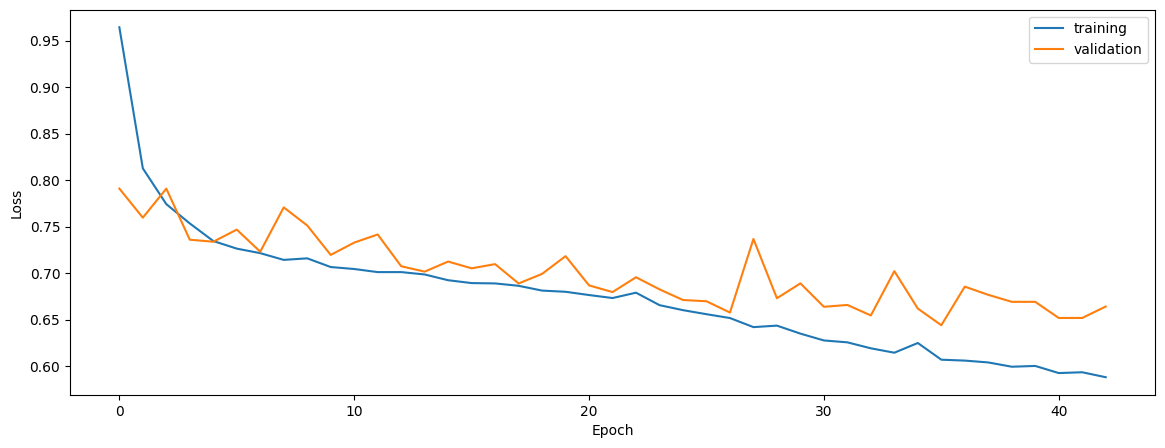

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.7421267802621377
0.7356001449705116
0.7385469519817633


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.7124752139715859
0.7059730765867366
0.7427213787468316


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.7272731139729784
0.7263812591194378
0.7612936080177551


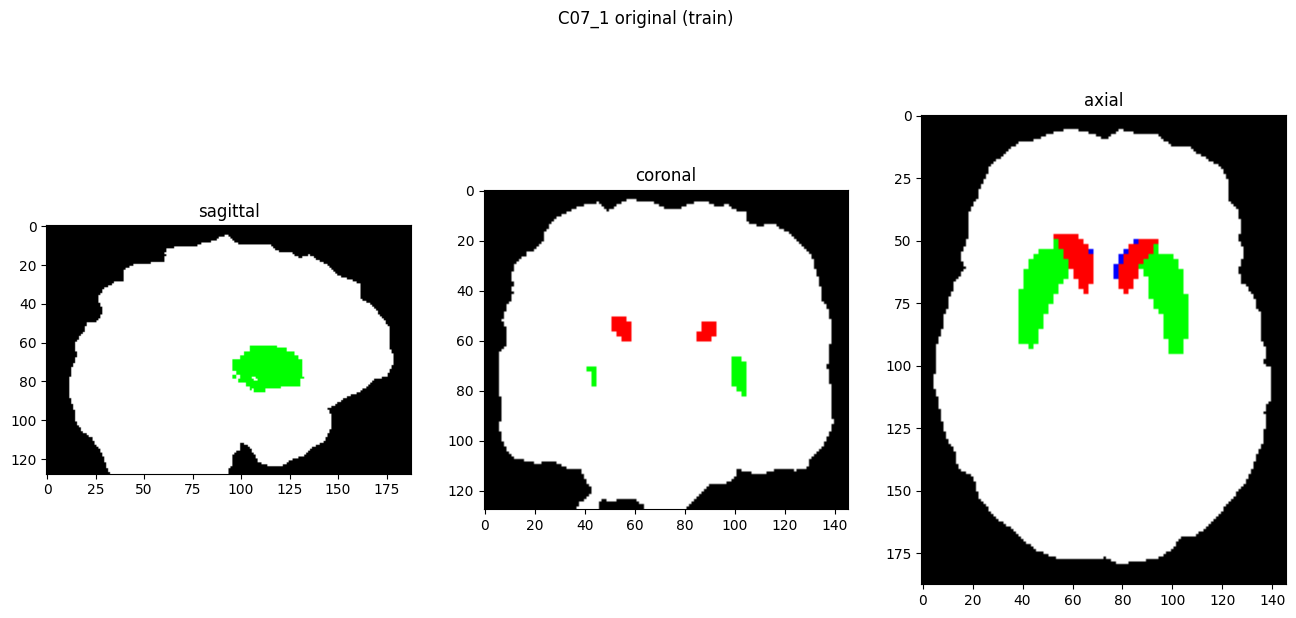

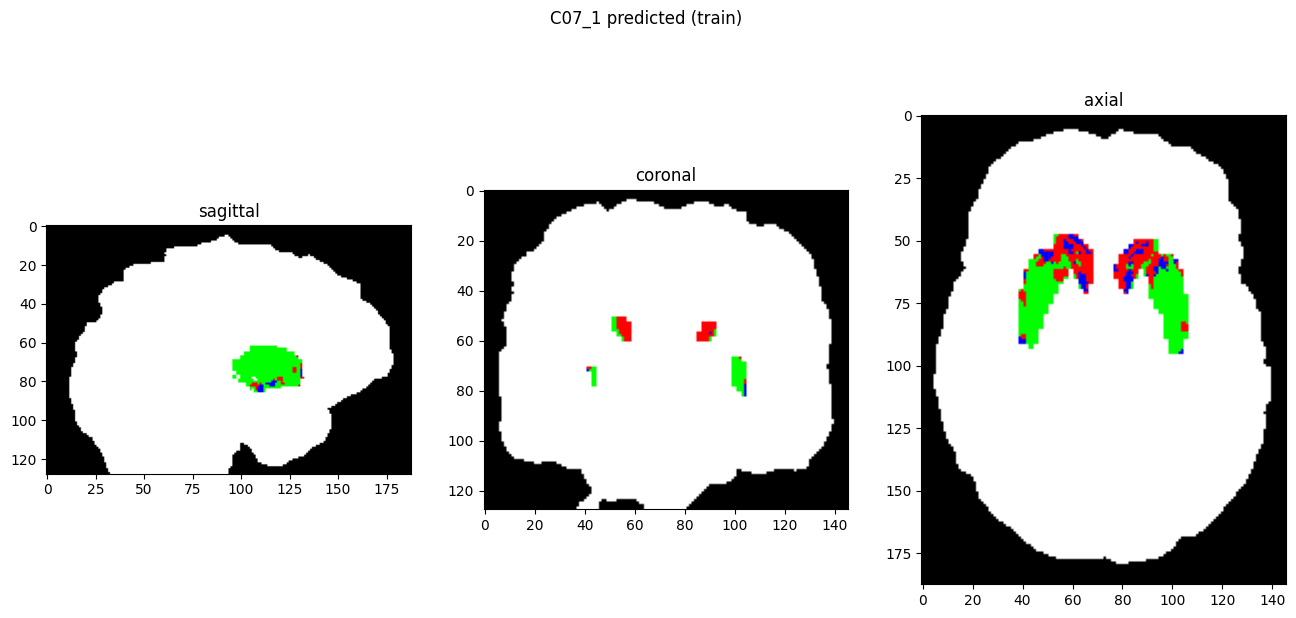

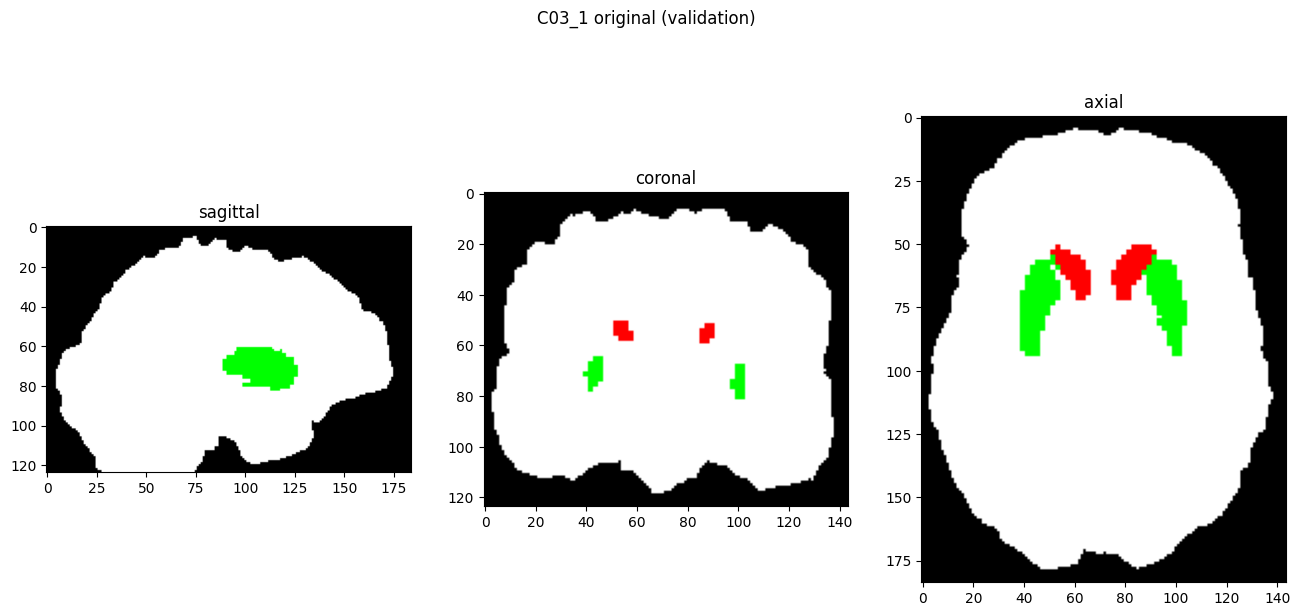

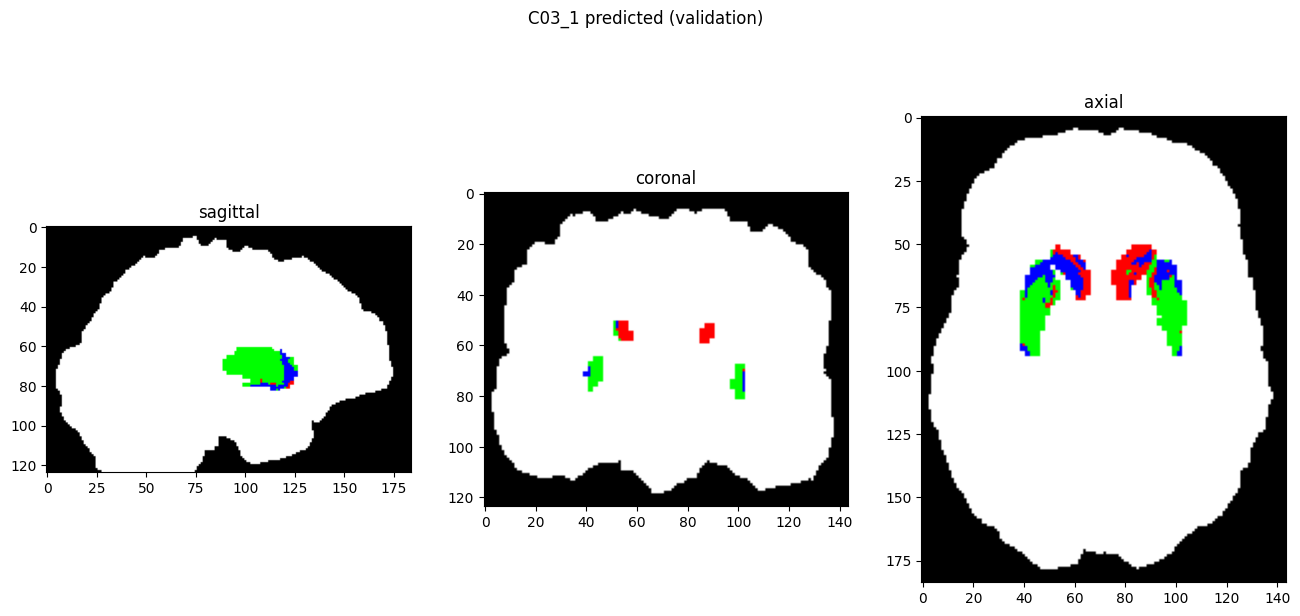

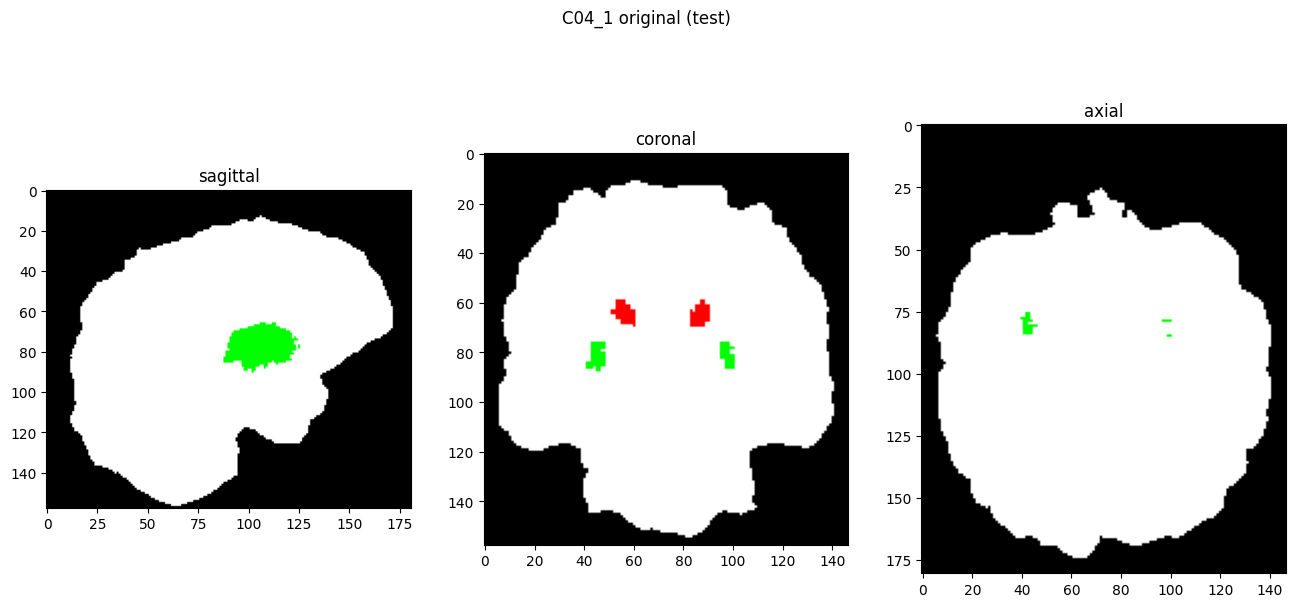

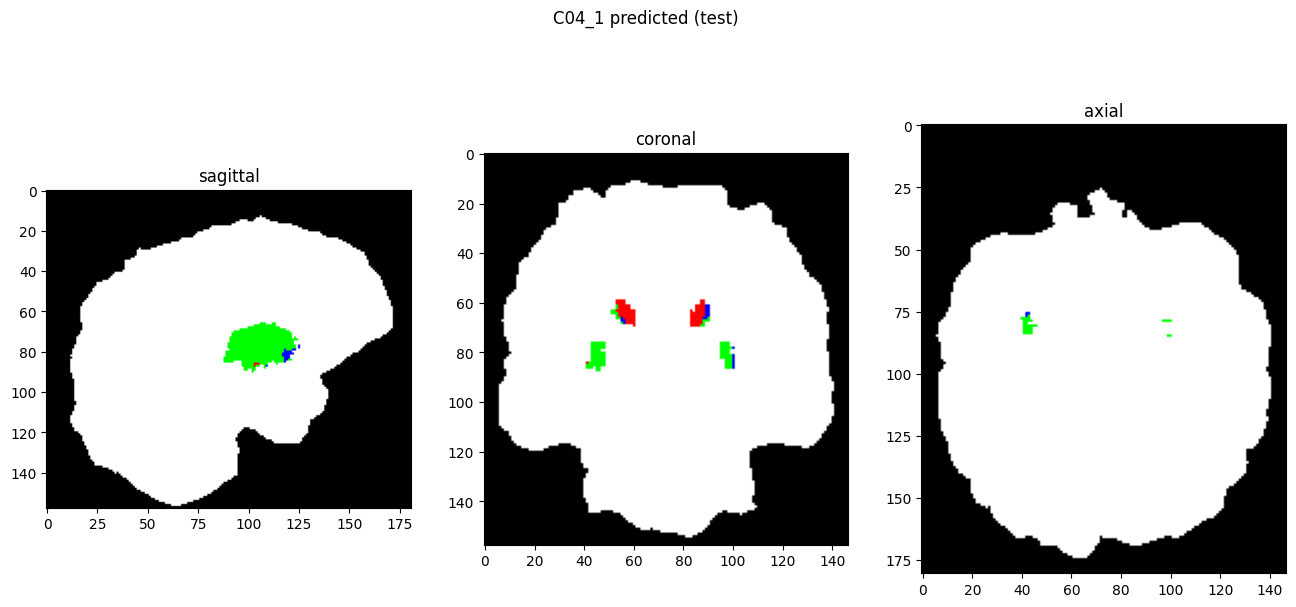

In [10]:
showResults(model, gen, threshold=0)